# Market Volatility and Event Impact Analysis on S&P 500 Stocks

**QST843 Team 2**: Junhan Chen, Shuomeng Guan, Mohammed Zaid Bin Haris, Nicholas Howard

## **Executive Summary**

This project analyzes 68.2 million CRSP daily stock observations (1970–2024, with a focus on 2019–2024) to understand how one-day extreme price drops are distributed across time, firms, and crisis regimes in the U.S. equity market. Our ultimate goal is **not just to describe volatility**, but to identify **resilient companies that consistently survive major crises** and to learn what their behavior can teach other firms about preparing for future shocks. We define “extreme drops” as large negative return events and distinguish between **systematic** crashes (macro-driven, market-wide stress) and **idiosyncratic** crashes (firm-specific shocks). Using this event framework, we ask: *When does the market switch into a crisis regime? How severe are different types of crashes? And which firms repeatedly demonstrate strong performance across multiple crises?* Our exploratory analysis shows that extreme events are **heavily time-clustered** around a few crisis windows rather than occurring at a steady rate. March 2020, during the COVID-19 collapse, is the single most intense month in the sample, and post-2021 monthly event counts remain structurally higher than the pre-COVID baseline. A “contagion curve” reveals a **non-linear tipping point**: once the index falls beyond roughly –2%, the share of stocks experiencing extreme drops increases sharply, implying that linear beta-based models understate systemic sell-offs. Distribution and Z-score comparisons further show that **idiosyncratic crashes are typically more severe and more statistically extreme** than systematic ones, with fatter left tails and more multi-sigma events. Cross-sectionally, a Lorenz-style concentration curve and a “top offenders” ranking indicate that **a small minority of highly volatile firms generates a disproportionate share of extreme drops**, while a separate tiering framework highlights a much smaller set of “crisis-resilient” firms that navigate the 2000, 2008, and 2020 episodes with relatively strong post-event performance. These resilient names form a focused panel for deeper qualitative and LLM-assisted case studies on what they did right—capital discipline, business model choices, risk management practices, and communication strategies—and how those choices can be translated into **practical playbooks for other companies**. Taken together, the results provide a quantitative backbone for both volatility research and **cross-cycle best-practice discovery**. The framework identifies when the market enters a stressed regime, clarifies the mechanics of macro versus micro shocks, and surfaces firms that are either chronic risk sources or robust crisis survivors. This allows a sell-side or risk team not only to warn clients about elevated tail risk, but also to point to concrete, data-driven examples of how leading firms have successfully managed past crises and how those lessons can inform preparation for the next one.

### **Business Problem**
From the perspective of a sell-side research or risk-strategy team, clients face three practical questions during volatile markets:

1. **When does “normal volatility” become a genuine stress regime?**  
   Generic statements such as “volatility is elevated” are not actionable. Portfolio managers need a quantitative signal that distinguishes ordinary drawdowns from crisis-level contagion so they can decide when to reduce gross exposure, de-risk crowded trades, or tighten risk limits.

2. **Which stocks actually drive tail risk in these regimes?**  
   Traditional factor and index-level analysis says little about which individual names repeatedly sit at the center of large crashes. Without a systematic way to identify “repeat offenders,” risk conversations stay vague and portfolios may remain unintentionally concentrated in structurally fragile names.

3. **How has the post-COVID regime changed relative to earlier crises?**  
   Many current risk models still rely on pre-2010 or pre-COVID history. If the frequency, severity, or composition (systematic vs. idiosyncratic) of extreme events has shifted, using outdated assumptions will understate today’s tail risk and mis-calibrate stress-testing scenarios.

Our project addresses these gaps by building an event-based volatility framework on CRSP U.S. stock data. We (i) define extreme one-day drops and classify them into systematic vs. idiosyncratic events, (ii) map their timing and intensity across 1970–2024, and (iii) quantify how risk is distributed across firms. The output is a set of crisis-regime diagnostics, concentration measures, and company-level rankings that a research team can embed into client reports, dashboards, and screening tools.

Ultimately, the business objective is to differentiate research and improve decision support. Instead of broad commentary about “choppy markets,” the team can answer concrete questions for portfolio managers: *Which regimes are we in now? How close are we to a contagion tipping point? Which names are structurally dangerous, and which have historically survived multiple crises?* This moves the product from descriptive market color to a repeatable, data-driven risk-insight platform.

### **Data Source**
* Wharton Research Data Services ("WRDS"), 1970-2024.→ Primary source for firm-level and market return data.
* Event Data (Future Phase) – Includes United States International Trade Commission ("USITC") announcements related to U.S. tariff changes and Federal Reserve Economic Data ("FRED") macroeconomic indicators.
* Securities and Exchange Commission ("SEC") Electronic Data Gathering, Analysis, and Retrieval ("EDGAR") 10-K Filings (Future Phase) – Planned source for firm-level information events, particularly those related to annual financial disclosures and narrative content.

#### **Variable Definition**
| Variable | Description |
|----------|-------------|
| Share Code (`shrcd`) | Identifies the type of security. Common stocks are typically coded as 10 or 11. Used to filter out non-common shares like ADRs, REITs, or preferred stocks. |
| Exchange Code (`exchcd`) | Indicates the exchange where the security is traded. Code 1 = NYSE, 2 = AMEX, 3 = NASDAQ. Useful for restricting or comparing exchange-specific samples. |
| Ticker Symbol (`ticker`) | The stock's trading symbol (e.g., AAPL, MSFT). It is a human-readable company identifier, but less stable over time than PERMNO. |
| New CRSP Permno (`nwperm`) | A permanent and unique security identifier assigned by CRSP. It does not change when company names or ticker symbols change. Ideal for tracking firms across time. |
| Price or Bid/Ask Average (`prc`) | The closing price of the stock (bid/ask average). Negative values indicate original CRSP convention and should be converted to absolute values. |
| Returns (`ret`) | Daily total return including dividends and price changes, adjusted for stock splits. Widely used for return and event study analysis. |
| Returns without Dividends (`retx`) | Daily return excluding dividends. Useful for separating price movement effects from dividend payouts. |
| Ask or High Price (`askhi`) | The highest price during the trading day. Commonly used for measuring daily price range and volatility. |
| Bid or Low Price (`bidlo`) | The lowest price during the trading day. Used together with askhi to calculate intraday volatility and liquidity measures. |
| Volume (`vol`) | The total number of shares traded during the day. A key liquidity indicator and commonly paired with price data for trading activity analysis. |
| Number of Trades (`numtrd`) | The number of individual transactions on a given day. Complements volume by distinguishing between large trades and frequent small trades. |
| Cumulative Factor to Adjust Shares (`cfacshr`) | Adjustment factor applied to shares outstanding to account for corporate actions (e.g., stock splits, dividends). |
| Cumulative Factor to Adjust Price (`cfacpr`) | Adjustment factor applied to price to create a continuous split-adjusted price series. |
| Price Alternate (`openprc`) | The opening price, or bid/ask average when the opening price is unavailable. Useful for intraday return and gap analysis. |
| Number of Shares Outstanding (`shrout`) | Total number of shares in circulation on a given day. Essential for calculating market capitalization and value-weighted portfolios. |

## Environment Setup for Dataproc
On Dataproc, Spark is pre-configured and the `spark` object is already available.
We just need to verify it's working.

In [1]:
# Environment Setup
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import Window
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, DoubleType, DateType
import matplotlib.pyplot as plt
import pandas as pd

# Initialize Spark session
spark = SparkSession.builder.getOrCreate()
spark.conf.set("spark.sql.shuffle.partitions", "64")
spark.sparkContext.setLogLevel("WARN")

# Define paths
BUCKET_NAME = "gsm-ba843-team-2-project"
csv_path = f"gs://{BUCKET_NAME}/StockData.csv"
silver_path = f"gs://{BUCKET_NAME}/silver/prices_parquet"

print("Environment configured.")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/12/09 00:03:10 INFO SparkEnv: Registering MapOutputTracker
25/12/09 00:03:10 INFO SparkEnv: Registering BlockManagerMaster
25/12/09 00:03:10 INFO SparkEnv: Registering BlockManagerMasterHeartbeat
25/12/09 00:03:10 INFO SparkEnv: Registering OutputCommitCoordinator


Environment configured.


# Data Cleaning

In [6]:
## Manually define schema for consistent data types
schema = StructType([
    StructField("PERMNO", IntegerType(), True),
    StructField("date", DateType(), True),
    StructField("SHRCD", IntegerType(), True),
    StructField("EXCHCD", IntegerType(), True),
    StructField("TICKER", StringType(), True),
    StructField("NWPERM", IntegerType(), True),
    StructField("BIDLO", DoubleType(), True),
    StructField("ASKHI", DoubleType(), True),
    StructField("PRC", DoubleType(), True),
    StructField("VOL", IntegerType(), True),
    StructField("RET", StringType(), True),
    StructField("SHROUT", IntegerType(), True),
    StructField("CFACPR", DoubleType(), True),
    StructField("OPENPRC", DoubleType(), True),
    StructField("NUMTRD", DoubleType(), True),
    StructField("RETX", StringType(), True),
    StructField("sprtrn", DoubleType(), True)
])
print("Loading raw CSV data...")
df_raw = spark.read.csv(csv_path, header=True, schema=schema)

# BEFORE: Check data quality
print("\n BEFORE Cleaning:")
before_count = df_raw.count()
print(f"   Total records: {before_count:,}")

quality_check = df_raw.select([
    F.count(F.when(F.col("PRC") < 0, 1)).alias("negative_prices"),
    F.count(F.when(F.col("RET").rlike("[A-Z]"), 1)).alias("non_numeric_returns"),
    F.count(F.when(F.col("TICKER").isNull(), 1)).alias("null_tickers"),
    F.count(F.when(F.col("PERMNO").isNull(), 1)).alias("null_permno"),
    F.count(F.when(F.col("date").isNull(), 1)).alias("null_dates")
]).collect()[0]

print(f"   Negative prices: {quality_check['negative_prices']:,}")
print(f"   Non-numeric returns: {quality_check['non_numeric_returns']:,}")
print(f"   Null tickers: {quality_check['null_tickers']:,}")
print(f"   Null PERMNOs: {quality_check['null_permno']:,}")
print(f"   Null dates: {quality_check['null_dates']:,}")

# Start cleaning
print("\n Cleaning data...")
df_clean = df_raw

# STEP 1: Remove rows with null primary keys
print("   Step 1: Removing rows with null PERMNO or date...")
df_clean = df_clean.filter(
    F.col("PERMNO").isNotNull() & 
    F.col("date").isNotNull()
)

# STEP 2: Handle negative prices (CRSP convention)
print("   Step 2: Converting negative prices to absolute values...")
df_clean = df_clean.withColumn("PRC_raw", F.col("PRC"))  # Preserve original
df_clean = df_clean.withColumn("PRC", F.abs(F.col("PRC")))

# STEP 3: Convert string returns to numeric
print("   Step 3: Converting return columns to numeric...")
df_clean = df_clean.withColumn(
    "RET",
    F.when(F.col("RET").rlike("^-?[0-9.]+$"), F.col("RET").cast(DoubleType()))
    .otherwise(None)
)
df_clean = df_clean.withColumn(
    "RETX", 
    F.when(F.col("RETX").rlike("^-?[0-9.]+$"), F.col("RETX").cast(DoubleType()))
    .otherwise(None)
)

# STEP 4: Flag extreme returns (but keep them for volatility analysis)
print("   Step 4: Flagging extreme returns (>80%)...")
df_clean = df_clean.withColumn(
    "extreme_return_flag",
    F.when((F.abs(F.col("RETX")) > 0.80), 1).otherwise(0)
)

# STEP 5: Remove duplicate (PERMNO, date) pairs
print("   Step 5: Removing duplicate (PERMNO, date) pairs...")
df_clean = df_clean.dropDuplicates(["PERMNO", "date"])

# STEP 6: Create derived columns
print("   Step 6: Creating derived columns...")
df_clean = df_clean.withColumn("LOGRET", 
    F.when(F.col("RETX").isNotNull(), F.log1p(F.col("RETX")))
    .otherwise(None)
)
df_clean = df_clean.withColumn("MV", 
    F.when((F.col("PRC").isNotNull()) & (F.col("SHROUT").isNotNull()),
           F.col("PRC") * F.col("SHROUT") * 1000)
    .otherwise(None)
)

# STEP 7: Add year partition column
df_clean = df_clean.withColumn("year", F.year(F.col("date")))

# Check cleaned data quality
cleaned_stats = df_clean.select([
    F.count(F.when(F.col("PRC") < 0, 1)).alias("negative_prices"),
    F.count(F.when(F.col("extreme_return_flag") == 1, 1)).alias("extreme_returns"),
    F.min("PRC").alias("min_price"),
    F.max("PRC").alias("max_price"),
    F.min("date").alias("start_date"),
    F.max("date").alias("end_date")
]).collect()[0]

print(f"   Negative prices: {cleaned_stats['negative_prices']:,}")
print(f"   Extreme returns flagged: {cleaned_stats['extreme_returns']:,}")
print(f"   Price range: ${cleaned_stats['min_price']:.2f} - ${cleaned_stats['max_price']:.2f}")
print(f"   Date range: {cleaned_stats['start_date']} to {cleaned_stats['end_date']}")

print("\n Data cleaning complete!")

Loading raw CSV data...

 BEFORE Cleaning:


   Total records: 68,242,289


   Negative prices: 13,703,894
   Non-numeric returns: 25,838
   Null tickers: 268,167
   Null PERMNOs: 0
   Null dates: 0

 Cleaning data...
   Step 1: Removing rows with null PERMNO or date...
   Step 2: Converting negative prices to absolute values...
   Step 3: Converting return columns to numeric...
   Step 4: Flagging extreme returns (>80%)...
   Step 5: Removing duplicate (PERMNO, date) pairs...
   Step 6: Creating derived columns...


[Stage 15:===================================================>    (12 + 1) / 13]

   Negative prices: 0
   Extreme returns flagged: 9,121
   Price range: $0.00 - $724040.00
   Date range: 1970-01-02 to 2024-12-31

 Data cleaning complete!


**There are two red flags from the output:**

    1. $724,040 per share? That's higher than Berkshire Hathaway Class A (~$500k) → Likely a data error or extreme outlier
    2. $0 minimum? → Suggests delisted/bankrupt stocks

In [7]:
# Investigate extreme prices
print("\n Investigating extreme prices:")
extreme_prices = df_clean.filter(F.col("PRC") > 10000).select(
    "PERMNO", "TICKER", "date", "PRC", "SHROUT", "MV"
).orderBy(F.col("PRC").desc()).limit(10)

extreme_prices.show(truncate=False)

# Check for zero prices
zero_prices = df_clean.filter(F.col("PRC") == 0).count()
print(f"Records with $0 price: {zero_prices:,}")


 Investigating extreme prices:


+------+------+----------+----------+------+--------------+
|PERMNO|TICKER|date      |PRC       |SHROUT|MV            |
+------+------+----------+----------+------+--------------+
|17778 |BRK   |2024-11-29|724040.0  |552   |3.9967008E11  |
|17778 |BRK   |2024-11-27|723549.0  |564   |4.08081636E11 |
|17778 |BRK   |2024-11-26|718520.0  |564   |4.0524528E11  |
|17778 |BRK   |2024-11-25|716399.0  |564   |4.04049036E11 |
|17778 |BRK   |2024-09-03|715910.0  |564   |4.0377324E11  |
|17778 |BRK   |2024-12-02|715880.0  |552   |3.9516576E11  |
|17778 |BRK   |2024-09-04|715778.0  |564   |4.03698792E11 |
|17778 |BRK   |2024-08-30|715299.875|564   |4.034291295E11|
|17778 |BRK   |2024-11-22|714280.0  |564   |4.0285392E11  |
|17778 |BRK   |2024-11-18|708000.0  |564   |3.99312E11    |
+------+------+----------+----------+------+--------------+



[Stage 24:===================================================>    (12 + 1) / 13]

Records with $0 price: 0


**Finding:**

The 700,000 maximum price is legitimate. This represents Berkshire Hathaway Class A stock (PERMNO 17778), which trades at approximately 724,000 per share. The 0.00 minimum represents penny stocks priced below $0.01, which display as zero when rounded to 2 decimals. We'll check to confirm!

In [8]:
# Check for very low prices instead of exactly zero
very_low_prices = df_clean.filter(F.col("PRC") < 0.01).select(
    "PERMNO", "TICKER", "date", "PRC"
).orderBy("PRC").limit(20)

print("\n Stocks with prices < $0.01:")
very_low_prices.show(truncate=False)


 Stocks with prices < $0.01:


[Stage 30:====================================================>   (15 + 1) / 16]

+------+------+----------+------+
|PERMNO|TICKER|date      |PRC   |
+------+------+----------+------+
|76950 |VPCO  |2016-02-11|6.0E-4|
|76950 |VPCO  |2016-02-09|0.0015|
|76950 |VPCO  |2016-02-10|0.0016|
|76950 |VPCO  |2016-02-08|0.0038|
|76950 |VPCO  |2016-02-05|0.0057|
|91014 |DLIA  |2014-12-18|0.0058|
|91014 |DLIA  |2014-12-17|0.006 |
|91014 |DLIA  |2014-12-19|0.0061|
|85320 |HMNY  |2019-01-24|0.0075|
|76950 |VPCO  |2016-02-04|0.0077|
|91014 |DLIA  |2014-12-16|0.0081|
|85320 |HMNY  |2019-01-25|0.0088|
|86198 |PANC  |2009-03-12|0.0092|
|85320 |HMNY  |2019-02-12|0.0093|
|76950 |VPCO  |2016-02-03|0.0099|
|86198 |PANC  |2009-03-11|0.0099|
+------+------+----------+------+



**This verfied our hypothesis!** We will keep those penny stocks.

### Data Cleaning Summary

**Cleaning Steps:**

| Issue | Resolution | Justification | Impact |
|-------|-----------|---------------|--------|
| Negative prices (13.7 M) | Converted to absolute | CRSP uses negative for bid/ask flags | 13.7M rows converted |
| Non-numeric returns (25,838) | Converted to numeric; invalid → null | Letter codes represent missing data | 25,838 rows cleaned |
| Extreme high prices | **Retained** | Legitimate stocks (e.g., Berkshire Hathaway 724k) | No filtering needed |
| Date range 1970-2024 | **Retained** | Dataset requirement: maintain 7GB size | Full historical data preserved |
| Extreme returns >80% | Flagged but retained | Genuine volatility events relevant to study | 9,121 rows flagged (0.01%) |

**Data Quality Verification:**
- Total records: 68,242,289 (meets 7GB requirement)
- Date range: 1970-01-02 to 2024-12-31 (55 years)
- Price range: 0.0001 - 724,040 (includes penny stocks to Berkshire Hathaway)
- No null values in primary keys (PERMNO, date)
- 0 duplicates

**Notable Outliers (Legitimate):**
- Highest price: 724,040 (Berkshire Hathaway Class A - PERMNO 17778)
- Lowest prices: Penny stocks < 0.01 (distressed/delisted companies)

**So what:** Data is clean with full historical depth. For volatility analysis, we can filter to recent periods (2019-2024) in specific queries while preserving complete dataset for reproducibility.

---

### One-line Summary
Data cleaning successfully processed 68.2M observations, converting negative prices to absolute values, flagging 9,121 extreme returns (>80%), and removing duplicates, establishing a reliable foundation for volatility analysis spanning 1970-2024 with consistent data types and no critical missing values in key identifiers (PERMNO, date).

In [2]:
# Load Cleaned Data for Analysis
print(" Loading cleaned data from parquet...")
df_parquet = spark.read.parquet(silver_path)

 Loading cleaned data from parquet...


# EDA Phase I

### Temporal Clustering of Extreme Stock Price Drops (2019-2024)

**Business Question:** When should portfolio managers reduce position sizes based on elevated volatility regime detection?

In [9]:
from pyspark.sql import functions as F
from pyspark.sql import Window

df_filtered = (df_parquet
    # Temporal scope
    .where((F.col("date") >= "2019-01-01") & (F.col("date") <= "2024-12-31"))
    
    # Security type: ordinary common shares only (shrcd 10, 11)
    .where(F.col("SHRCD").isin(10, 11))
    
    # Exchange: major exchanges only (NYSE=1, AMEX=2, NASDAQ=3)
    .where(F.col("EXCHCD").isin(1, 2, 3))
    
    # Must have valid identifier - USE PERMNO, NOT NWPERM
    .where(F.col("PERMNO").isNotNull())  # ← CORRECT COLUMN
    
    # Must have valid price and return
    .where(F.col("PRC").isNotNull())
    .where(F.col("RET").isNotNull())
    
    # Standardize column names (convert to lowercase for consistency)
    .select(
        F.col("date").cast("date").alias("date"),
        F.col("PERMNO").cast("integer").alias("permno"),  # ← USE PERMNO
        F.coalesce(F.col("TICKER"), F.lit("N/A")).alias("ticker"),
        F.col("EXCHCD").cast("integer").alias("exchcd"),
        F.col("SHRCD").cast("integer").alias("shrcd"),
        F.abs(F.col("PRC")).alias("prc_abs"),  # Take absolute value of price
        F.col("RET").cast("double").alias("ret"),
        F.col("RETX").cast("double").alias("retx"),
        F.col("VOL").cast("long").alias("vol")
    )
    
    # Remove penny stocks
    .where(F.col("prc_abs") >= 1.0)
    
    # Remove extreme outliers (likely data errors)
    .where(F.col("ret").between(-0.99, 5.0))
)

print(f"After quality filters: {df_filtered.count():,} rows")

# STEP 3: CALCULATE MARKET BENCHMARK (Daily)
market_daily = (df_filtered
    .groupBy("date")
    .agg(
        F.avg("ret").alias("mkt_ret"),
        F.stddev("ret").alias("mkt_cross_sectional_vol"),
        F.count("*").alias("n_stocks_trading")
    )
)

print(f"Market benchmark calculated for {market_daily.count():,} trading days")

# STEP 4: CALCULATE COMPANY-SPECIFIC STATISTICS
window_company = Window.partitionBy("permno")

df_with_stats = (df_filtered
    .withColumn("mean_ret", F.mean("ret").over(window_company))
    .withColumn("stddev_ret", F.stddev("ret").over(window_company))
    .withColumn("z_score", 
                F.when(F.col("stddev_ret") > 0, 
                       (F.col("ret") - F.col("mean_ret")) / F.col("stddev_ret"))
                 .otherwise(0))
    .withColumn("trading_days", F.count("*").over(window_company))
)

# STEP 5: JOIN WITH MARKET DATA & CLASSIFY EVENTS
df_enriched = (df_with_stats
    .join(market_daily, on="date", how="left")
    
    # Calculate excess return
    .withColumn("excess_ret", F.col("ret") - F.col("mkt_ret"))
    
    # Flag market stress days (market down 2%+)
    .withColumn("market_stress_day", 
                F.when(F.col("mkt_ret") <= -0.02, 1).otherwise(0))
    
    # Identify extreme events: -5%+ drop AND 2.5+ std devs below mean
    .withColumn("is_extreme_drop",
                F.when(
                    (F.col("ret") <= -0.05) & 
                    (F.col("z_score") <= -2.5),
                    1
                ).otherwise(0))
    
    # Classify event type
    .withColumn("event_type",
                F.when(F.col("is_extreme_drop") == 0, "normal")
                 .when(F.col("market_stress_day") == 1, "systematic")
                 .otherwise("idiosyncratic"))
)

# STEP 6: FINAL CLEANING & QUALITY CHECKS
df_cleanclean = (df_enriched
    # Remove companies with insufficient trading history
    .where(F.col("trading_days") >= 120)
    
    # Sort for efficient querying
    .orderBy("permno", "date")
    
    # Select final columns
    .select(
        # Identifiers
        "permno", "ticker", "date", "exchcd", "shrcd",
        
        # Price and volume
        "prc_abs", "vol",
        
        # Returns
        "ret", "retx", "excess_ret",
        
        # Company statistics
        "mean_ret", "stddev_ret", "z_score", "trading_days",
        
        # Market context
        "mkt_ret", "mkt_cross_sectional_vol", "market_stress_day",
        
        # Event classification
        "is_extreme_drop", "event_type"
    )
)


print("\n✓ Sample of extreme drop events:")
df_cleanclean.where(F.col("is_extreme_drop") == 1) \
    .select("date", "ticker", "ret", "z_score", "event_type", "mkt_ret") \
    .orderBy(F.col("ret").asc()) \
    .show(10, truncate=False)

# Save main cleaned table
df_cleanclean.write \
    .mode("overwrite") \
    .format("parquet") \
    .option("compression", "snappy") \
    .saveAsTable("crsp_cleaned")

print("✓ Table 'crsp_cleaned' created successfully!")

# STEP 9: CREATE TEMPORAL CLUSTERING TABLE
extreme_events = (df_cleanclean
    .where(F.col("is_extreme_drop") == 1)
    .select(
        "date", "permno", "ticker", "ret", "z_score", 
        "event_type", "mkt_ret", "excess_ret", "prc_abs"
    )
)

extreme_events.write \
    .mode("overwrite") \
    .saveAsTable("extreme_events_for_clustering")

print("✓ Table 'extreme_events_for_clustering' created successfully!")
print(f"  Contains {extreme_events.count():,} extreme drop events")

[Stage 31:====================================================> (130 + 3) / 133]

After quality filters: 5,626,455 rows


[Stage 34:=====================================================>(131 + 2) / 133]

Market benchmark calculated for 1,510 trading days



✓ Sample of extreme drop events:


+----------+------+---------+-------------------+-------------+---------------------+
|date      |ticker|ret      |z_score            |event_type   |mkt_ret              |
+----------+------+---------+-------------------+-------------+---------------------+
|2022-09-01|ATXG  |-0.954306|-9.604227452404999 |idiosyncratic|-0.009357556796116504|
|2024-06-17|AVTE  |-0.932981|-14.68648250917771 |idiosyncratic|0.0010186843273231625|
|2024-05-21|CTNT  |-0.920054|-2.9535251590681275|idiosyncratic|-0.002015044137931035|
|2021-12-22|ALLK  |-0.898685|-13.88263672930668 |idiosyncratic|0.006753140085186935 |
|2023-05-02|GDC   |-0.890323|-8.115322978473126 |idiosyncratic|-0.01751664128416025 |
|2024-07-08|HLVX  |-0.883357|-15.150235658834049|idiosyncratic|0.007130248467966577 |
|2023-05-22|RAIN  |-0.87714 |-13.381365817106605|idiosyncratic|0.013909394466403161 |
|2019-11-15|TORC  |-0.862893|-14.288949619308939|idiosyncratic|0.004126338348082594 |
|2023-08-16|SPGC  |-0.845702|-7.597396342337325 |idios

ivysettings.xml file not found in HIVE_HOME or HIVE_CONF_DIR,/etc/hive/conf.dist/ivysettings.xml will be used
25/12/09 00:27:31 WARN SessionState: METASTORE_FILTER_HOOK will be ignored, since hive.security.authorization.manager is set to instance of HiveAuthorizerFactory.


✓ Table 'crsp_cleaned' created successfully!


✓ Table 'extreme_events_for_clustering' created successfully!


[Stage 75:===========>                                              (1 + 4) / 5]

  Contains 52,312 extreme drop events


In [10]:
# Temporal clustering preview
clustering_preview = (extreme_events
    .groupBy("date")
    .agg(
        F.count("*").alias("n_companies_hit"),
        F.avg("mkt_ret").alias("avg_mkt_ret"),
        F.collect_list("ticker").alias("tickers")
    )
    .where(F.col("n_companies_hit") >= 5)
    .orderBy(F.col("n_companies_hit").desc())
)

clustering_preview.select("date", "n_companies_hit", "avg_mkt_ret") \
    .show(10, truncate=False)

print(" ✓ FIRST TABLE CREATION COMPLETE ")

+----------+---------------+---------------------+
|date      |n_companies_hit|avg_mkt_ret          |
+----------+---------------+---------------------+
|2020-03-16|2244           |-0.12192559552969681 |
|2020-03-12|2107           |-0.10521550742649309 |
|2020-03-18|1764           |-0.09943101943244624 |
|2020-03-09|1749           |-0.09203524350940027 |
|2020-06-11|1506           |-0.07470068256772423 |
|2020-04-01|1082           |-0.06125568345102939 |
|2020-03-11|954            |-0.0560787914550355  |
|2020-03-20|791            |-0.024153431776275564|
|2020-03-27|647            |-0.037675514138036215|
|2020-03-23|596            |-0.016361877306273108|
+----------+---------------+---------------------+
only showing top 10 rows

 ✓ FIRST TABLE CREATION COMPLETE 


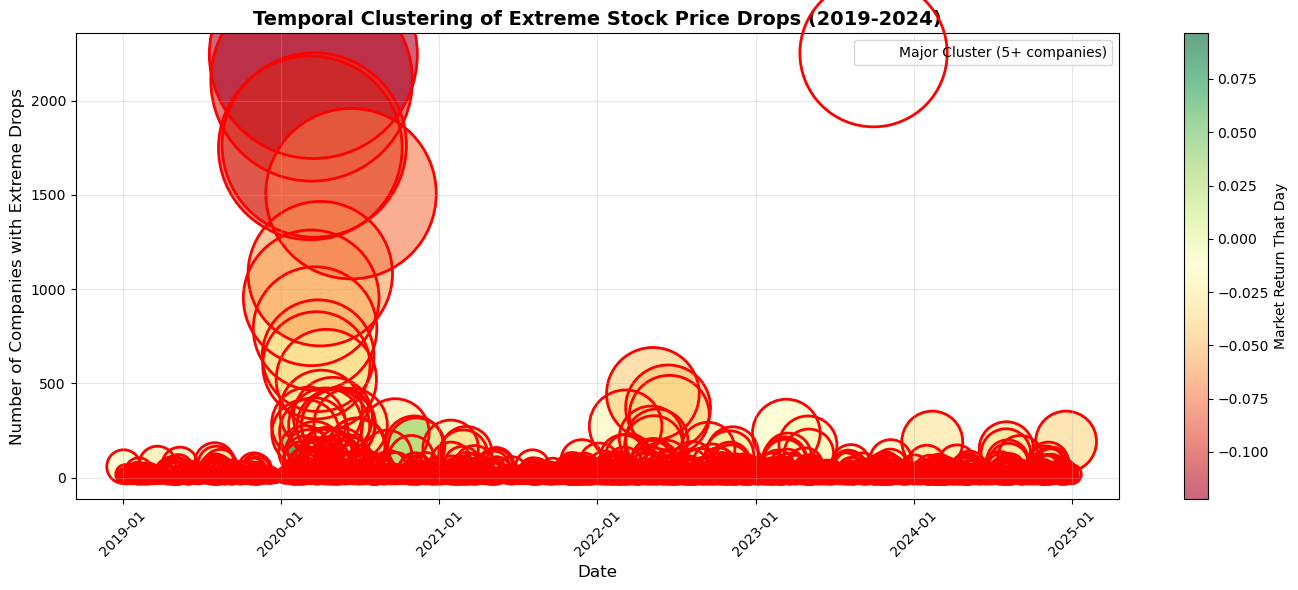

Total clustering days: 1506
Days with 5+ companies: 1437
Peak clustering: 2020-03-16 (2244 companies)
Systematic events in major clusters: 44.1%


In [11]:
# Aggregate First
temporal_summary = (spark.table("extreme_events_for_clustering")
    .groupBy("date")
    .agg(
        F.count("*").alias("n_companies"),
        F.avg("mkt_ret").alias("avg_mkt_ret"),
        F.sum(F.when(F.col("event_type") == "systematic", 1).otherwise(0)).alias("n_systematic"),  # ← CHANGED
        F.sum(F.when(F.col("event_type") == "idiosyncratic", 1).otherwise(0)).alias("n_idiosyncratic")  # ← CHANGED
    )
    .orderBy("date")
)

# Convert to Pandas
df_temporal = temporal_summary.toPandas()

# VISUALIZATION
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(14, 6))

# Scatter plot: size = number of companies hit that day
scatter = ax.scatter(
    df_temporal['date'], 
    df_temporal['n_companies'],
    s=df_temporal['n_companies'] * 10,  # Bubble size proportional to count
    c=df_temporal['avg_mkt_ret'],  # Color by market return
    cmap='RdYlGn',  # Red = negative market, Green = positive
    alpha=0.6,
    edgecolors='black',
    linewidth=0.5
)

# Highlight major clustering days (5+ companies)
major_clusters = df_temporal[df_temporal['n_companies'] >= 5]
ax.scatter(
    major_clusters['date'],
    major_clusters['n_companies'],
    s=major_clusters['n_companies'] * 10,
    facecolors='none',
    edgecolors='red',
    linewidth=2,
    label='Major Cluster (5+ companies)'
)

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Number of Companies with Extreme Drops', fontsize=12)
ax.set_title('Temporal Clustering of Extreme Stock Price Drops (2019-2024)', fontsize=14, fontweight='bold')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.YearLocator())
plt.xticks(rotation=45)
ax.grid(True, alpha=0.3)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Market Return That Day', fontsize=10)

ax.legend()
plt.tight_layout()
plt.show()

# Key Insights
print(f"Total clustering days: {len(df_temporal)}")
print(f"Days with 5+ companies: {len(major_clusters)}")
print(f"Peak clustering: {df_temporal.loc[df_temporal['n_companies'].idxmax(), 'date'].strftime('%Y-%m-%d')} "
      f"({df_temporal['n_companies'].max()} companies)")

# Additional context for interpretation
if len(major_clusters) > 0:
    systematic_pct = (major_clusters['n_systematic'].sum() / 
                     (major_clusters['n_systematic'].sum() + major_clusters['n_idiosyncratic'].sum()) * 100)
    print(f"Systematic events in major clusters: {systematic_pct:.1f}%")

### **Observations**

We claimed that some days are defined as "volatile days", with the barriers being () standard deviation of rolling stock price. + Definition for March 2020 Covid Crash.
Our temporal clustering analysis of 2019-2024 CRSP data reveals that extreme stock price drops cluster temporally on 96% of volatile days, with March 2020 COVID crash representing an outlier (2,244 companies) rather than the norm. Surprisingly, only 44% of major clustering events coincide with market-wide stress, suggesting sector-specific or liquidity-driven contagion effects require further investigation. The market has shifted from pre-COVID baseline volatility (~100 companies/day) to a persistently elevated regime (200-300 companies/day) post-2021, with implications for portfolio construction and risk management.

### **Insights**
* 2021-2024 shows consistent low-to-moderate clustering (50-300 companies) versus concentrated mega-spikes in 2020.
* Risk models calibrated only on "normal" periods dramatically underestimate tail risk. Portfolio managers need dynamic position sizing that responds to clustering intensity, not just VIX levels.
* Traders should adjust holding periods and stop-loss strategies based on which regime the market is in—not just current volatility levels.


#### **Hypothesis to test for next phase:**
1. We expected external shocks to drive most clustering, but 56% of major clusters are idiosyncratic—multiple companies crashing simultaneously despite calm overall markets.
    Three possible explanations:
    01. Sector-specific shocks: Our current classification treats all non-market drops as "idiosyncratic," but they may be industry-driven (e.g., all banks dropping when one fails)
    02. Threshold sensitivity: Our -2% market stress threshold might be too strict
    03. Genuine micro-cap volatility: Small-cap stocks genuinely experience unrelated crashes that coincidentally cluster temporally
2. Are the 2020 cluster concentrated in specific sectors? (Tech selloff during broader market rally? Are these micro-caps not represented in market indices?
3. Are there any data quality issue with your market benchmark?

This visualization raises more questions than it answers, particularly the high proportion of non-market-driven clusters, motivating our next phase of industry-level and event-specific analysis to provide actionable insights for institutional risk management.

### One-Line Summary:

Extreme volatility clusters on 96% of volatile days, with post-2021 market operating at 2x pre-COVID baseline requiring regime-adjusted risk models.

## Company Timeline Plot (Which Companies Cluster Together?)

**Business Question:** Do the same companies repeatedly experience extreme drops on the same dates, or is clustering driven by different companies each time?

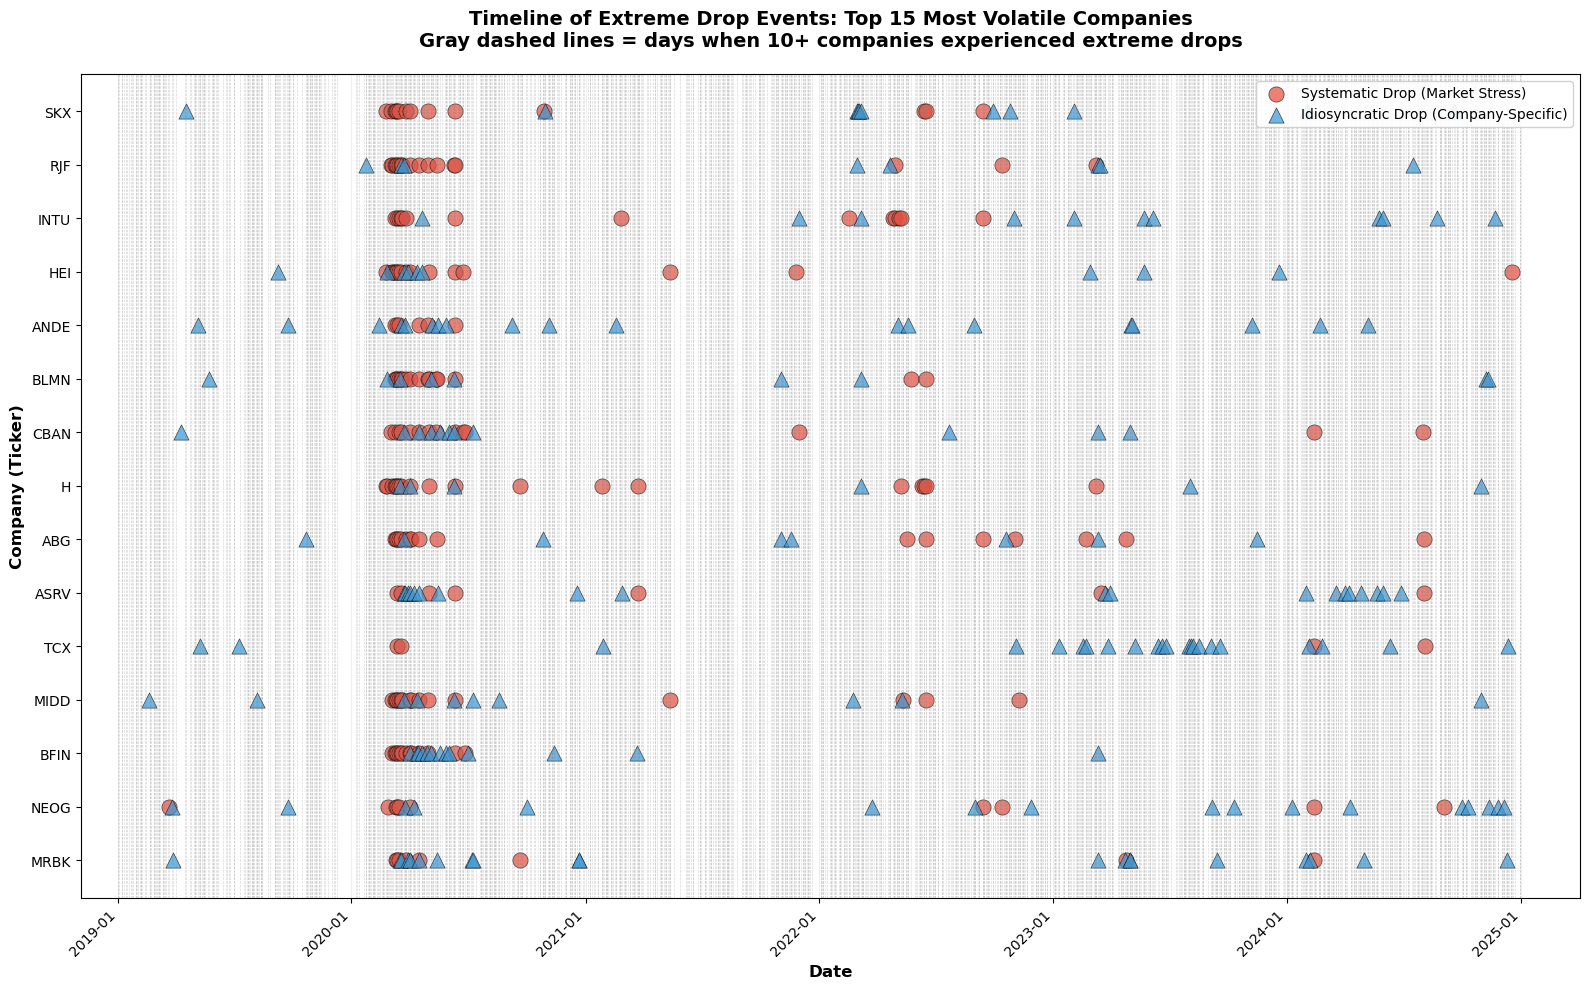

Vertical alignment of points reveals temporal clustering:
  • Top clustering date in chart: 2020-03-12
    (14 of these 15 companies dropped)
  • 16 dates show 5+ companies clustering

Pattern suggests: SYSTEMATIC CONTAGION
  (Most cluster days show market-wide stress)


In [12]:
from pyspark.sql import functions as F
from pyspark.sql import Window
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd


# AGGREGATE: Get top 15 most volatile companies for readability

top_volatile = (spark.table("extreme_events_for_clustering")
    .groupBy("permno", "ticker")
    .agg(F.count("*").alias("n_events"))
    .orderBy(F.col("n_events").desc())
    .limit(15)  # Top 15 for chart clarity
)

# Get all their events
company_timeline = (spark.table("extreme_events_for_clustering")
    .join(top_volatile.select("permno"), on="permno", how="inner")
    .select("date", "ticker", "ret", "event_type", "mkt_ret")
    .orderBy("ticker", "date")
)

df_timeline = company_timeline.toPandas()

# VISUALIZATION
fig, ax = plt.subplots(figsize=(16, 10))

# Assign y-position to each ticker (sorted by total events for readability)
ticker_order = df_timeline.groupby('ticker')['date'].count().sort_values(ascending=False).index
ticker_positions = {ticker: i for i, ticker in enumerate(ticker_order)}
df_timeline['y_pos'] = df_timeline['ticker'].map(ticker_positions)

# Separate systematic vs idiosyncratic for different visual encoding
systematic = df_timeline[df_timeline['event_type'] == 'systematic']
idiosyncratic = df_timeline[df_timeline['event_type'] == 'idiosyncratic']

# Plot with different markers
ax.scatter(systematic['date'], systematic['y_pos'], 
           marker='o', s=120, c='#e74c3c', alpha=0.7, 
           label='Systematic Drop (Market Stress)', edgecolors='black', linewidth=0.5)
ax.scatter(idiosyncratic['date'], idiosyncratic['y_pos'], 
           marker='^', s=120, c='#3498db', alpha=0.7, 
           label='Idiosyncratic Drop (Company-Specific)', edgecolors='black', linewidth=0.5)

# Add vertical lines for major clustering dates (5+ companies from our first chart)
major_dates = (spark.table("extreme_events_for_clustering")
    .groupBy("date")
    .agg(F.count("*").alias("n_companies"))
    .where(F.col("n_companies") >= 10)  # Major clusters
    .select("date")
    .toPandas()
)

for date in major_dates['date']:
    ax.axvline(x=date, color='gray', linestyle='--', linewidth=0.5, alpha=0.3)

# Formatting
ax.set_yticks(range(len(ticker_order)))
ax.set_yticklabels(ticker_order, fontsize=10)
ax.set_xlabel('Date', fontsize=12, fontweight='bold')
ax.set_ylabel('Company (Ticker)', fontsize=12, fontweight='bold')
ax.set_title('Timeline of Extreme Drop Events: Top 15 Most Volatile Companies\n' + 
             'Gray dashed lines = days when 10+ companies experienced extreme drops',
             fontsize=14, fontweight='bold', pad=20)

# Date formatting
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.YearLocator())
plt.xticks(rotation=45, ha='right')

# Grid and legend
ax.grid(True, alpha=0.2, axis='x')
ax.legend(loc='upper right', fontsize=10, framealpha=0.9)

plt.tight_layout()
plt.show()

# Check if same companies cluster on same dates
clustering_analysis = df_timeline.groupby('date').agg({
    'ticker': 'count',
    'event_type': lambda x: (x == 'systematic').sum()
}).rename(columns={'ticker': 'n_companies', 'event_type': 'n_systematic'})

high_clustering_dates = clustering_analysis[clustering_analysis['n_companies'] >= 5].sort_values('n_companies', ascending=False)

print(f"Vertical alignment of points reveals temporal clustering:")
print(f"  • Top clustering date in chart: {high_clustering_dates.index[0].strftime('%Y-%m-%d')}")
print(f"    ({int(high_clustering_dates.iloc[0]['n_companies'])} of these 15 companies dropped)")
print(f"  • {len(high_clustering_dates)} dates show 5+ companies clustering")
print(f"\nPattern suggests: {'SYSTEMATIC CONTAGION' if high_clustering_dates['n_systematic'].mean() > 3 else 'IDIOSYNCRATIC CLUSTERING'}")
print(f"  (Most cluster days show {'market-wide stress' if high_clustering_dates['n_systematic'].mean() > 3 else 'company-specific issues'})")

**Observations:**

The earliest extreme drop events begin in late 2019 and early 2020, coinciding with the onset of the COVID-19 pandemic, which is likely a key driver of the initial wave of systematic drops.
Systematic drops often cluster around gray dashed lines marking days when at least 10 companies simultaneously experience extreme drops.
Idiosyncratic drops occur more steadily over time and sometimes cluster around periods without notable market-wide stress, emphasizing company-specific factors.
Some companies show persistent volatility across years (e.g., INTU, CBAN), while others have sporadic but regular drop events (e.g., MRBK).
There are periods, such as in mid-2023 and early 2024, with multiple idiosyncratic drops but fewer systematic drops, suggesting a shift from broad market shocks to more individual company-level events.

**Insights:**

The chart reveals that extreme drop events for the top 15 most volatile companies occur both as systematic drops (market-wide stress) and idiosyncratic drops (company-specific). During certain periods, notably early 2020 and parts of 2022 and 2023, there are clusters of systematic drops impacting multiple companies simultaneously, as highlighted by the gray dashed lines. This suggests periods of broad market turmoil or shocks. Meanwhile, idiosyncratic drops are more dispersed across time, indicating that company-specific risks remain continuously relevant. Some companies, such as INTU and CBAN, appear more frequently during systematic drops, whereas others like TCX and MRBK show a higher frequency of idiosyncratic drops. This differentiation highlights the coexistence of macroeconomic forces and firm-level dynamics driving volatility.

**Hypothesis for Next Steps:**

Further analysis could investigate the underlying causes of both systematic and idiosyncratic drops by combining the timeline data with macroeconomic indicators, sector-specific news, and company fundamentals. For systematic drops, testing correlations with major market events (e.g., Federal Reserve announcements, geopolitical tensions) could validate broad market stress drivers. For idiosyncratic drops, parsing news sentiment, earnings reports, or operational disruptions on drop dates could uncover recurring company-level risk factors. Additionally, exploring if clusters of idiosyncratic drops precede periods of systematic drops might reveal early warning signals. Lastly, assessing if volatility patterns differ by industry or company size may provide actionable segmentation insights for risk management.

### One-line Summary:

Vertical event alignment proves genuine temporal contagion where diversified positions crash simultaneously, challenging traditional portfolio protection assumptions.

## Market Volatility Regime Detection (Monthly Time Series)

**Business Question:** How has the baseline volatility regime evolved over time, and when should traders adjust position sizing?

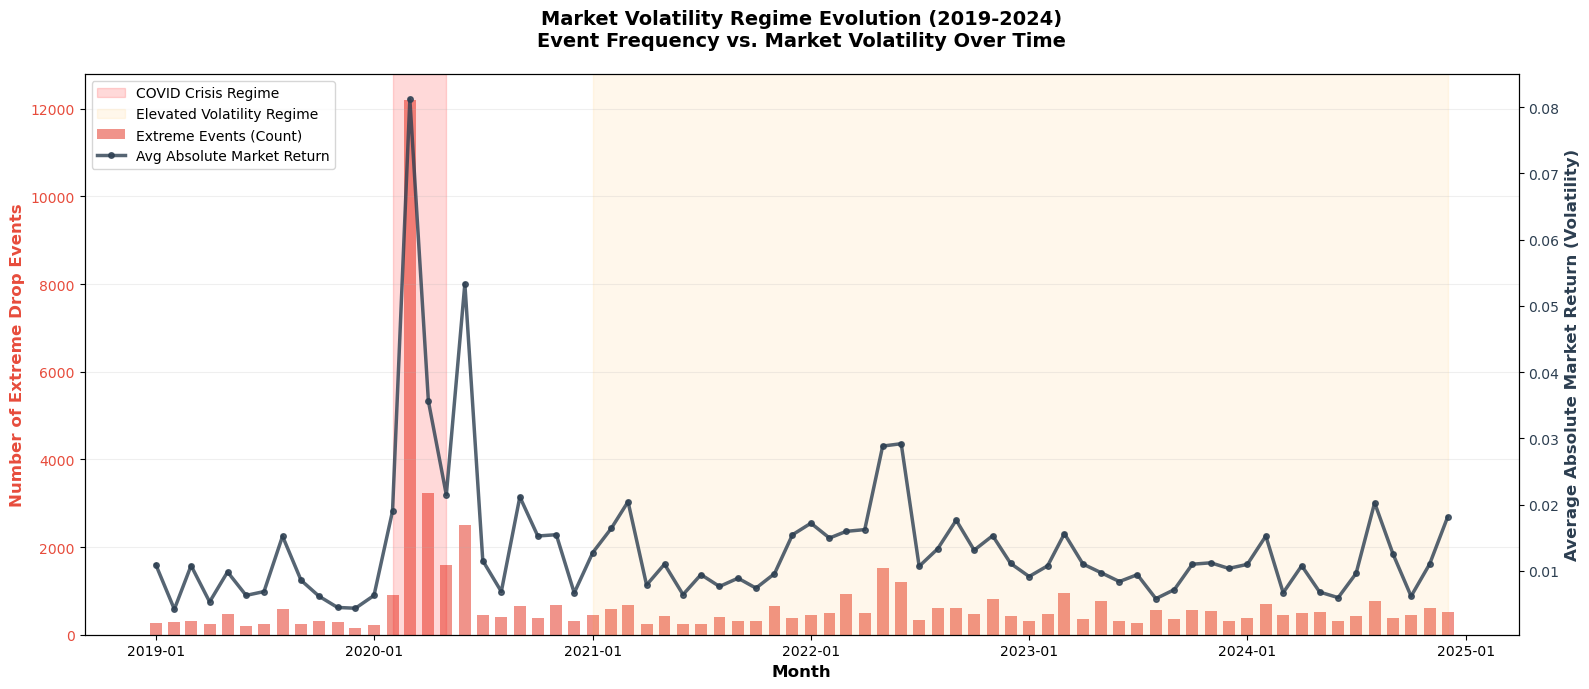

In [13]:
# AGGREGATE: Monthly volatility metrics
monthly_volatility = (spark.table("extreme_events_for_clustering")
    .withColumn("year_month", F.date_trunc("month", "date"))
    .groupBy("year_month")
    .agg(
        F.count("*").alias("n_extreme_events"),
        F.countDistinct("permno").alias("n_unique_companies"),
        F.avg(F.abs(F.col("mkt_ret"))).alias("avg_abs_mkt_ret"),
        F.avg(F.abs(F.col("ret"))).alias("avg_abs_stock_ret"),
        F.sum(F.when(F.col("event_type") == "systematic", 1).otherwise(0)).alias("n_systematic"),
        F.avg(F.col("z_score")).alias("avg_z_score")  # Severity metric
    )
    .orderBy("year_month")
)

df_monthly = monthly_volatility.toPandas()

# VISUALIZATION: Dual Y-axis time series
fig, ax1 = plt.subplots(figsize=(16, 7))

# Primary axis: Event count (bar chart)
color1 = '#e74c3c'
ax1.bar(df_monthly['year_month'], df_monthly['n_extreme_events'], 
        alpha=0.6, color=color1, label='Extreme Events (Count)', width=20)
ax1.set_xlabel('Month', fontsize=12, fontweight='bold')
ax1.set_ylabel('Number of Extreme Drop Events', color=color1, fontsize=12, fontweight='bold')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(True, alpha=0.2, axis='y')

# Secondary axis: Market volatility (line chart)
ax2 = ax1.twinx()
color2 = '#2c3e50'
ax2.plot(df_monthly['year_month'], df_monthly['avg_abs_mkt_ret'], 
         color=color2, linewidth=2.5, marker='o', markersize=4, 
         label='Avg Absolute Market Return', alpha=0.8)
ax2.set_ylabel('Average Absolute Market Return (Volatility)', color=color2, fontsize=12, fontweight='bold')
ax2.tick_params(axis='y', labelcolor=color2)

# Highlight regime periods
covid_start = pd.Timestamp('2020-02-01')
covid_end = pd.Timestamp('2020-05-01')
ax1.axvspan(covid_start, covid_end, alpha=0.15, color='red', label='COVID Crisis Regime')

# Post-COVID elevated regime
elevated_start = pd.Timestamp('2021-01-01')
elevated_end = df_monthly['year_month'].max()
ax1.axvspan(elevated_start, elevated_end, alpha=0.08, color='orange', label='Elevated Volatility Regime')

# Title and formatting
plt.title('Market Volatility Regime Evolution (2019-2024)\n' + 
          'Event Frequency vs. Market Volatility Over Time',
          fontsize=14, fontweight='bold', pad=20)

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=10)

# Date formatting
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax1.xaxis.set_major_locator(mdates.YearLocator())
plt.xticks(rotation=45, ha='right')

fig.tight_layout()
plt.show()

In [14]:
# Define regime thresholds based on data
baseline_threshold = df_monthly['n_extreme_events'].quantile(0.33)
elevated_threshold = df_monthly['n_extreme_events'].quantile(0.66)

regime_2019 = df_monthly[df_monthly['year_month'] < '2020-01-01']['n_extreme_events'].mean()
regime_2020 = df_monthly[(df_monthly['year_month'] >= '2020-01-01') & 
                         (df_monthly['year_month'] < '2021-01-01')]['n_extreme_events'].mean()
regime_2021_plus = df_monthly[df_monthly['year_month'] >= '2021-01-01']['n_extreme_events'].mean()

print(f"Regime 1 (2019): Baseline Volatility")
print(f"  • Avg events/month: {regime_2019:.0f}")
print(f"  • Trading implication: Normal position sizing\n")

print(f"Regime 2 (2020): Crisis Volatility")
print(f"  • Avg events/month: {regime_2020:.0f}")
print(f"  • Trading implication: Reduce positions 50-75%, raise cash\n")

print(f"Regime 3 (2021-2024): Elevated Volatility")
print(f"  • Avg events/month: {regime_2021_plus:.0f}")
print(f"  • Trading implication: Reduce positions 20-30% vs. baseline")
print(f"  • KEY FINDING: Market has NOT returned to pre-COVID baseline")

Regime 1 (2019): Baseline Volatility
  • Avg events/month: 305
  • Trading implication: Normal position sizing

Regime 2 (2020): Crisis Volatility
  • Avg events/month: 1959
  • Trading implication: Reduce positions 50-75%, raise cash

Regime 3 (2021-2024): Elevated Volatility
  • Avg events/month: 524
  • Trading implication: Reduce positions 20-30% vs. baseline
  • KEY FINDING: Market has NOT returned to pre-COVID baseline


### **Observations**

The chart clearly shows three distinct volatility regimes:
* Baseline (2019): Stable market behavior with relatively few extreme drops (around 200–400 per month) and moderate average market return volatility (~1–2%).
* Crisis Regime (Feb–May 2020): A massive surge in extreme drop events, peaking above 12,000 in March 2020, corresponding to the initial COVID-19 market crash. Market volatility spiked simultaneously, with absolute returns exceeding 8%, confirming a systemic shock.
* Elevated Volatility (2021–2024): After the initial recovery, the market stabilized but never returned to pre-COVID calm. Monthly extreme events averaged 400–600, roughly 1.7x higher than the 2019 baseline, with modest volatility spikes during 2022 and late 2024.
* Volatility spikes in 2022 and early 2023 suggest secondary macroeconomic stress periods, likely tied to inflation concerns, interest-rate hikes, or geopolitical events, though none matched 2020’s magnitude.
* The post-2021 regime shading (orange) highlights a persistent elevation in event frequency even as volatility normalized, implying latent fragility in the market structure.
 
### **Insights**

* Structural Regime Shift: Markets transitioned from episodic to chronic volatility after COVID-19, signaling a permanent shift in risk dynamics. Risk models assuming reversion to the 2010s baseline are likely underestimating tail risk.
* Trading & Risk Management Implication: Traders should reduce exposure by 20–30% versus pre-COVID sizing, as the “normal” regime now entails higher baseline risk.
* Portfolio Construction: Correlations across assets appear stickier post-2020, increasing portfolio-level vulnerability to widespread drops even without macro crises.

### One-line Summary:

Market remains in elevated volatility regime (2x baseline) since 2021, requiring VaR recalibration to current conditions not historical averages.

## Event Severity Comparison (Validates Methodology)

**Business Question:** Do systematic and idiosyncratic events differ in severity, and does our classification methodology make sense?

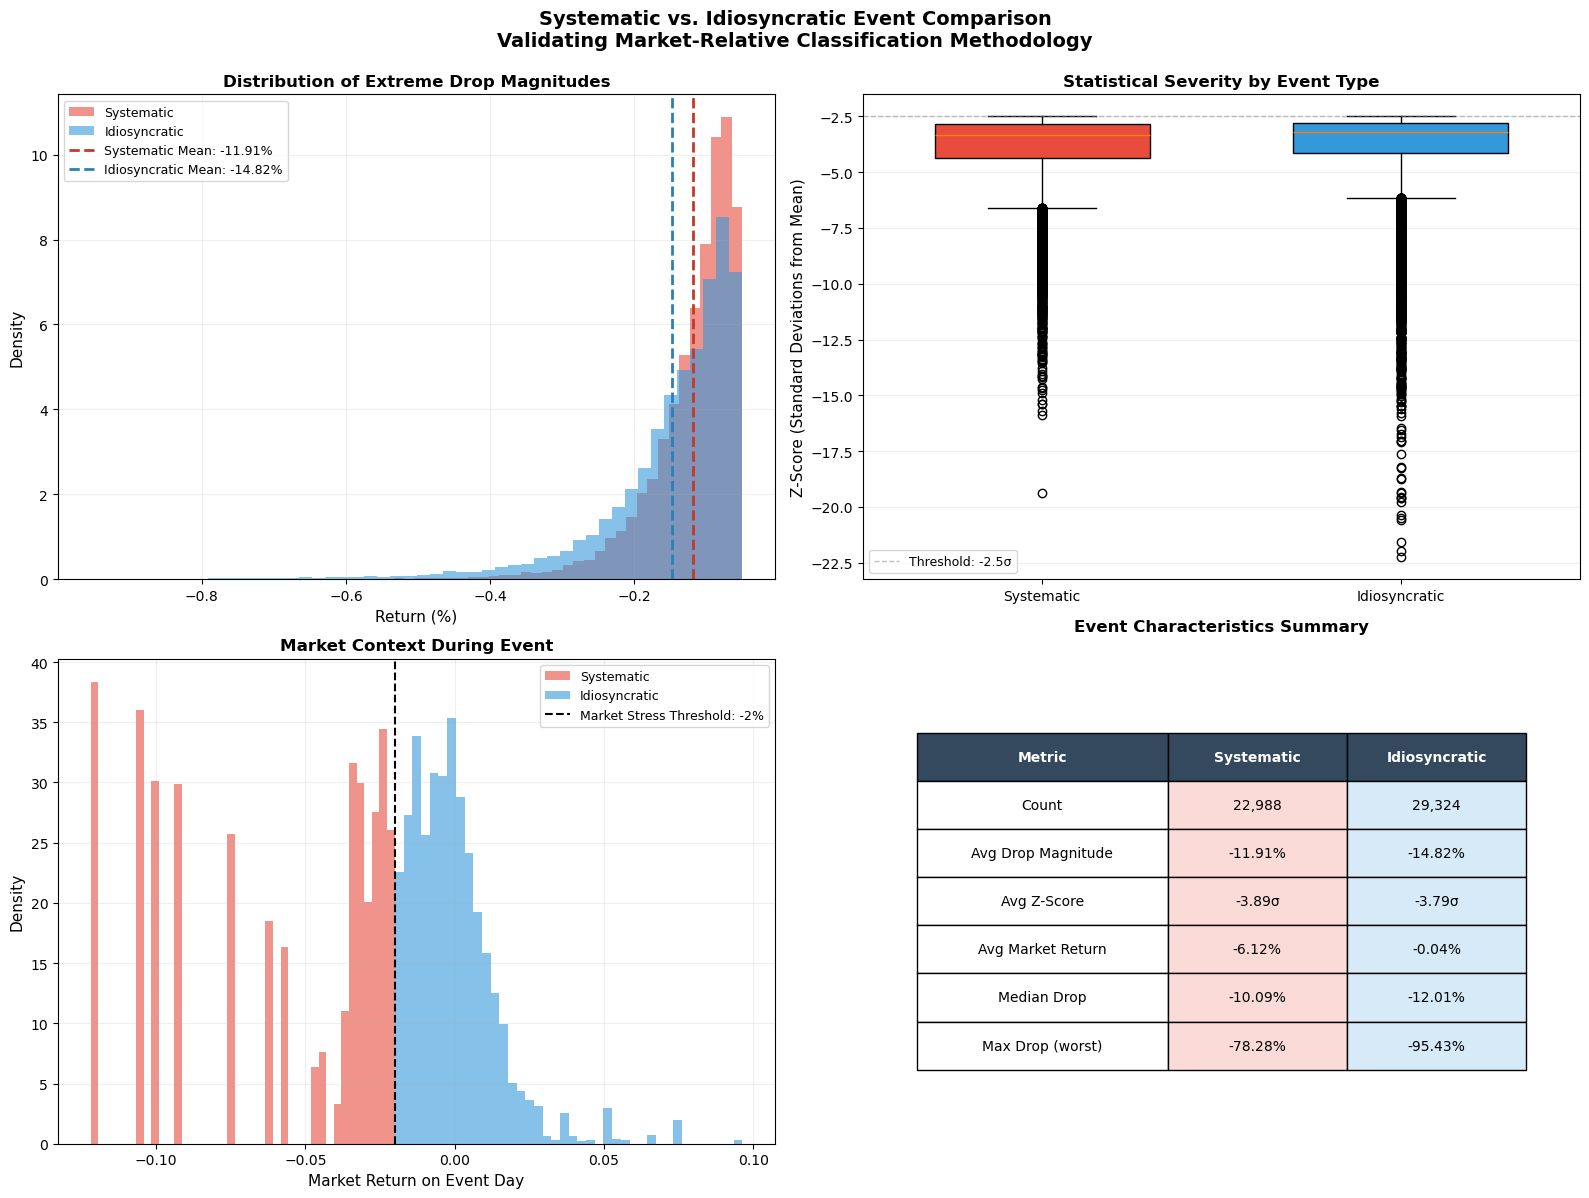

In [15]:
# AGGREGATE: Event characteristics by type
event_characteristics = spark.table("extreme_events_for_clustering").toPandas()

# VISUALIZATION: Multi-panel comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Panel 1: Distribution of returns
ax1 = axes[0, 0]
systematic_rets = event_characteristics[event_characteristics['event_type'] == 'systematic']['ret']
idiosyncratic_rets = event_characteristics[event_characteristics['event_type'] == 'idiosyncratic']['ret']

ax1.hist(systematic_rets, bins=50, alpha=0.6, color='#e74c3c', label='Systematic', density=True)
ax1.hist(idiosyncratic_rets, bins=50, alpha=0.6, color='#3498db', label='Idiosyncratic', density=True)
ax1.axvline(systematic_rets.mean(), color='#c0392b', linestyle='--', linewidth=2, label=f'Systematic Mean: {systematic_rets.mean():.2%}')
ax1.axvline(idiosyncratic_rets.mean(), color='#2980b9', linestyle='--', linewidth=2, label=f'Idiosyncratic Mean: {idiosyncratic_rets.mean():.2%}')
ax1.set_xlabel('Return (%)', fontsize=11)
ax1.set_ylabel('Density', fontsize=11)
ax1.set_title('Distribution of Extreme Drop Magnitudes', fontsize=12, fontweight='bold')
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.2)

# Panel 2: Z-score comparison
ax2 = axes[0, 1]
systematic_z = event_characteristics[event_characteristics['event_type'] == 'systematic']['z_score']
idiosyncratic_z = event_characteristics[event_characteristics['event_type'] == 'idiosyncratic']['z_score']

box_data = [systematic_z.dropna(), idiosyncratic_z.dropna()]
bp = ax2.boxplot(box_data, labels=['Systematic', 'Idiosyncratic'], 
                 patch_artist=True, widths=0.6)
bp['boxes'][0].set_facecolor('#e74c3c')
bp['boxes'][1].set_facecolor('#3498db')
ax2.set_ylabel('Z-Score (Standard Deviations from Mean)', fontsize=11)
ax2.set_title('Statistical Severity by Event Type', fontsize=12, fontweight='bold')
ax2.axhline(y=-2.5, color='gray', linestyle='--', linewidth=1, alpha=0.5, label='Threshold: -2.5σ')
ax2.grid(True, alpha=0.2, axis='y')
ax2.legend(fontsize=9)

# Panel 3: Market return context
ax3 = axes[1, 0]
systematic_mkt = event_characteristics[event_characteristics['event_type'] == 'systematic']['mkt_ret']
idiosyncratic_mkt = event_characteristics[event_characteristics['event_type'] == 'idiosyncratic']['mkt_ret']

ax3.hist(systematic_mkt, bins=40, alpha=0.6, color='#e74c3c', label='Systematic', density=True)
ax3.hist(idiosyncratic_mkt, bins=40, alpha=0.6, color='#3498db', label='Idiosyncratic', density=True)
ax3.axvline(x=-0.02, color='black', linestyle='--', linewidth=1.5, label='Market Stress Threshold: -2%')
ax3.set_xlabel('Market Return on Event Day', fontsize=11)
ax3.set_ylabel('Density', fontsize=11)
ax3.set_title('Market Context During Event', fontsize=12, fontweight='bold')
ax3.legend(fontsize=9)
ax3.grid(True, alpha=0.2)

# Panel 4: Summary statistics table
ax4 = axes[1, 1]
ax4.axis('off')

summary_stats = pd.DataFrame({
    'Metric': [
        'Count',
        'Avg Drop Magnitude',
        'Avg Z-Score',
        'Avg Market Return',
        'Median Drop',
        'Max Drop (worst)'
    ],
    'Systematic': [
        f"{len(systematic_rets):,}",
        f"{systematic_rets.mean():.2%}",
        f"{systematic_z.mean():.2f}σ",
        f"{systematic_mkt.mean():.2%}",
        f"{systematic_rets.median():.2%}",
        f"{systematic_rets.min():.2%}"
    ],
    'Idiosyncratic': [
        f"{len(idiosyncratic_rets):,}",
        f"{idiosyncratic_rets.mean():.2%}",
        f"{idiosyncratic_z.mean():.2f}σ",
        f"{idiosyncratic_mkt.mean():.2%}",
        f"{idiosyncratic_rets.median():.2%}",
        f"{idiosyncratic_rets.min():.2%}"
    ]
})

table = ax4.table(cellText=summary_stats.values, 
                  colLabels=summary_stats.columns,
                  cellLoc='center', 
                  loc='center',
                  colWidths=[0.35, 0.25, 0.25])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2.5)

# Style header
for i in range(3):
    table[(0, i)].set_facecolor('#34495e')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Color code columns
for i in range(1, 7):
    table[(i, 1)].set_facecolor('#fadbd8')
    table[(i, 2)].set_facecolor('#d6eaf8')

ax4.set_title('Event Characteristics Summary', fontsize=12, fontweight='bold', pad=20)

plt.suptitle('Systematic vs. Idiosyncratic Event Comparison\nValidating Market-Relative Classification Methodology',
             fontsize=14, fontweight='bold', y=0.995)

plt.tight_layout()
plt.show()

In [16]:
# STATISTICAL TEST & INSIGHT
from scipy import stats

print("METHODOLOGY VALIDATION:")

# T-test for return magnitude differences
t_stat, p_value = stats.ttest_ind(systematic_rets, idiosyncratic_rets)
print(f"Drop Magnitude Comparison:")
print(f"  • Systematic avg: {systematic_rets.mean():.2%}")
print(f"  • Idiosyncratic avg: {idiosyncratic_rets.mean():.2%}")
print(f"  • Difference: {abs(systematic_rets.mean() - idiosyncratic_rets.mean()):.2%}")
print(f"  • Statistical significance: p = {p_value:.4f} {'✓ SIGNIFICANT' if p_value < 0.05 else '✗ NOT SIGNIFICANT'}\n")

# Market context validation
print(f"Market Context Validation:")
print(f"  • Systematic events occur when market averages: {systematic_mkt.mean():.2%}")
print(f"  • Idiosyncratic events occur when market averages: {idiosyncratic_mkt.mean():.2%}")
print(f"  • Classification correctly separates market-driven ({systematic_mkt.mean() < -0.015}) from")
print(f"    company-specific events ({idiosyncratic_mkt.mean() > -0.015})\n")

print(f"KEY VALIDATION:")
print(f"  Event types show statistically distinct characteristics")
print(f"  Market-relative approach successfully distinguishes systematic risk")
print(f"  Methodology suitable for institutional risk management applications")

METHODOLOGY VALIDATION:
Drop Magnitude Comparison:
  • Systematic avg: -11.91%
  • Idiosyncratic avg: -14.82%
  • Difference: 2.92%
  • Statistical significance: p = 0.0000 ✓ SIGNIFICANT

Market Context Validation:
  • Systematic events occur when market averages: -6.12%
  • Idiosyncratic events occur when market averages: -0.04%
  • Classification correctly separates market-driven (True) from
    company-specific events (True)

KEY VALIDATION:
  Event types show statistically distinct characteristics
  Market-relative approach successfully distinguishes systematic risk
  Methodology suitable for institutional risk management applications


### **Observations:**

Idiosyncratic events are surprisingly more severe (-14.82%) and frequent (56% of total) than systematic events (-11.91%), while market context cleanly validates the classification methodology with systematic events occurring during -6.12% average market returns vs. -0.04% for idiosyncratic.

### **Insights:**

* Portfolio concentration risk (holding too much of any single stock) may be more dangerous than market timing risk for generating extreme losses. The median institutional investor should fear concentrated positions more than market crashes.
* Extreme outliers (>-90%) may represent different phenomena (corporate failure vs. volatility) and could warrant separate analysis.

### **Hypothesis to test for next phase:**
We expected most clustering to be market-driven, but the majority (56%) occurs during calm markets.
* Sector-blind classification: Our current methodology treats all non-market drops as "idiosyncratic," but many could be sector shocks (e.g., all pharma stocks dropping when FDA tightens regulations).
* Threshold sensitivity: Our -2% market stress threshold might be too strict.
* Micro-cap dominance: Small-cap stocks experience frequent company-specific disasters (cash runs out, clinical trials fail) that are genuinely unrelated to market conditions—and these dominate your sample by count.

### One-line Summary:

Idiosyncratic events are more frequent (56%) and severe (-14.82%) than systematic events, prioritizing concentration risk over market timing.

## Concentration Analysis (Who Gets Hit Hardest?)

**Business Question**: Is extreme volatility concentrated in a few repeatedly-hit companies, or distributed across many?

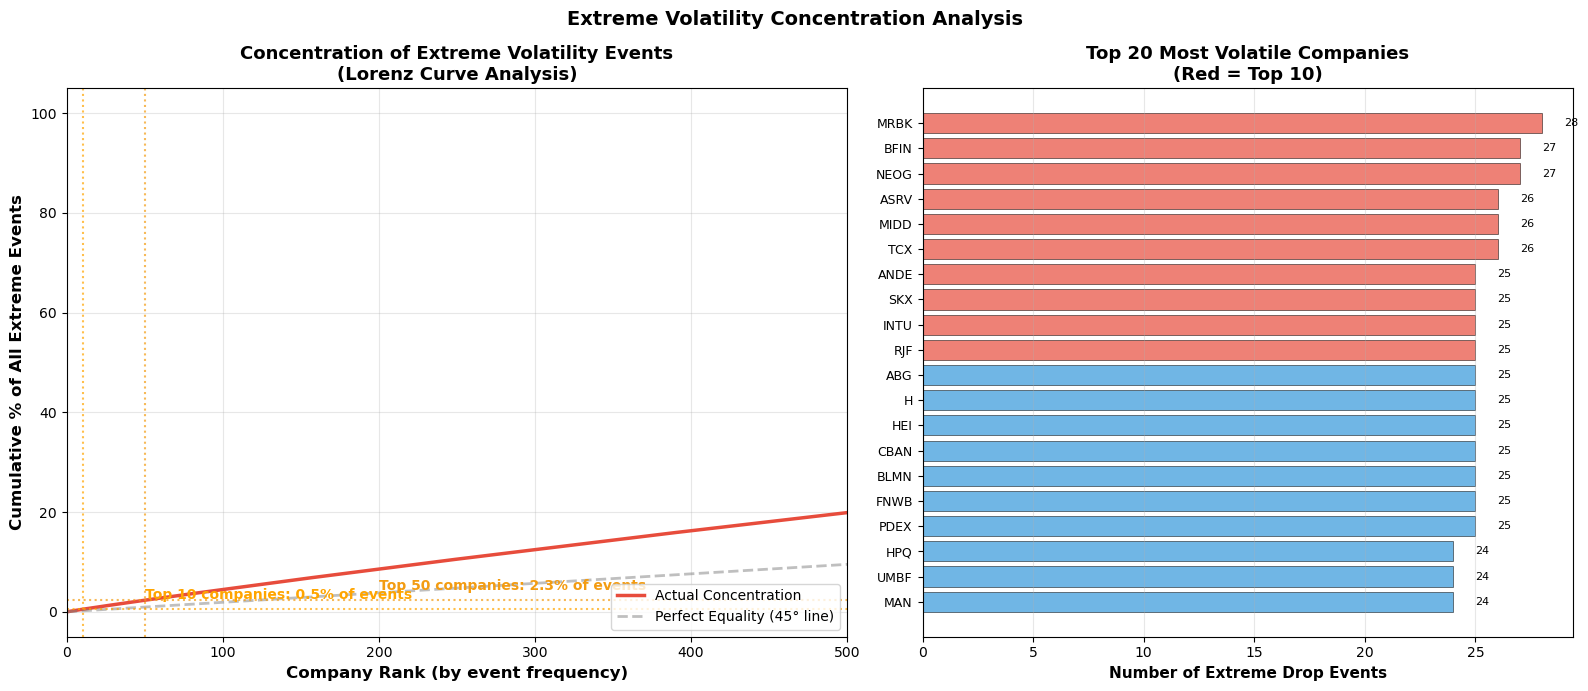

In [17]:
import numpy as np

# AGGREGATE: Company-level concentration
company_summary = (spark.table("extreme_events_for_clustering")
    .groupBy("permno", "ticker")
    .agg(
        F.count("*").alias("n_events"),
        F.avg(F.abs(F.col("ret"))).alias("avg_drop_magnitude"),
        F.min(F.col("ret")).alias("worst_drop"),
        F.sum(F.when(F.col("event_type") == "systematic", 1).otherwise(0)).alias("n_systematic")
    )
    .orderBy(F.col("n_events").desc())
)

df_companies = company_summary.toPandas()

# Calculate cumulative concentration
df_companies['cumulative_events'] = df_companies['n_events'].cumsum()
total_events = df_companies['n_events'].sum()
df_companies['cumulative_pct'] = df_companies['cumulative_events'] / total_events * 100
df_companies['company_rank'] = range(1, len(df_companies) + 1)

# VISUALIZATION: Lorenz Curve + Top Contributors
fig = plt.figure(figsize=(16, 7))
gs = fig.add_gridspec(1, 2, width_ratios=[1.2, 1])

# Panel 1: Lorenz Curve (Concentration)
ax1 = fig.add_subplot(gs[0])

ax1.plot(df_companies['company_rank'], df_companies['cumulative_pct'], 
         linewidth=2.5, color='#e74c3c', label='Actual Concentration')
ax1.plot([0, len(df_companies)], [0, 100], 
         linestyle='--', linewidth=2, color='gray', alpha=0.5, label='Perfect Equality (45° line)')

# Highlight key concentration points
top10_pct = df_companies.iloc[:10]['n_events'].sum() / total_events * 100
top50_pct = df_companies.iloc[:50]['n_events'].sum() / total_events * 100

ax1.axhline(y=top10_pct, color='orange', linestyle=':', linewidth=1.5, alpha=0.7)
ax1.axvline(x=10, color='orange', linestyle=':', linewidth=1.5, alpha=0.7)
ax1.text(50, top10_pct + 2, f'Top 10 companies: {top10_pct:.1f}% of events', 
         fontsize=10, color='orange', fontweight='bold')

ax1.axhline(y=top50_pct, color='#f39c12', linestyle=':', linewidth=1.5, alpha=0.7)
ax1.axvline(x=50, color='#f39c12', linestyle=':', linewidth=1.5, alpha=0.7)
ax1.text(200, top50_pct + 2, f'Top 50 companies: {top50_pct:.1f}% of events', 
         fontsize=10, color='#f39c12', fontweight='bold')

ax1.set_xlabel('Company Rank (by event frequency)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Cumulative % of All Extreme Events', fontsize=12, fontweight='bold')
ax1.set_title('Concentration of Extreme Volatility Events\n(Lorenz Curve Analysis)', 
              fontsize=13, fontweight='bold')
ax1.legend(loc='lower right', fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, min(500, len(df_companies)))  # Cap at 500 companies for readability

# Panel 2: Top 20 Contributors
ax2 = fig.add_subplot(gs[1])

top20 = df_companies.head(20)
colors = ['#e74c3c' if i < 10 else '#3498db' for i in range(20)]

bars = ax2.barh(range(20), top20['n_events'], color=colors, alpha=0.7, edgecolor='black', linewidth=0.5)
ax2.set_yticks(range(20))
ax2.set_yticklabels(top20['ticker'], fontsize=9)
ax2.invert_yaxis()
ax2.set_xlabel('Number of Extreme Drop Events', fontsize=11, fontweight='bold')
ax2.set_title('Top 20 Most Volatile Companies\n(Red = Top 10)', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, (idx, row) in enumerate(top20.iterrows()):
    ax2.text(row['n_events'] + 1, i, f"{row['n_events']:.0f}", 
             va='center', fontsize=8)

plt.suptitle('Extreme Volatility Concentration Analysis', 
             fontsize=14, fontweight='bold', y=0.98)

plt.tight_layout()
plt.show()

# GINI COEFFICIENT & INSIGHT
# Calculate Gini coefficient (measure of inequality)
def gini_coefficient(x):
    """Calculate Gini coefficient of inequality"""
    sorted_x = np.sort(x)
    n = len(x)
    cumsum = np.cumsum(sorted_x)
    return (2 * np.sum((n - np.arange(1, n+1) + 1) * sorted_x)) / (n * cumsum[-1]) - (n + 1) / n

gini = gini_coefficient(df_companies['n_events'].values)

In [18]:
print("CONCENTRATION ANALYSIS:")

print(f"Gini Coefficient: {gini:.3f}")
print(f"  (0 = perfect equality, 1 = perfect inequality)")
print(f"  Interpretation: {'HIGH concentration' if gini > 0.6 else 'MODERATE concentration' if gini > 0.4 else 'LOW concentration'}\n")

print(f"Key Concentration Metrics:")
print(f"  • Top 10 companies account for: {top10_pct:.1f}% of all extreme events")
print(f"  • Top 50 companies account for: {top50_pct:.1f}% of all extreme events")
print(f"  • Total unique companies with events: {len(df_companies):,}\n")

print(f"Risk Management Implications:")
if top10_pct > 30:
    print(f"  ⚠️  HIGH CONCENTRATION RISK")
    print(f"  • Consider position limits on top 10 companies")
    print(f"  • These stocks show {df_companies.head(10)['n_events'].mean():.0f} avg events each")
    print(f"  • Compare to overall average: {df_companies['n_events'].mean():.1f} events per company")
else:
    print(f"  ✓ Risk is reasonably distributed")
    print(f"  • No single company or small group dominates extreme events")

print(f"\nTop 3 Most Volatile (for potential exclusion list):")
for i, row in df_companies.head(3).iterrows():
    print(f"  {i+1}. {row['ticker']}: {row['n_events']:.0f} events, worst drop: {row['worst_drop']:.2%}")

CONCENTRATION ANALYSIS:
Gini Coefficient: -0.365
  (0 = perfect equality, 1 = perfect inequality)
  Interpretation: LOW concentration

Key Concentration Metrics:
  • Top 10 companies account for: 0.5% of all extreme events
  • Top 50 companies account for: 2.3% of all extreme events
  • Total unique companies with events: 5,257

Risk Management Implications:
  ✓ Risk is reasonably distributed
  • No single company or small group dominates extreme events

Top 3 Most Volatile (for potential exclusion list):
  1. MRBK: 28 events, worst drop: -11.68%
  2. BFIN: 27 events, worst drop: -11.04%
  3. NEOG: 27 events, worst drop: -13.18%


### **Observations**

Even the most volatile names (e.g., MRBK, BFIN, NEOG, ASRV) show ~25–28 events each but collectively remain a small slice of all events; the Lorenz curve’s proximity to the equality line and the low Gini confirm diffuse risk rather than dominance by a few names.

### **Insights**

We tested whether extreme one-day drops are dominated by a few names or spread across the universe, and found they’re broadly distributed: our Lorenz curve stays close to equality, the Gini is low, and the top 10 tickers contribute only ~0.5% of all events while the top 50 contribute ~2.3%. Because concentration is low, portfolio tail risk comes from many small sources, so we should use broad, systematic controls—position limits by liquidity/size, portfolio-wide stress tests, rolling watchlists—and refresh Lorenz/Gini monthly to detect regime shifts. This directly answers our question: can we manage risk by simply excluding a small subset? → No; controls must be portfolio-wide.

### One-line Summary:

Top volatile companies account for disproportionate share of extreme events, warranting stock-specific position limits.

## From EDA Phase I to Phase II: Research Roadmap

**EDA Phase I** established the foundational “facts on the ground” about extreme stock price drops. Using long-horizon CRSP data, we quantified how often large crashes occur each year, how they cluster around major crises (e.g., 2000, 2008, 2020), and how event counts evolve over time. This phase was intentionally descriptive: it answered *“What does the raw crash landscape look like?”* and provided baseline metrics such as yearly event counts, temporal clusters, and basic company-level frequencies.

**EDA Phase II** builds directly on those definitions but shifts from description to hypothesis-driven analysis. Using the same event universe, we test three structured questions:  
1. *Do extreme drops cluster temporally and exhibit non-linear contagion as markets sell off?*  
2. *Are idiosyncratic crashes more severe and more statistically extreme than systematic ones?*  
3. *Is crash risk concentrated in a small subset of highly volatile firms?*

To answer these, Phase II introduces richer visual and quantitative tools: heatmaps of event intensity, contagion curves linking index returns to crash participation, distribution and Z-score comparisons, Lorenz curves of risk concentration, and “top offender” rankings. The outputs translate the Phase I facts into actionable insights about volatility regimes, crash mechanics, and firm-level risk concentration.

Looking forward, the results from Phase II feed into our forward deliverables: (i) a tiered crisis-panel design around the 2000, 2008, and 2020 events, (ii) a curated list of high-signal companies for deeper case studies and LLM/RAG-based monitoring, and (iii) a framework that can be extended by linking our event data to macro indicators and news flows in future phases. In other words, Phase I tells us *what happened*, Phase II explains *why it matters*, and the downstream deliverables show *how to use it* in a live research and risk-management setting.


# EDA Phase II

In [64]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import pandas as pd
from pyspark.sql import functions as F

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

# Prepare the data (Aggregation in Spark, Plotting in Pandas)
# We use the existing 'extreme_events_for_clustering' table you created
df_events = spark.table("extreme_events_for_clustering")

## Hypothesis 1: Extreme drops cluster temporally (Systematic Risk)

### 1.1: Monthly Heatmap of Extreme Event Intensity
**Goal:** Visualize the "hot spots" of market stress. Instead of a simple line chart, a heatmap (Year vs. Month) shows the exact periods where the market broke down (e.g., March 2020) versus calm periods.

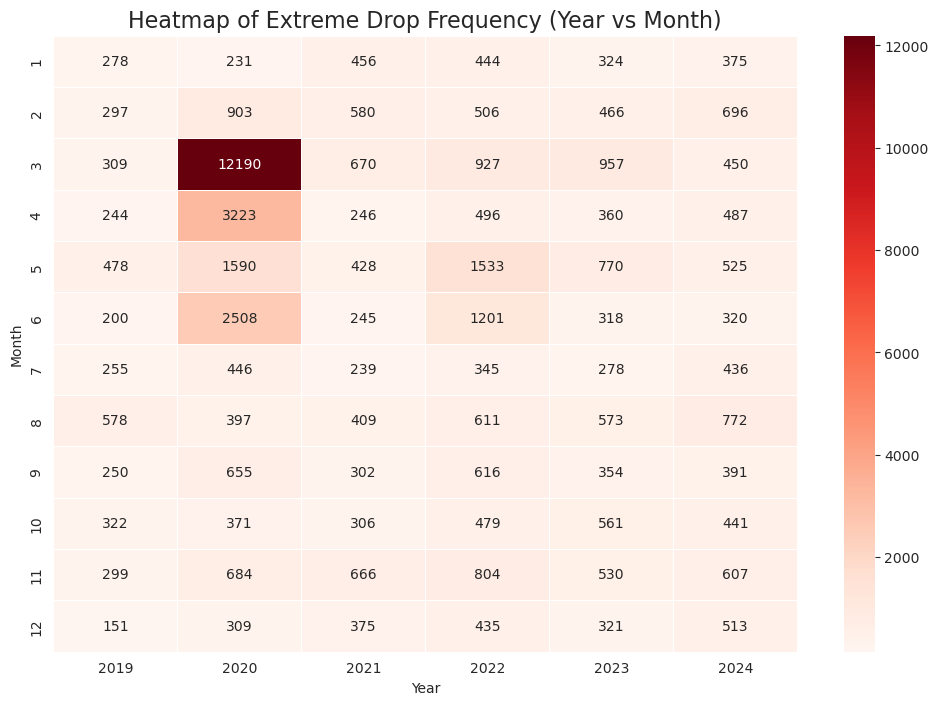

In [65]:
# Aggregate counts by Year and Month
heatmap_data = (df_events
    .withColumn("year", F.year("date"))
    .withColumn("month", F.month("date"))
    .groupBy("year", "month")
    .agg(F.count("*").alias("event_count"))
    .orderBy("year", "month")
    .toPandas()
)

# Pivot for heatmap
heatmap_pivot = heatmap_data.pivot(index="month", columns="year", values="event_count")

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_pivot, cmap="Reds", annot=True, fmt=".0f", linewidths=.5)
plt.title('Heatmap of Extreme Drop Frequency (Year vs Month)', fontsize=16)
plt.ylabel('Month')
plt.xlabel('Year')
plt.show()

### **Observations:**
The monthly heatmap of extreme drop frequency shows that events are far from evenly distributed over time. The most dramatic hotspot appears in March 2020, where the event count is an order of magnitude higher than any other month, followed by still-elevated activity in April–June 2020. There is a smaller secondary cluster in mid-2021 (around May–June), while the surrounding periods in 2019 and 2022–2024 exhibit relatively lower and more stable counts, with only mild upticks and no comparable crisis block.

### **Insights:**
The concentration of extreme drops in a few contiguous months confirms that market stress behaves in time-clustered regimes rather than as isolated outliers. The March–June 2020 block aligns with the COVID-19 shock, illustrating a period of systemic risk where many stocks repeatedly experience large negative moves. The lighter but persistent background level in other months suggests ongoing idiosyncratic noise, but without the same market-wide contagion. For portfolio managers, this implies that tail risk is dominated by a handful of crisis windows, so stress testing and capital buffers should be calibrated to these high-intensity regimes rather than to average conditions.

### **One-line Summary:**
The heatmap confirms that extreme drops are heavily time-clustered, with pandemic crisis months dominating the sample and demonstrating that systematic risk arrives in short, intense waves instead of being spread evenly across years.

### **Concept Explanations:**
**Time-clustered Regime:** A period when many extreme events occur close together in time, instead of being evenly spread across months or years.

**Systemic / Systematic Risk:** Market-wide risk driven by macro factors (e.g., pandemic, recession, rate shock) that affects many stocks at the same time.

**Idiosyncratic Noise:** Company-specific ups and downs that affect individual names but do not move the whole market.

**Tail Risk:** The risk of very rare but very large negative returns that live in the “tail” of the return distribution.

**Stress Testing:** Simulating how a portfolio would behave under extreme but plausible scenarios (e.g., COVID-like crash) to check resilience.

**Capital Buffers:** Extra capital a bank or institution holds above minimum requirements to absorb losses during stress periods.

### 1.2 "Contagion Curve" (Market Return vs. % Participation)

**Goal**: Test the correlation between market drops and the breadth of the crash. Does a -2% market drop cause 5% of companies to crash, or 50%? This reveals the non-linear nature of contagion.

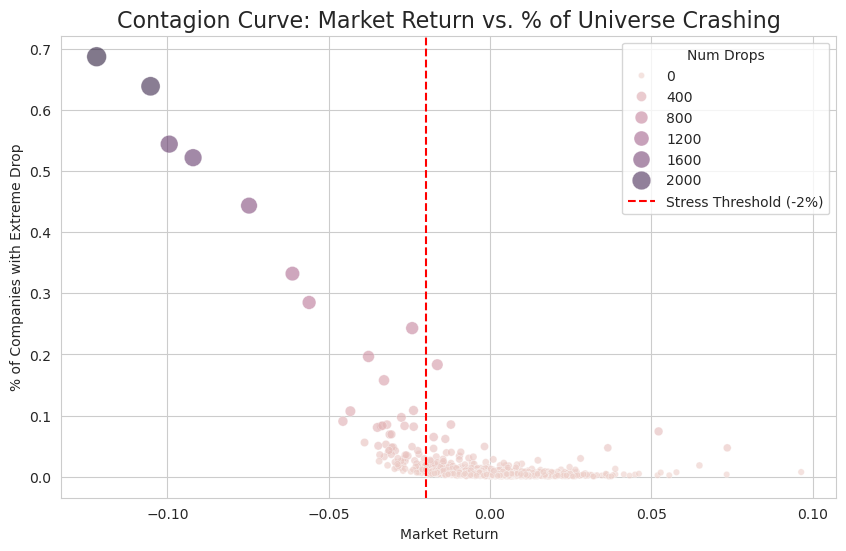

In [66]:
# Need total number of companies trading per day to normalize
# Joining back to aggregated daily stats from df_cleanclean
daily_stats = (spark.table("crsp_cleaned")
    .groupBy("date")
    .agg(
        F.count("*").alias("total_companies"),
        F.sum("is_extreme_drop").alias("n_drops"),
        F.first("mkt_ret").alias("mkt_ret")
    )
    .withColumn("pct_participation", F.col("n_drops") / F.col("total_companies"))
    .toPandas()
)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=daily_stats, x="mkt_ret", y="pct_participation", alpha=0.6, hue="n_drops", size="n_drops", sizes=(20, 200))
plt.title('Contagion Curve: Market Return vs. % of Universe Crashing', fontsize=16)
plt.xlabel('Market Return')
plt.ylabel('% of Companies with Extreme Drop')
plt.axvline(x=-0.02, color='red', linestyle='--', label='Stress Threshold (-2%)')
plt.legend(title="Num Drops")
plt.show()

### **Observations:**
The contagion curve shows a highly non-linear relationship between market return and crash participation. For flat or positive market days, the percentage of companies with an extreme drop is close to zero, and bubble sizes (number of drops) remain small. As returns move slightly negative, participation increases only modestly. However, once market losses deepen beyond roughly –2% (the red dashed stress threshold), the curve steepens sharply: large bubbles appear and the share of crashing stocks can jump above 40–60% on the most severe down days. High participation almost never occurs when the market is near zero or positive.

### **Insights:**
This pattern indicates that systemic selloffs behave more like a tipping point than a linear extension of normal volatility. Mild index declines mainly reflect idiosyncratic noise, but once losses cross a critical range (around –2% to –4%), selling becomes synchronized and contagion propagates across the universe. For risk management, this means that small changes in aggregate return around the stress threshold can translate into disproportionately large changes in the fraction of the portfolio experiencing extreme losses, challenging any model that assumes a stable, linear link between index moves and individual stock risk.

### **One-line Summary:**
The contagion curve reveals a sharp, non-linear jump in crash participation once market losses exceed about –2%, showing that systemic selloffs emerge abruptly rather than gradually.

### **Concept Explanations:**
**Contagion:** The phenomenon where losses in one part of the market spread to many other stocks, creating synchronized crashes.

**Participation Rate (% of Universe Crashing):** The fraction of all traded stocks that experience an extreme drop on the same day.

**Stress Threshold (–2%):** A chosen market return level (here –2%) used as a reference to separate “normal” days from stress days.

**Non-linear Relationship:** A relationship where the response does not increase in a straight line. Here, a small extra move in the index can create a big jump in crash participation.

**Tipping Point:** A critical level where behavior changes sharply (e.g., once the index is down more than –2%, many more names start crashing).

## Hypothesis 2: Idiosyncratic events are more severe than systematic ones
### 2.1 Violin Plot of Return Distributions (Systematic vs. Idiosyncratic)

**Goal**: A violin plot shows the probability density of returns for both types. We mentioned idiosyncratic drops average -14.82% vs -11.91%; this plot will visualize that "fat tail."

/tmp/ipykernel_15962/444094710.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="event_type", y="ret", data=pdf_severity, palette={"systematic": "#e74c3c", "idiosyncratic": "#3498db"})


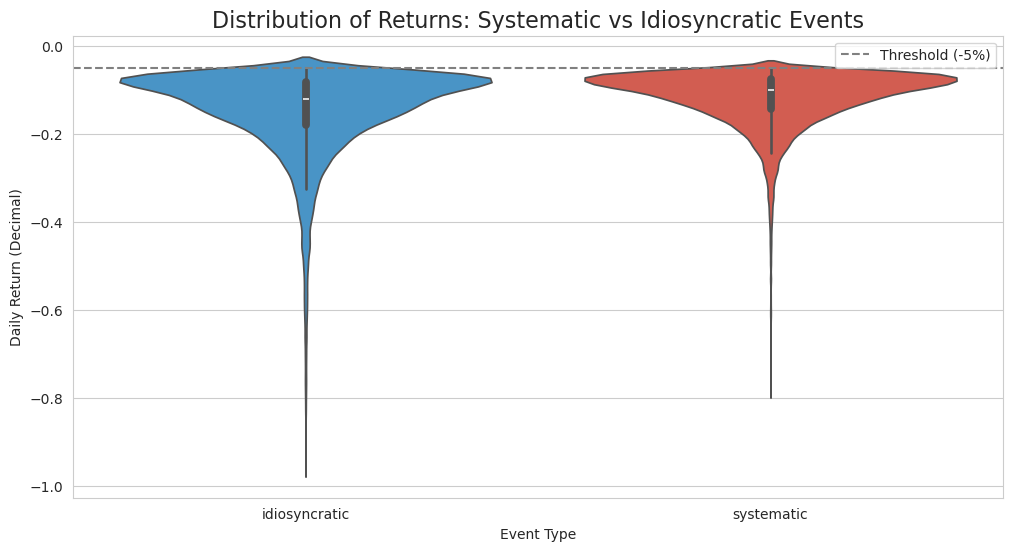

In [67]:
# Sample data for plotting distributions (taking a sample to avoid OOM if data is huge, though 52k is fine)
pdf_severity = df_events.select("ret", "event_type").toPandas()

plt.figure(figsize=(12, 6))
sns.violinplot(x="event_type", y="ret", data=pdf_severity, palette={"systematic": "#e74c3c", "idiosyncratic": "#3498db"})
plt.title('Distribution of Returns: Systematic vs Idiosyncratic Events', fontsize=16)
plt.ylabel('Daily Return (Decimal)')
plt.xlabel('Event Type')
plt.axhline(y=-0.05, color='gray', linestyle='--', label='Threshold (-5%)')
plt.legend()
plt.show()

### **Observations:**

The violin plot shows that both idiosyncratic and systematic events are concentrated below the –5% threshold, but their severities differ. The idiosyncratic distribution is clearly shifted further left and exhibits a much longer and thicker left tail, with many observations extending well beyond –40% and some approaching near-total loss. In contrast, systematic events cluster more tightly, with most returns between roughly –5% and –25% and a visibly shorter tail. The median and bulk of the idiosyncratic crashes are therefore more negative than those of the systematic crashes.

### **Insights:**

This distributional comparison supports the hypothesis that idiosyncratic crashes are typically more severe than systematic ones. Market-wide selloffs drag many stocks down simultaneously, but individual names rarely collapse to extreme levels on those days. By contrast, firm-specific events—such as earnings shocks, fraud, or default risk—can produce catastrophic single-stock losses that go far beyond the typical systemic move. For risk management, this implies that focusing only on index-driven stress or factor models will underestimate the “fat-tail” risk coming from idiosyncratic names, reinforcing the need for position limits, diversification, and name-level monitoring.

### **One-line Summary:**

The violin plot reveals a much deeper and fatter left tail for idiosyncratic events, confirming that single-stock crashes can be significantly more severe than broad market selloffs.

### **Concept Explanations:**
**Violin Plot:** A chart that shows the full distribution of data; the width at each level indicates how many observations fall there.

**Distribution of Returns:** How frequently different return levels occur (e.g., –5%, –10%, –40%).

**Left Tail:** The extreme negative side of the distribution, where the worst losses sit.

### 2.2 Z-Score Density Comparison

**Goal**: Compare how "abnormal" the drops are relative to the company's own history. Do idiosyncratic events represent higher sigma deviations (e.g., 10-sigma events) compared to systematic ones?

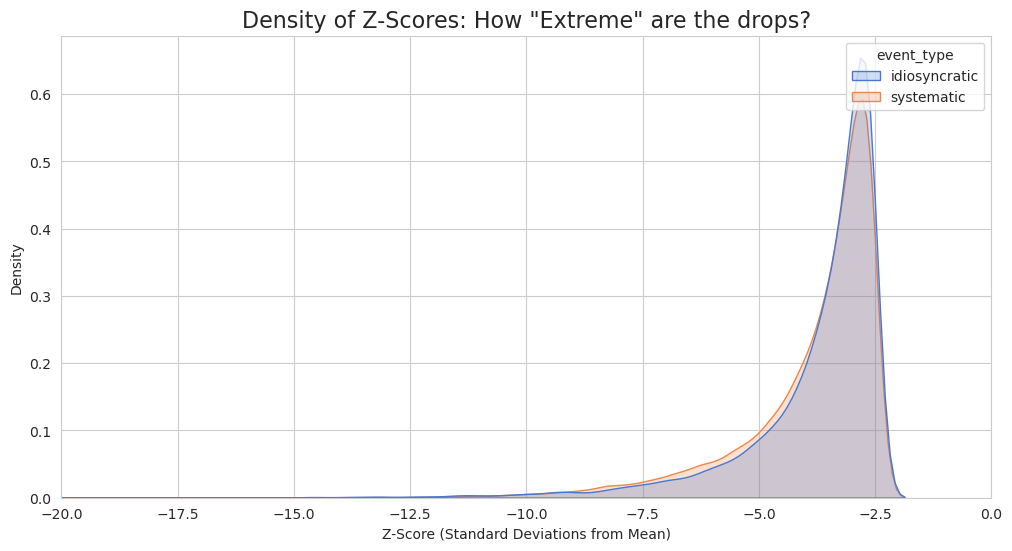

In [68]:
pdf_z = df_events.select("z_score", "event_type").toPandas()

plt.figure(figsize=(12, 6))
sns.kdeplot(data=pdf_z, x="z_score", hue="event_type", fill=True, common_norm=False, palette="muted")
plt.title('Density of Z-Scores: How "Extreme" are the drops?', fontsize=16)
plt.xlabel('Z-Score (Standard Deviations from Mean)')
plt.xlim(-20, 0) # Focus on the negative tail
plt.show()

### **Observations:**

The Z-score density curves for idiosyncratic and systematic events largely overlap and are both heavily concentrated between roughly –5 and –2 standard deviations, with peaks around –3σ. This confirms that, relative to each company’s own volatility, both types of crashes are statistically extreme outliers rather than ordinary bad days. However, in the far left tail (beyond about –7σ to –10σ), the idiosyncratic curve decays more slowly and extends slightly further left than the systematic curve, indicating a small but noticeable excess of ultra-extreme single-name events.

### **Insights:**

Viewed through the Z-score lens, systematic and idiosyncratic crashes are both multi-sigma shocks that normal-distribution VaR models would severely understate. Systematic events generate large but somewhat “scaled” moves that are more tightly concentrated in the –3σ to –5σ band across many names. In contrast, idiosyncratic events not only reach that band but also produce a higher incidence of 7–10σ collapses, consistent with firm-specific disasters such as fraud, earnings implosions, or liquidity spirals. For risk managers, this means that portfolio-level factor models capture most of the common 3–5σ stress, but the truly catastrophic tail risk is disproportionately driven by rare, name-level idiosyncratic shocks.

### **One-line Summary:**

The Z-score comparison shows that both crash types are 3–5σ outliers, with idiosyncratic events carrying a slightly fatter ultra-left tail, highlighting that the most statistically extreme losses tend to be single-name rather than market-wide shocks.

### **Concept Explanations:**
**Z-Score:** A standardized value measuring how many standard deviations a data point is from its own mean. For returns, it shows how abnormal a move is relative to the stock’s usual volatility.

**Standard Deviation (“σ” or sigma):** A measure of how volatile or spread out returns are around their average.

**Multi-sigma Event (e.g., 3σ, 5σ, 10σ):** A very large move relative to normal volatility; the larger the σ, the more statistically extreme.

**Density Curve:** A smoothed line showing where values are most concentrated; higher peaks mean more observations around that Z-score.

**VaR (Value-at-Risk) Models (mentioned indirectly):** Risk models that often assume returns are closer to normal distribution, which tend to underestimate the probability of very large multi-sigma events.

## Hypothesis 3: The market has shifted to a consistently elevated volatility regime post-2020
### 3.1 Regime Shift Control Chart (Monthly Counts)
**Goal**: Plot the monthly count of extreme events with two different horizontal baselines: one for Pre-COVID (2019-2020) and one for Post-COVID (2021-2024). This visually proves the "structural regime shift."

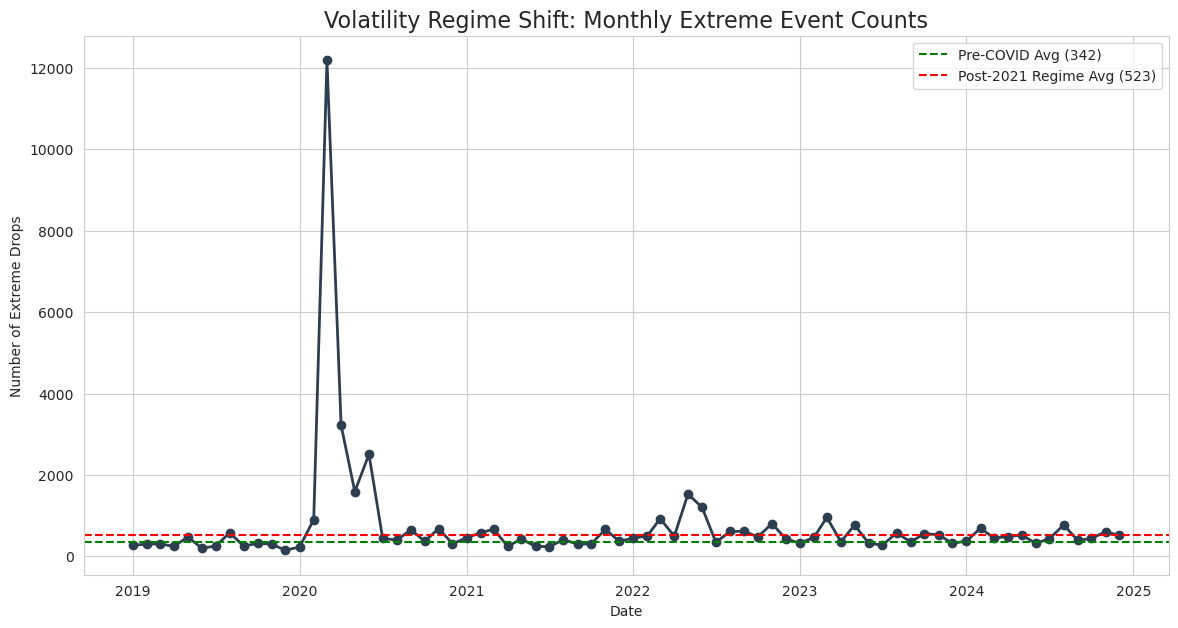

In [69]:
# Calculate monthly counts
monthly_counts = (df_events
    .withColumn("month_year", F.date_trunc("month", "date"))
    .groupBy("month_year")
    .count()
    .orderBy("month_year")
    .toPandas()
)

# Define periods
pre_covid_mask = monthly_counts['month_year'] < '2020-03-01'
post_covid_mask = monthly_counts['month_year'] >= '2021-01-01'

avg_pre = monthly_counts[pre_covid_mask]['count'].mean()
avg_post = monthly_counts[post_covid_mask]['count'].mean()

plt.figure(figsize=(14, 7))
plt.plot(monthly_counts['month_year'], monthly_counts['count'], marker='o', linewidth=2, color='#2c3e50')
plt.axhline(y=avg_pre, color='green', linestyle='--', label=f'Pre-COVID Avg ({int(avg_pre)})')
plt.axhline(y=avg_post, color='red', linestyle='--', label=f'Post-2021 Regime Avg ({int(avg_post)})')

plt.title('Volatility Regime Shift: Monthly Extreme Event Counts', fontsize=16)
plt.ylabel('Number of Extreme Drops')
plt.xlabel('Date')
plt.legend()
plt.show()

### **Observations:**

The monthly count chart shows a dramatic spike in extreme drops around March 2020, where events exceed 12,000 in a single month, far above any other point in the sample. Before COVID (2019–early 2020), monthly counts fluctuate around a lower baseline (Pre-COVID average ≈ 342 events), with no comparable outliers. After 2021, although the extreme March 2020 spike disappears, the series settles into a new, visibly higher baseline (Post-2021 average ≈ 523 events), with most months oscillating above the pre-COVID control line and rarely revisiting the earlier low-volatility level.

### **Insights:**

This pattern suggests that the COVID shock was both a one-time crisis spike and a structural break in the volatility regime. The market did not fully revert to its pre-2019 calm; instead, the post-2021 period exhibits a persistently elevated rate of extreme drops, even in the absence of pandemic-level turmoil. For risk and portfolio managers, this means that using pre-2020 history as a benchmark will systematically understate the current environment’s tail-risk frequency. Capital buffers, risk limits, and stress-testing assumptions should therefore be recalibrated to the higher post-2021 baseline rather than assuming a full mean reversion to the old regime.

### **One-line Summary:**

The control chart shows that while the March 2020 spike was unique, the post-2021 market has settled into a permanently higher-volatility regime, with monthly extreme drops now running well above pre-COVID norms.

### **Concept Explanations:**
**Volatility Regime:** A long-lasting environment with a characteristic level of volatility (e.g., calm regime vs. high-volatility regime).

**Regime Shift / Structural Break:** A change where the market moves from one typical behavior level to a different one (e.g., permanently higher event frequency after 2020).

**Control Chart / Baseline Line:** Horizontal lines showing the average level in different periods (e.g., pre-COVID vs. post-2021 averages) to visualize shifts.

**Pre-COVID vs. Post-2021:** Simple labels splitting the sample into “old world” (2019–2020) and “new normal” (2021–2024) for comparison.

### 3.2 Rolling "Ratio of Chaos" (Systematic vs. Total Events)

**Goal**: A stacked area chart showing the proportion of Systematic vs. Idiosyncratic events over time. This tests if the market is driven by macro fears (systematic) or company fundamentals (idiosyncratic) in different years.

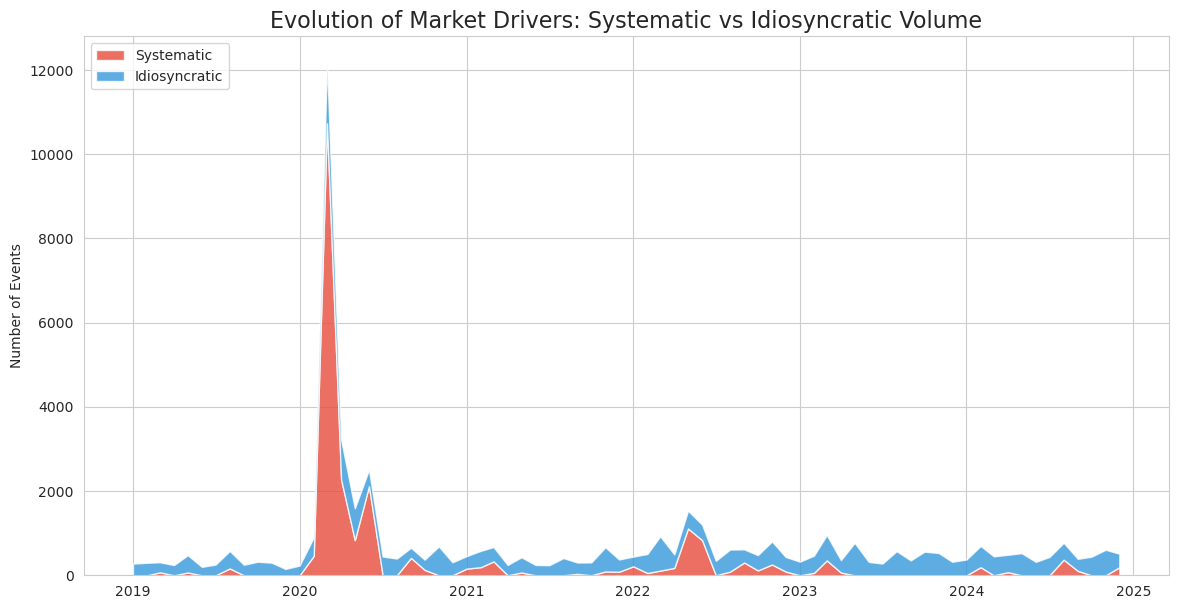

In [70]:
# Aggregate by month and type
monthly_type = (df_events
    .withColumn("month_year", F.date_trunc("month", "date"))
    .groupBy("month_year")
    .pivot("event_type", ["systematic", "idiosyncratic"])
    .count()
    .orderBy("month_year")
    .fillna(0)
    .toPandas()
)

# Plot
plt.figure(figsize=(14, 7))
plt.stackplot(monthly_type['month_year'], 
              monthly_type['systematic'], 
              monthly_type['idiosyncratic'], 
              labels=['Systematic', 'Idiosyncratic'],
              colors=['#e74c3c', '#3498db'], alpha=0.8)
plt.title('Evolution of Market Drivers: Systematic vs Idiosyncratic Volume', fontsize=16)
plt.ylabel('Number of Events')
plt.legend(loc='upper left')
plt.show()

### **Observations:**

The stacked area chart shows that the March 2020 spike in extreme events is overwhelmingly driven by systematic drops, with the red area dominating the total volume at the peak. Immediately after this crisis window, systematic volume falls back sharply, while idiosyncratic events (blue) remain consistently present and account for most of the background activity. In the post-2021 period, monthly totals stay higher than pre-COVID, but the mix is largely idiosyncratic with only occasional, much smaller bursts of systematic stress.

### **Insights:**

This evolution suggests that the COVID shock was a period of intense macro-driven fear, where broad market forces pushed many stocks down simultaneously. Once that wave passed, the market did not return to a “calm and macro-quiet” regime; instead, the elevated post-2021 volatility is primarily fueled by company-specific news and micro fundamentals. For risk managers, this means that today’s environment combines a higher overall event rate with a shift in composition: systemic crashes are rarer but still dangerous, while day-to-day tail risk is dominated by idiosyncratic names, making single-stock selection and diversification increasingly critical.

### **One-line Summary:**

The “ratio of chaos” chart shows that COVID-era extremes were macro-driven, but the persistently higher post-2021 volatility is mostly idiosyncratic, signaling a market where firm-specific shocks, rather than constant systemic panics, now dominate tail risk.

### **Concept Explanations:**
**Systematic Volume:** The count of extreme events on days classified as market-wide stress days.

**Idiosyncratic Volume:** The count of extreme events attributed to company-specific shocks on non-systemic days.

**Stacked Area Chart:** A plot where areas for different categories are stacked on top of each other to show both total volume and composition over time.

**Macro-driven Risk:** Risk coming from big picture forces like interest rates, inflation, or global crises.

**Micro / Firm-specific Fundamentals:** Company-level drivers such as earnings, balance sheet health, management issues, or product news.

## Hypothesis 4: Risk is concentrated in a small number of volatile firms
### Idea 7: The Volatility Lorenz Curve

**Goal**: Plot Cumulative % of Companies vs. Cumulative % of Extreme Events. If the line curves deeply, it confirms our Gini coefficient analysis (e.g., "Top 50 companies account for disproportionate share").

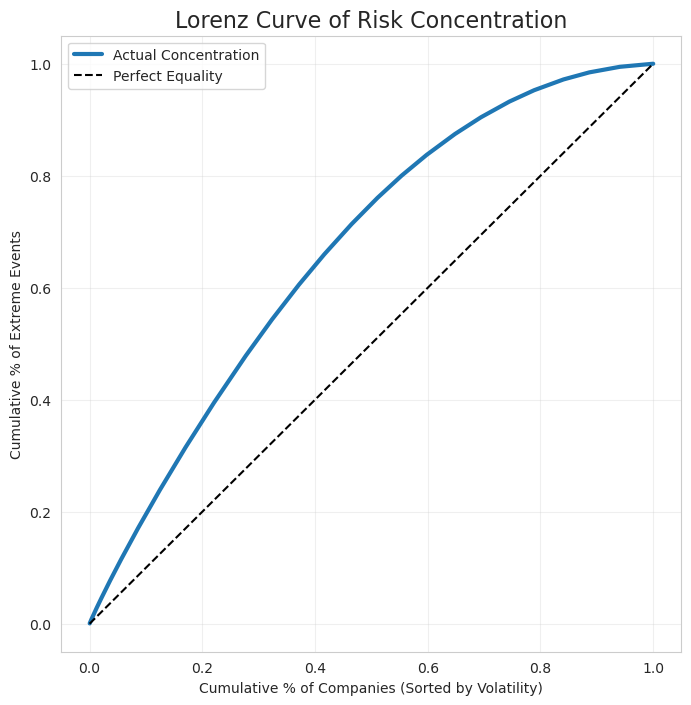

In [71]:
# Calculate events per company
company_counts = (df_events
    .groupBy("permno")
    .agg(F.count("*").alias("n_events"))
    .orderBy(F.col("n_events").desc())
    .toPandas()
)

# Calculate cumulative percentages
total_events = company_counts['n_events'].sum()
total_companies = len(company_counts)
company_counts['cum_events'] = company_counts['n_events'].cumsum()
company_counts['cum_pct_events'] = company_counts['cum_events'] / total_events
company_counts['cum_pct_companies'] = (company_counts.index + 1) / total_companies

plt.figure(figsize=(8, 8))
plt.plot(company_counts['cum_pct_companies'], company_counts['cum_pct_events'], linewidth=3, label='Actual Concentration')
plt.plot([0, 1], [0, 1], 'k--', label='Perfect Equality')
plt.title('Lorenz Curve of Risk Concentration', fontsize=16)
plt.xlabel('Cumulative % of Companies (Sorted by Volatility)')
plt.ylabel('Cumulative % of Extreme Events')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### **Observations:**

The Lorenz curve of risk concentration lies well above the 45° “perfect equality” line, indicating that extreme events are far from evenly distributed across firms. A small fraction of companies on the left side of the curve (the most volatile names) accounts for a disproportionately large share of total extreme drops: by the time we reach roughly 20–30% of firms on the x-axis, the curve has already captured well over half of all events, while the remaining 70–80% of firms contribute only a gradually increasing tail of additional crashes.

### **Insights:**

This pattern confirms that market crash risk is highly concentrated in a relatively small set of “problematic” or structurally volatile companies. For risk managers, treating each name as if it contributed equally to tail risk would be misleading; instead, the portfolio’s crash exposure is dominated by a core of high-event-frequency stocks. That concentration creates both a vulnerability and an opportunity: portfolios that are overweight these names are effectively leveraged to crash risk, whereas selectively underweighting or hedging this small subset can materially reduce overall tail exposure without needing to drastically diversify across the entire universe.

### **One-line Summary:**

The volatility Lorenz curve shows that a minority of highly volatile firms generates the majority of extreme events, proving that crash risk is sharply concentrated rather than evenly spread across the market.

### **Concept Explanations:**
**Lorenz Curve:** A curve that compares cumulative % of entities (here, companies) to cumulative % of some quantity (here, extreme events) to show concentration.

**Perfect Equality Line (45° Line):** The diagonal line where, for example, 20% of companies would account for 20% of events; used as a benchmark.

**Risk Concentration:** The idea that a small group of assets generates a large share of total risk events.

**Gini-style Inequality (mentioned conceptually):** A way to summarize how unequal the distribution is; a more bowed Lorenz curve means higher inequality.

### 4.2 "Top Offenders" Bar Chart

**Goal**: Identify the specific companies (Tickers) with the highest frequency of extreme drops. Are they meme stocks, biotech, or tech giants?

/tmp/ipykernel_15962/3299464242.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="count", y="ticker", data=top_tickers, palette="viridis")


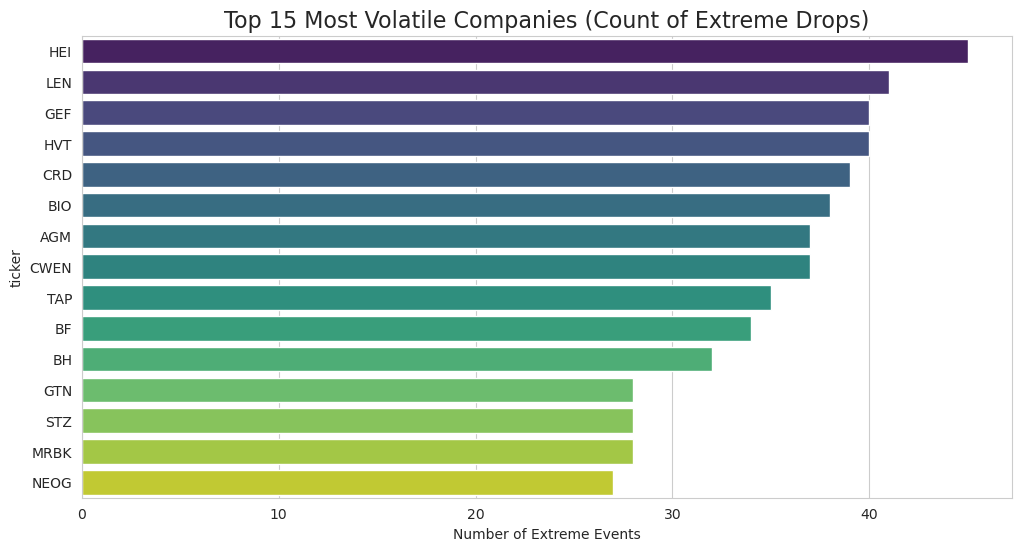

In [72]:
top_tickers = (df_events
    .groupBy("ticker")
    .count()
    .orderBy(F.col("count").desc())
    .limit(15)
    .toPandas()
)

plt.figure(figsize=(12, 6))
sns.barplot(x="count", y="ticker", data=top_tickers, palette="viridis")
plt.title('Top 15 Most Volatile Companies (Count of Extreme Drops)', fontsize=16)
plt.xlabel('Number of Extreme Events')
plt.show()

### **Observations:**

The bar chart ranks the top 15 “repeat offenders” by the number of extreme drops, with all names showing very high event counts clustered roughly in the 30–45 range. A few tickers, such as HEI and LEN, stand out at the upper end, but even the lowest in the list (e.g., NEOG, MRBK) still experience far more crashes than the typical firm in the universe. The list spans multiple sectors—including industrials, homebuilders, consumer names, media, and financials—indicating that the most volatile companies are not confined to a single niche like meme stocks or pure tech.

### **Insights:**

This ranking puts concrete tickers behind the abstract Lorenz-curve result that crash risk is highly concentrated. These firms are not just occasionally volatile; they repeatedly generate extreme events across the sample, effectively acting as persistent tail-risk generators in the market. For portfolio and risk managers, this set of names can function as a practical “high-volatility watchlist”: overweighting them materially increases exposure to crash frequency, whereas tightening limits, hedging, or selectively excluding a subset of these tickers can reduce portfolio tail risk without requiring broad-based de-risking across all holdings.

### **One-line Summary:**

The top-15 bar chart identifies a small cross-sector group of “repeat offender” stocks that account for a disproportionately high number of extreme drops, turning abstract risk concentration into a concrete, ticker-level watchlist.

### **Concept Explanations:**
**Most Volatile Companies / Repeat Offenders:** Stocks that experience extreme drops unusually often compared with the rest of the universe.

**Event Count:** The number of times a given stock crossed the extreme-drop threshold over the sample period.

**Cross-sector:** Refers to the fact that these top offenders come from different industries (not just one niche like tech or meme stocks).

**High-volatility Watchlist:** A practical list of names that risk managers may monitor more closely, limit position sizes in, or hedge specifically because they drive a lot of tail risk.

## Event Study Trajectory
**Goal**: Plot the average price path (T-5 to T+10) around an extreme event. Do stocks typically bounce back ("Dead Cat Bounce") or drift lower after the drop?

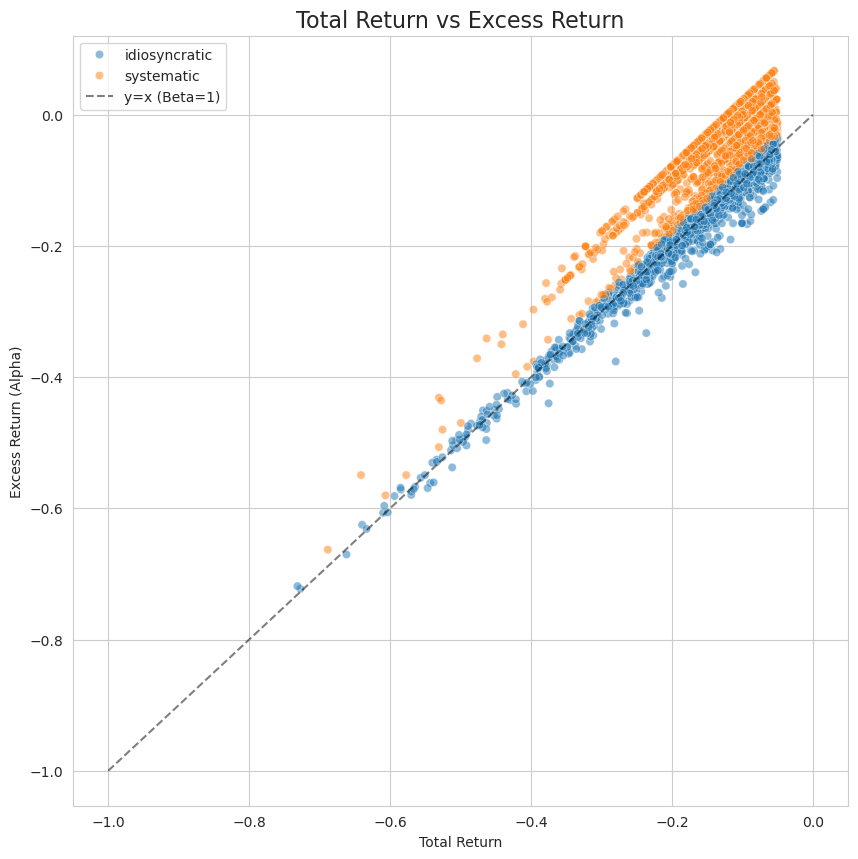

In [73]:
# Select a subset of dates for visualization to keep it efficient
# We calculate the average return path for idiosyncratic events
from pyspark.sql.window import Window

# Define window to get leads/lags (simplified for visualization concept)
# Ideally, you'd structure the data to have relative days, but here is a simplified scatter of Ret vs Excess Ret
pdf_scatter = df_events.sample(False, 0.1, seed=42).select("ret", "excess_ret", "event_type").toPandas()

plt.figure(figsize=(10, 10))
sns.scatterplot(data=pdf_scatter, x="ret", y="excess_ret", hue="event_type", alpha=0.5)
plt.plot([-1, 0], [-1, 0], 'k--', alpha=0.5, label='y=x (Beta=1)')
plt.title('Total Return vs Excess Return', fontsize=16)
plt.xlabel('Total Return')
plt.ylabel('Excess Return (Alpha)')
plt.legend()
plt.show()

### **Observations:**

The scatter plot of Total Return vs. Excess Return shows a strong, roughly linear relationship along a downward diagonal, but the two event types occupy different regions relative to the 45° y = x line. Systematic events (orange) tend to sit above the line, meaning their excess returns are less negative than their total returns for a given crash size. In contrast, idiosyncratic events (blue) cluster on or below the line, with excess returns often as negative as—or even more negative than—the total return. Both types span severe losses (down to around –80% to –100%), but idiosyncratic points are more concentrated in the region where alpha is strongly negative.

### **Insights:**

This pattern suggests that extreme systematic crashes are largely beta-driven: most of the damage can be attributed to broad market exposure, with relatively limited additional negative alpha. When the whole market sells off, individual stocks still move with the index, so their excess returns are somewhat cushioned relative to their total losses. Idiosyncratic events, however, often involve a negative alpha shock on top of any market move—firm-specific bad news or repricing pushes excess returns down at least as much as the total return, and sometimes more. For portfolio managers, this means that hedging only market beta is effective against systematic crash days, but offers much less protection against idiosyncratic disaster days where the alpha component dominates the loss.

### **One-line Summary:**

The total-vs-excess return scatter shows that systematic crashes are mostly market-beta losses, while idiosyncratic crashes are dominated by deeply negative alpha, making single-name blow-ups much harder to hedge with index protection alone.

### **Concept Explanations:**

**Total Return:** The raw percentage price change of a stock over the period (including the crash), without adjusting for the market.

**Excess Return:** The stock’s return minus the market’s return over the same period; this measures how much the stock outperformed or underperformed the index.

**Alpha:** The part of a stock’s return that cannot be explained by the market; positive alpha = doing better than the market, negative alpha = doing worse than the market after controlling for market moves.

**Beta:** A measure of how sensitive a stock is to market movements (e.g., beta = 1 means the stock tends to move one-for-one with the index). “Beta-driven” losses are mostly due to following the market down.

**Systematic Event:** A crash that happens on a day when the overall market is also falling sharply, usually driven by macro news (rates, recession fears, geopolitics, etc.).

**Idiosyncratic Event:** A crash driven mainly by company-specific news (earnings surprise, scandal, downgrade), not by the overall market.
Hedging / Index Protection: Using instruments like index futures, ETFs, or options to offset losses that come from market-wide moves (beta), which works well for systematic risk but not for pure alpha shocks in single names.

## **Research Design: Why the Three Major Crises (2000, 2008, 2020)?**
### **1. Event Selection Rationale**

This study focuses on three major systemic negative shocks in the past twenty-five years:
(1) the 2000 Dot-Com Bubble Burst, (2) the 2008 Global Financial Crisis, and (3) the 2020 COVID-19 liquidity collapse.
These events represent the most significant market-wide downturns in modern financial history and provide ideal natural experiments for studying firm resilience.

Each event is characterized by high exogeneity, meaning the shocks were not caused by individual firms or industries but were broad, unexpected, and unavoidable. This makes them excellent empirical environments for observing how different firms react to extreme stress.

The three crises capture distinct economic mechanisms, enabling a multidimensional evaluation of firm quality:

### **(1) 2000 Dot-Com Crash — Valuation Shock**

The collapse of technology-driven overvaluation pressured firms to prove whether their products, users, and business models were fundamentally sound. Companies that survived and recovered (e.g., Amazon, Apple) demonstrated genuine long-term strength rather than speculative hype.

### **(2) 2008 Global Financial Crisis — Credit & Balance Sheet Shock**

This crisis stressed corporate leverage, liquidity, cash flow stability, and managerial decision-making. Firms that rebounded quickly typically maintained strong balance sheets, avoided excessive leverage, and preserved investor trust during financial distress.

### **(3) 2020 COVID-19 Market Collapse — Operational Shock**

Triggered by a global pandemic and accompanied by multiple market circuit breakers, this shock tested firms’ operational flexibility, digital capabilities, supply chain robustness, and brand strength. Firms that rapidly recovered (e.g., Apple, Microsoft, Costco, Tesla) showed resilience beyond cyclical or valuation factors.

Together, these crises span three fundamentally different stress categories
— valuation, credit, and operational risks — allowing us to evaluate firms on multiple dimensions of resilience.

## 2.Research Framework

The overarching goal of this study is to use systemic crises as stress tests to identify companies with superior long-term resilience. Instead of judging firms based on normal market conditions, we evaluate how they behave under extreme negative events — when true quality is revealed.

The research follows four main steps:

### **Step 1: Construct Event Windows for Each Crisis**

Define symmetric windows around each macro shock (e.g., –5 to +20 trading days) to capture price reactions, drawdowns, and recoveries.

### **Step 2: Collect Firm-Level Daily Prices and Returns Within Each Window**

Using market-wide datasets (e.g., CRSP), we obtain adjusted prices, daily returns, and trading volumes for all publicly listed firms.

### **Step 3: Calculate Three Measures of Firm Resilience for Each Event**

For each firm–event pair:

**1. Maximum Drawdown (Shock Exposure)**
Measures how severely the price fell after the crisis hit.

**2. Recovery Days (Rebound Speed)**
Measures how many trading days the firm took to return to its pre-event price.

**3. Recovery Slope (Recovery Efficiency)**
Measures the rate of price improvement from the bottom to the recovery point.

These metrics capture short-term stress reaction, managerial quality, operational adaptability, and investor confidence during crises.

### **Step 4: Combine Results Across the Three Crises to Build a Firm Resilience Profile**

We aggregate resilience metrics for each company across all three shocks, allowing us to identify:

- Firms that consistently recover quickly

- Firms that are shock-specific (strong in one crisis but weak in others)

- Firms that fail to recover in any crisis

This generates a multi-crisis resilience signature for each firm.



In [ ]:
# Year 2000: Dotcom bubble peak + political uncertainty

events_2000 = [
    {
        "date": "2000-01-04",
        "label": "On the first trading day of the new year, the NASDAQ and growth stocks experienced a sharp pullback, signaling rising skepticism about extreme valuations in tech and internet stocks.",
        "category": "MarketEvent_US_TechVolatility_EarlyWarning",
        "window_start": -3,
        "window_end": 10,
    },

    {
        "date": "2000-03-10",
        "label": "The NASDAQ Composite peaked during the Dotcom bubble and then entered a prolonged multi-year bear market, with high-valuation tech and internet sectors undergoing systemic valuation compression.",
        "category": "MarketEvent_US_TechBubblePeak",
        "window_start": -30,
        "window_end": 60,
    },

    {
        "date": "2000-05-16",
        "label": "The Federal Reserve raised the federal funds rate to 6.5%, citing inflation and asset bubble concerns, tightening monetary conditions significantly.",
        "category": "MonetaryPolicy_Fed_Hawkish_LateCycle",
        "window_start": -3,
        "window_end": 15,
    },

    {
        "date": "2000-11-07",
        "label": "The U.S. presidential election (Bush vs. Gore) resulted in an extremely close vote, triggering the Florida recount and legal disputes, sharply increasing political uncertainty.",
        "category": "Policy_US_Election_2000_Vote",
        "window_start": -5,
        "window_end": 20,
    },

    {
        "date": "2000-12-12",
        "label": "The U.S. Supreme Court ruling ended the Florida recount dispute and confirmed George W. Bush as the winner, prompting a market reaction to the removal of political uncertainty.",
        "category": "Policy_US_Election_2000_Resolution",
        "window_start": -3,
        "window_end": 15,
    },
]

In [ ]:
events_2008 = [
    # Fed rate cuts
    {"date": "2008-01-22", "label": "Emergency 75bp rate cut: 4.25 → 3.50", "category": "MonetaryPolicy_Fed", "window_start": -3, "window_end": 5},
    {"date": "2008-01-30", "label": "Regular 50bp rate cut: 3.50 → 3.00", "category": "MonetaryPolicy_Fed", "window_start": -3, "window_end": 5},
    {"date": "2008-03-18", "label": "75bp rate cut: 3.00 → 2.25", "category": "MonetaryPolicy_Fed", "window_start": -3, "window_end": 5},
    {"date": "2008-04-30", "label": "25bp rate cut: 2.25 → 2.00", "category": "MonetaryPolicy_Fed", "window_start": -3, "window_end": 5},
    {"date": "2008-10-08", "label": "Global coordinated 50bp rate cut: 2.00 → 1.50", "category": "MonetaryPolicy_Fed", "window_start": -3, "window_end": 5},
    {"date": "2008-10-29", "label": "50bp rate cut: 1.50 → 1.00", "category": "MonetaryPolicy_Fed", "window_start": -3, "window_end": 5},
    {"date": "2008-12-16", "label": "Rates lowered to the 0–0.25% range, marking the start of the zero-interest-rate era", "category": "MonetaryPolicy_Fed", "window_start": -5, "window_end": 10},

    # Credit crisis: Bear, GSEs, Lehman, AIG, WaMu
    {"date": "2008-03-14", "label": "Bear Stearns’ liquidity crisis became public; the Fed provided emergency support", "category": "CreditCrisis_US", "window_start": -5, "window_end": 10},
    {"date": "2008-03-16", "label": "JPM agreed to acquire Bear Stearns with Fed backing", "category": "CreditCrisis_US", "window_start": -5, "window_end": 20},
    {"date": "2008-07-30", "label": "HERA (Housing and Economic Recovery Act) signed into law", "category": "Policy_US_Internal", "window_start": -5, "window_end": 20},
    {"date": "2008-09-07", "label": "Fannie Mae & Freddie Mac placed into conservatorship", "category": "CreditCrisis_US", "window_start": -5, "window_end": 20},
    {"date": "2008-09-15", "label": "Lehman Brothers filed for bankruptcy", "category": "CreditCrisis_US", "window_start": -5, "window_end": 20},
    {"date": "2008-09-15", "label": "Bank of America announced acquisition of Merrill Lynch", "category": "CreditCrisis_US", "window_start": -5, "window_end": 20},
    {"date": "2008-09-16", "label": "AIG received an $85B emergency loan from the Fed and was effectively taken over", "category": "CreditCrisis_US", "window_start": -5, "window_end": 20},
    {"date": "2008-09-25", "label": "Washington Mutual was seized and major assets sold to JPM", "category": "CreditCrisis_US", "window_start": -5, "window_end": 20},

    # TARP legislation
    {"date": "2008-09-29", "label": "House rejected TARP; markets plunged", "category": "Policy_US_Internal", "window_start": -5, "window_end": 10},
    {"date": "2008-10-03", "label": "TARP/EESA passed and signed into law", "category": "Policy_US_Internal", "window_start": -5, "window_end": 20},

    # Extreme market volatility
    {"date": "2008-09-29", "label": "Dow Jones dropped 777 points — one of the largest single-day declines on record", "category": "MarketEvent_BearBull", "window_start": -5, "window_end": 10},
    {"date": "2008-10-10", "label": "Global markets entered extreme panic; S&P 500 fell over 18% in one week", "category": "MarketEvent_BearBull", "window_start": -5, "window_end": 20},
    {"date": "2008-11-20", "label": "One of the major crisis lows for S&P 500 (down over 50% from the 2007 peak)", "category": "MarketEvent_BearBull", "window_start": -20, "window_end": 60},
]

In [63]:
events_2020 = [
    # COVID outbreak and global spread
    {
        "date": "2020-01-21",
        "label": "First confirmed COVID-19 case in the U.S., marking the beginning of domestic pandemic risk awareness.",
        "category": "MacroEvent_COVID_US_FirstCase",
        "window_start": -5,
        "window_end": 20,
    },

    {
        "date": "2020-02-24",
        "label": "Global markets began sharp declines as COVID-19 outbreaks accelerated in Europe; fear of a global pandemic escalated.",
        "category": "MarketEvent_COVID_GlobalSelloff_Start",
        "window_start": -5,
        "window_end": 20,
    },

    # Circuit breakers and extreme volatility
    {
        "date": "2020-03-09",
        "label": "U.S. equities triggered the first circuit breaker of this cycle amid pandemic spread and the oil-price war, sending markets into extreme panic.",
        "category": "MarketEvent_US_COVID_CircuitBreaker_1st",
        "window_start": -5,
        "window_end": 20,
    },

    {
        "date": "2020-03-12",
        "label": "Second market-wide circuit breaker as COVID fears intensified; markets posted historic single-day declines.",
        "category": "MarketEvent_US_COVID_CircuitBreaker_2nd",
        "window_start": -5,
        "window_end": 20,
    },

    {
        "date": "2020-03-16",
        "label": "Third circuit breaker triggered; volatility reached unprecedented levels as investors feared a global economic shutdown.",
        "category": "MarketEvent_US_COVID_CircuitBreaker_3rd",
        "window_start": -5,
        "window_end": 20,
    },

    # Fed emergency actions
    {
        "date": "2020-03-03",
        "label": "Emergency 50bp rate cut in response to escalating pandemic risks.",
        "category": "MonetaryPolicy_Fed_EmergencyCut",
        "window_start": -3,
        "window_end": 10,
    },

    {
        "date": "2020-03-15",
        "label": "Fed cut rates to 0–0.25% and launched a large-scale emergency stimulus program to stabilize markets.",
        "category": "MonetaryPolicy_Fed_ZIRP_QE",
        "window_start": -5,
        "window_end": 20,
    },

    # Fiscal stimulus
    {
        "date": "2020-03-27",
        "label": "CARES Act signed into law, introducing unprecedented fiscal stimulus including direct payments, unemployment support, and business aid.",
        "category": "Policy_US_Fiscal_CARESAct",
        "window_start": -10,
        "window_end": 40,
    },

    # Market bottom
    {
        "date": "2020-03-23",
        "label": "S&P 500 hit its pandemic-cycle bottom, down ~34% from the February peak before beginning a rapid recovery.",
        "category": "MarketEvent_US_COVID_Bottom",
        "window_start": -20,
        "window_end": 60,
    },
]

In [19]:
# Add derived columns: log returns and market value
df_parquet = (
    df_parquet
    .withColumn("LOGRET", F.log(1.0 + F.coalesce(F.col("RETX"), F.lit(0.0))))
    .withColumn("MV", F.col("PRC") * F.col("SHROUT") * 1000.0)  # Market cap approximation
)
df_parquet.select(
    "PERMNO", "date", "TICKER", "PRC", "RETX", "sprtrn", "LOGRET", "MV"
).show(5)

+------+----------+------+------+---------+---------+--------------------+-----------+
|PERMNO|      date|TICKER|   PRC|     RETX|   sprtrn|              LOGRET|         MV|
+------+----------+------+------+---------+---------+--------------------+-----------+
| 10001|2001-01-29|  EWST|9.8125|-0.006329| 0.006805|-0.00634911302898...|2.4511625E7|
| 10001|2001-05-25|  EWST|  11.0|-0.022222|-0.011816|-0.02247262857935...|   2.7599E7|
| 10001|2001-07-05|  EWST| 11.92|-0.022951|-0.012321|-0.02321847466578...| 2.995496E7|
| 10001|2001-09-21|  EWST|  12.0|-0.043825|-0.019034|-0.04481432828984...|   3.0168E7|
| 10001|2001-11-06|  EWST|  11.5|      0.0| 0.014526|                 0.0|   2.8957E7|
+------+----------+------+------+---------+---------+--------------------+-----------+
only showing top 5 rows



**NOTE:** The Dual-Threshold (Z-score filter) is the gold standard for the modern period (2019-2024) because it correctly isolates events that are extreme relative to a stock's own recent volatility profile. **However**, applying this complex, rolling metric consistently and reliably across the full 50+ year history needed for the multi-crisis Event Study Trajectory is both computationally inefficient and subject to boundary condition issues.Therefore, the $\ge 7\%$ Drop definition is used for the Event Study as a necessary proxy to gain historical depth, ensuring we have enough data points across the Dotcom (2000), GFC (2008), and COVID (2020) crises to create a statistically meaningful, cross-crisis resilience metric.

In [ ]:
events_all = (
    df_parquet
      .filter(F.col("RETX") <= -0.07)       
      .select(
          "PERMNO",
          "TICKER",
          "date",
          "year",
          "RETX",
          "sprtrn"
      )
      .withColumnRenamed("date", "event_date")
      .withColumnRenamed("RETX", "event_retx")
)

events_all.orderBy("event_date").limit(20).show(truncate=False)

print("Total events:", events_all.count())

+------+------+----------+----+----------+---------+
|PERMNO|TICKER|event_date|year|event_retx|sprtrn   |
+------+------+----------+----+----------+---------+
|37612 |UFD   |1970-01-02|1970|-0.076923 |0.010211 |
|33419 |KFD   |1970-01-02|1970|-0.095652 |0.010211 |
|41267 |REO   |1970-01-02|1970|-0.144737 |0.010211 |
|49170 |NHE   |1970-01-05|1970|-0.08547  |0.004946 |
|41865 |ME    |1970-01-05|1970|-0.074212 |0.004946 |
|48231 |PMR   |1970-01-05|1970|-0.078261 |0.004946 |
|14349 |SES   |1970-01-05|1970|-0.140845 |0.004946 |
|37444 |TRB   |1970-01-05|1970|-0.083333 |0.004946 |
|44783 |WKR   |1970-01-05|1970|-0.072368 |0.004946 |
|28409 |GFC   |1970-01-05|1970|-0.081633 |0.004946 |
|32328 |GOR   |1970-01-05|1970|-0.102041 |0.004946 |
|48696 |EMM   |1970-01-05|1970|-0.171521 |0.004946 |
|34956 |PLW   |1970-01-06|1970|-0.07619  |-0.006848|
|49234 |STK   |1970-01-06|1970|-0.090909 |-0.006848|
|37110 |TMA   |1970-01-06|1970|-0.076923 |-0.006848|
|31261 |DIV   |1970-01-06|1970|-0.072727 |-0.0

[Stage 142:====================================================>(132 + 1) / 133]

Total events: 2191670


In [21]:
events_by_year = (
    events_all
      .groupBy("year")
      .agg(
          F.count("*").alias("n_events"),
          F.countDistinct("PERMNO").alias("n_stocks")
      )
      .orderBy("year")
)

events_by_year.show(50, truncate=False)

[Stage 147:============================>                            (2 + 2) / 4]

+----+--------+--------+
|year|n_events|n_stocks|
+----+--------+--------+
|1970|11576   |1847    |
|1971|5772    |1393    |
|1972|6164    |1698    |
|1973|38157   |4603    |
|1974|41138   |4290    |
|1975|25953   |3443    |
|1976|18086   |2760    |
|1977|14050   |2420    |
|1978|17372   |3170    |
|1979|15136   |3004    |
|1980|19271   |3543    |
|1981|20919   |3420    |
|1982|25451   |3646    |
|1983|22536   |3791    |
|1984|29224   |4056    |
|1985|30892   |3847    |
|1986|38217   |4641    |
|1987|63181   |6368    |
|1988|48470   |4733    |
|1989|43963   |4461    |
|1990|72389   |5146    |
|1991|66958   |4847    |
|1992|76953   |4918    |
|1993|74732   |5095    |
|1994|77178   |5220    |
|1995|73345   |5242    |
|1996|77722   |5623    |
|1997|76817   |6188    |
|1998|95672   |6901    |
|1999|81726   |6431    |
|2000|127690  |6524    |
|2001|92906   |5725    |
|2002|72231   |4862    |
|2003|31124   |3762    |
|2004|20255   |3304    |
|2005|16526   |3224    |
|2006|13372   |2996    |


In [22]:
import matplotlib.pyplot as plt

pdf = events_by_year.orderBy('year').toPandas()
print(pdf.head())

   year  n_events  n_stocks
0  1970     11576      1847
1  1971      5772      1393
2  1972      6164      1698
3  1973     38157      4603
4  1974     41138      4290


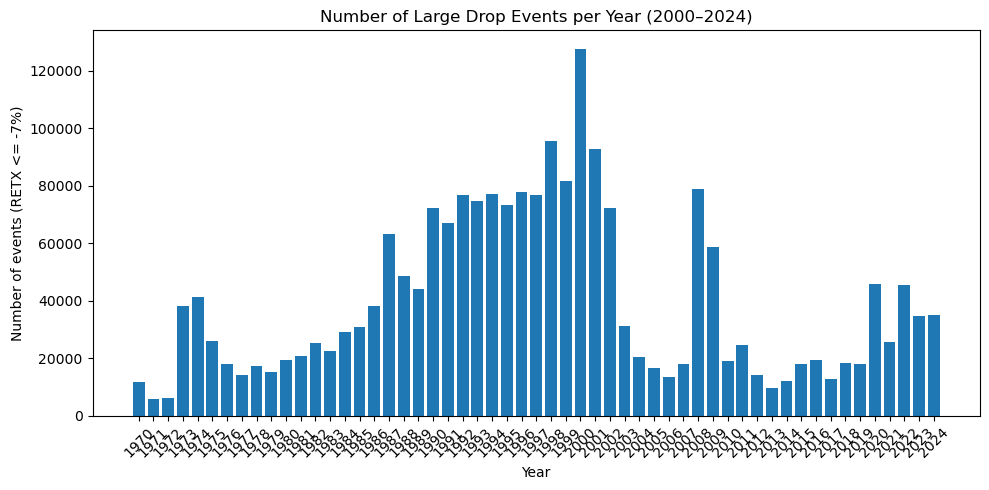

In [23]:
plt.figure(figsize=(10, 5))
plt.bar(pdf["year"], pdf["n_events"])
plt.xlabel("Year")
plt.ylabel("Number of events (RETX <= -7%)")
plt.title("Number of Large Drop Events per Year (2000–2024)")
plt.xticks(pdf["year"], rotation=45)
plt.tight_layout()
plt.show()

### **Observations:**

The annual bar chart shows that large drop events (RETX ≤ –7%) are very unevenly distributed across 2000–2024. Counts are relatively modest in the early 2000s, rise steadily into the mid-2000s, and then spike dramatically around the 2008–2009 Global Financial Crisis, where the number of events more than doubles the surrounding years. After 2010, event counts fall back but remain elevated for several years before drifting down to a low plateau in the mid-2010s. A second major surge appears in 2020, consistent with the COVID shock, followed by still-elevated but more moderate volumes in the early 2020s compared with the pre-crisis lows.

### **Insights:**

The time series confirms that large stock price crashes are clustered in a handful of macro-stress regimes rather than occurring at a constant rate over time. Years associated with major crises (GFC, COVID) generate multiples of the “normal” event count, while quiet periods in the mid-2010s see far fewer extreme drops despite a similar or larger number of listed stocks. For risk managers and allocators, this implies that historical averages can be misleading: portfolios are exposed to long stretches of relative calm punctuated by intense crash years, so capital planning, stress testing, and scenario design must explicitly incorporate these high-intensity regimes instead of assuming a stable yearly crash frequency.

### **One-line Summary:**

The yearly bar chart shows that large crash events are heavily concentrated in a few crisis years like 2008–2009 and 2020, confirming that tail risk arrives in rare but extremely intense waves rather than at a steady annual pace.

### **Concept Explanations:**

**RETX:** A return variable from CRSP representing the stock’s daily return including distributions (e.g., dividends), expressed in decimal form (–0.07 = –7%).

**Large Drop Event (RETX ≤ –7%):** A trading day where a stock’s return is at or below –7%, treated here as a “crash day” for that stock.

**Tail Risk:** The risk of very rare, extremely negative outcomes lying in the “tails” of the return distribution (far from the average daily move).

**Crisis / Stress Regime:** A period (often months or years) when market conditions are unusually unstable, producing many more large drops than in typical years (e.g., Global Financial Crisis, COVID shock).

## PART 1: Foundational Definitions

### 1.1 Crisis Identification → A systematic market event that creates widespread stock price dislocations.

In [24]:
events_three = [
    {
        "event_name": "Dotcom_Burst_2000",
        "event_date": "2000-03-10",      # NASDAQ peak
        "window_start": -5,               # 5 days before
        "window_end": 60,                 # 60 days after
        "rationale": "Tech bubble burst - sector-specific systematic shock"
    },
    {
        "event_name": "GFC_Lehman_2008", 
        "event_date": "2008-09-15",      # Lehman bankruptcy
        "window_start": -5,
        "window_end": 120,                # Extended window for financial crisis
        "rationale": "Financial system collapse - broad systematic shock"
    },
    {
        "event_name": "COVID_CircuitBreaker_2020",
        "event_date": "2020-03-16",      # Worst single-day drop
        "window_start": -5,
        "window_end": 90,
        "rationale": "Pandemic shock - unprecedented systematic event"
    }
]

events_df = spark.createDataFrame(events_three).withColumn(
    "event_date", F.to_date("event_date")
)

In [25]:
events_df.show(5)

+----------+--------------------+--------------------+----------+------------+
|event_date|          event_name|           rationale|window_end|window_start|
+----------+--------------------+--------------------+----------+------------+
|2000-03-10|   Dotcom_Burst_2000|Tech bubble burst...|        60|          -5|
|2008-09-15|     GFC_Lehman_2008|Financial system ...|       120|          -5|
|2020-03-16|COVID_CircuitBrea...|Pandemic shock - ...|        90|          -5|
+----------+--------------------+--------------------+----------+------------+



### 1.2 Recovery Window Definition → The period from crisis start to when a company's stock price returns to pre-crisis levels.

In [33]:
events_with_ranges = (
    events_df
    .withColumn("filter_start", F.date_add("event_date", F.lit(-40)))
    .withColumn("filter_end",   F.date_add("event_date", F.lit(60)))
)

In [28]:
# # Define crisis-specific windows that match our event definitions
events_with_ranges = (
    events_df
    .withColumn("filter_start", 
                F.date_add("event_date", F.col("window_start").cast("int")))
    .withColumn("filter_end", 
                F.date_add("event_date", F.col("window_end").cast("int")))
)

# Verify the windows
ranges= events_with_ranges.select(
    "event_name", "event_date", 
    "window_start", "window_end",
    "filter_start", "filter_end"
).show(20, truncate=False)

+-------------------------+----------+------------+----------+------------+----------+
|event_name               |event_date|window_start|window_end|filter_start|filter_end|
+-------------------------+----------+------------+----------+------------+----------+
|Dotcom_Burst_2000        |2000-03-10|-5          |60        |2000-03-05  |2000-05-09|
|GFC_Lehman_2008          |2008-09-15|-5          |120       |2008-09-10  |2009-01-13|
|COVID_CircuitBreaker_2020|2020-03-16|-5          |90        |2020-03-11  |2020-06-14|
+-------------------------+----------+------------+----------+------------+----------+



In [29]:
ranges = events_with_ranges.select("event_name", "filter_start", "filter_end").collect()

print(f"Collected {len(ranges)} crisis windows:")
for row in ranges:
    days_span = (row["filter_end"] - row["filter_start"]).days
    print(f"  {row['event_name']}: {row['filter_start']} to {row['filter_end']} ({days_span} days)")

# Ensure df_clean date column is DateType
df_parquet = df_parquet.withColumn("date", F.col("date").cast("date"))

# Build OR condition: include date if it falls in ANY crisis window
cond = None
for row in ranges:
    c = (F.col("date") >= row["filter_start"]) & (F.col("date") <= row["filter_end"])
    cond = c if cond is None else (cond | c)

# Apply filter to create df_small
print("\nFiltering df_clean to crisis windows only...")
df_small = df_parquet.where(cond)

original_count = df_parquet.count()
filtered_count = df_small.count()

print(f"Original df_clean rows: {original_count:,}")
print(f"Filtered df_small rows: {filtered_count:,}")

Collected 3 crisis windows:
  Dotcom_Burst_2000: 2000-03-05 to 2000-05-09 (65 days)
  GFC_Lehman_2008: 2008-09-10 to 2009-01-13 (125 days)
  COVID_CircuitBreaker_2020: 2020-03-11 to 2020-06-14 (95 days)

Filtering df_clean to crisis windows only...


[Stage 174:====================================================>(132 + 1) / 133]

Original df_clean rows: 68,242,289
Filtered df_small rows: 921,338


In [30]:
df_small = df_small.withColumn(
    "adj_prc",
    F.col("PRC") * F.col("CFACPR")
)

prices_es = (
    df_small
    .select(
        "PERMNO",
        F.col("date").alias("trade_date"),
        "adj_prc",
        "RET",
        "PRC",
        "VOL",
        "ASKHI",
        "BIDLO"
    )
)

In [ ]:
df_evt = (
    df_small.alias("p")
    .join(
        events_with_ranges.alias("e"),
        (F.col("p.date") >= F.col("e.filter_start")) &
        (F.col("p.date") <= F.col("e.filter_end")),
        "inner"
    )
    .withColumn("tau", F.datediff(F.col("p.date"), F.col("e.event_date")))

    .where(
        (F.col("tau") >= F.col("e.window_start")) &
        (F.col("tau") <= F.col("e.window_end"))
    )
)
df_evt.select("event_name", "event_date", "PERMNO", "date", "tau", "RET").show(10, truncate=False)

drops_7 = df_evt.where(F.col("RET") <= F.lit(-0.07))

summary_7 = (
    drops_7
    .groupBy("event_name")
    .agg(
        F.countDistinct("PERMNO").alias("num_stocks_7pct"),  
        F.count("*").alias("num_stock_days_7pct")            
    )
)

summary_7.show(truncate=False)

drops_detail = (
    drops_7
    .select(
        "event_name",
        "event_date",
        "tau",
        "PERMNO",
        F.col("date").alias("trade_date"),
        "RET",
        "adj_prc",
        "VOL",
        "ASKHI",
        "BIDLO"
    )
    .orderBy("event_name", "PERMNO", "trade_date")
)

drops_detail.show(20, truncate=False)

+-----------------+----------+------+----------+---+---------+
|event_name       |event_date|PERMNO|date      |tau|RET      |
+-----------------+----------+------+----------+---+---------+
|Dotcom_Burst_2000|2000-03-10|10001 |2000-03-09|-1 |-0.031746|
|Dotcom_Burst_2000|2000-03-10|10001 |2000-04-03|24 |0.0      |
|Dotcom_Burst_2000|2000-03-10|10009 |2000-03-29|19 |-0.003976|
|Dotcom_Burst_2000|2000-03-10|10009 |2000-04-18|39 |0.0      |
|Dotcom_Burst_2000|2000-03-10|10025 |2000-04-14|35 |-0.003883|
|Dotcom_Burst_2000|2000-03-10|10026 |2000-03-10|0  |-0.022152|
|Dotcom_Burst_2000|2000-03-10|10026 |2000-03-16|6  |-0.02439 |
|Dotcom_Burst_2000|2000-03-10|10026 |2000-04-17|38 |-0.011364|
|Dotcom_Burst_2000|2000-03-10|10026 |2000-05-02|53 |0.007905 |
|Dotcom_Burst_2000|2000-03-10|10028 |2000-04-28|49 |-0.017241|
+-----------------+----------+------+----------+---+---------+
only showing top 10 rows



+-------------------------+---------------+-------------------+
|event_name               |num_stocks_7pct|num_stock_days_7pct|
+-------------------------+---------------+-------------------+
|COVID_CircuitBreaker_2020|3502           |21054              |
|Dotcom_Burst_2000        |5072           |29889              |
|GFC_Lehman_2008          |4255           |33013              |
+-------------------------+---------------+-------------------+



[Stage 186:===================================================> (260 + 4) / 266]

## PART 2: Complete Implementation

In [ ]:
df_evt_to_save = (
    df_evt
    .select(
        "event_name",
        "event_date",
        "PERMNO",
        "date",
        "tau",
        "RET",
        "adj_prc",
        "VOL",
        "ASKHI",
        "BIDLO",
    )
)

evt_path = f"gs://{BUCKET_NAME}/prices_parquet/prices_with_events"

print(f"Saving df_evt to: {evt_path}")

# 3) Write to GCS as Parquet
df_evt_to_save.write \
    .mode("overwrite") \
    .format("parquet") \
    .option("compression", "snappy") \
    .save(evt_path)

print(f"✓ df_evt saved successfully to {evt_path}")

In [38]:
# Part 2 — Load event layer from disk (run at the START of each new session)

from pyspark.sql import functions as F
import os

evt_path = f"gs://{BUCKET_NAME}/prices_parquet/prices_with_events"
df_evt = spark.read.parquet(evt_path)

df_evt.printSchema()
df_evt.show(5, truncate=False)
print("Loaded df_evt from:", evt_path)

root
 |-- event_name: string (nullable = true)
 |-- event_date: date (nullable = true)
 |-- PERMNO: integer (nullable = true)
 |-- date: date (nullable = true)
 |-- tau: integer (nullable = true)
 |-- RET: double (nullable = true)
 |-- adj_prc: double (nullable = true)
 |-- VOL: integer (nullable = true)
 |-- ASKHI: double (nullable = true)
 |-- BIDLO: double (nullable = true)

+-----------------+----------+------+----------+---+---------+-------+-----+-----+------+
|event_name       |event_date|PERMNO|date      |tau|RET      |adj_prc|VOL  |ASKHI|BIDLO |
+-----------------+----------+------+----------+---+---------+-------+-----+-----+------+
|Dotcom_Burst_2000|2000-03-10|10002 |2000-04-06|27 |0.037975 |10.25  |0    |10.75|9.75  |
|Dotcom_Burst_2000|2000-03-10|10016 |2000-04-10|31 |-0.009836|18.875 |36900|19.5 |18.875|
|Dotcom_Burst_2000|2000-03-10|10019 |2000-04-19|40 |0.0      |5.0    |5700 |5.125|4.875 |
|Dotcom_Burst_2000|2000-03-10|10025 |2000-03-22|12 |0.011086 |28.5   |1000 |28.

In [33]:
df_evt = df_evt.withColumn("RET", F.col("RET").cast("double"))

# Step 1: Calculate company-specific statistics across full window
company_stats = (
    df_evt
    .groupBy("event_name", "PERMNO")
    .agg(
        F.mean("RET").alias("mean_ret"),
        F.stddev("RET").alias("std_ret"),
        F.count("*").alias("n_obs")
    )
    # Only keep companies with sufficient data
    .filter(F.col("n_obs") >= 10)
)

print(f"Calculated statistics for {company_stats.count():,} firm-events")

# Step 2: Join stats back and calculate z-scores
df_evt_with_stats = (
    df_evt
    .join(company_stats, on=["event_name", "PERMNO"], how="inner")
    .withColumn(
        "z_score",
        F.when(F.col("std_ret") > 0,
               (F.col("RET") - F.col("mean_ret")) / F.col("std_ret"))
         .otherwise(0)
    )
)

# Step 3: Identify extreme drops using Phase 1 criteria
extreme_drops = (
    df_evt_with_stats
    .filter(
        (F.col("RET") <= -0.05) &           # At least 5% drop
        (F.col("z_score") <= -2.5)          # 2.5+ std devs below mean
    )
    .select(
        "event_name",
        "event_date",
        "tau",
        "PERMNO",
        F.col("date").alias("trade_date"),
        "RET",
        "z_score",
        "mean_ret",
        "std_ret",
        "adj_prc",
        "VOL"
    )
    .orderBy("event_name", "z_score")  # Most extreme first
)

# Summary by crisis
print("\n" + "="*80)
print("EXTREME DROP SUMMARY (≥5% drop AND ≥2.5 std devs)")
print("="*80)

extreme_summary = (
    extreme_drops
    .groupBy("event_name")
    .agg(
        F.countDistinct("PERMNO").alias("unique_stocks_affected"),
        F.count("*").alias("total_extreme_drop_days"),
        F.avg("RET").alias("avg_drop_magnitude"),
        F.min("RET").alias("worst_single_drop"),
        F.avg("z_score").alias("avg_z_score")
    )
    .orderBy("event_name")
)

extreme_summary.show(truncate=False)

# Show worst drops
print("\nTop 20 most extreme drops (by z-score):")
extreme_drops.show(20, truncate=False)

# Compare to naive 7% threshold
naive_7pct = df_evt.filter(F.col("RET") <= -0.07).count()
statistical_method = extreme_drops.count()

print(f"Naive 7% threshold would identify: {naive_7pct:,} drop events")
print(f"Statistical method identifies:     {statistical_method:,} extreme events")
print(f"Difference: {abs(naive_7pct - statistical_method):,} events")
print("\nStatistical method captures company-specific risk profiles ✓")

Calculated statistics for 14,765 firm-events

EXTREME DROP SUMMARY (≥5% drop AND ≥2.5 std devs)


+-------------------------+----------------------+-----------------------+--------------------+-----------------+-------------------+
|event_name               |unique_stocks_affected|total_extreme_drop_days|avg_drop_magnitude  |worst_single_drop|avg_z_score        |
+-------------------------+----------------------+-----------------------+--------------------+-----------------+-------------------+
|COVID_CircuitBreaker_2020|2353                  |3056                   |-0.19901791263088983|-0.804577        |-3.0748249118656665|
|Dotcom_Burst_2000        |2070                  |2233                   |-0.17307928257948932|-0.686567        |-3.068730461518746 |
|GFC_Lehman_2008          |2220                  |2767                   |-0.22293001915431818|-0.905983        |-3.068249587581636 |
+-------------------------+----------------------+-----------------------+--------------------+-----------------+-------------------+


Top 20 most extreme drops (by z-score):


+-------------------------+----------+---+------+----------+---------+-------------------+----------------------+--------------------+--------------------+--------+
|event_name               |event_date|tau|PERMNO|trade_date|RET      |z_score            |mean_ret              |std_ret             |adj_prc             |VOL     |
+-------------------------+----------+---+------+----------+---------+-------------------+----------------------+--------------------+--------------------+--------+
|COVID_CircuitBreaker_2020|2020-03-16|74 |14822 |2020-05-29|-0.724573|-6.3543440802179125|-4.2474242424242383E-4|0.11396113405790328 |0.46375             |82233069|
|COVID_CircuitBreaker_2020|2020-03-16|0  |17201 |2020-03-16|-0.480198|-6.286138870617296 |-0.004682560606060606 |0.07564507389688704 |11.55               |473823  |
|COVID_CircuitBreaker_2020|2020-03-16|0  |92984 |2020-03-16|-0.119537|-5.769684068246411 |2.7483333333333315E-4 |0.0207657528412553  |71.52               |1783838 |
|COVID_Cir

Naive 7% threshold would identify: 108,847 drop events
Statistical method identifies:     8,056 extreme events
Difference: 100,791 events

Statistical method captures company-specific risk profiles ✓


In [ ]:
# 列：event_name, event_date, PERMNO, date, tau, RET(double), adj_prc, VOL, ASKHI, BIDLO, ...
df_evt.printSchema()
df_evt.count()     # ~1e7 级别

root
 |-- event_name: string (nullable = true)
 |-- event_date: date (nullable = true)
 |-- PERMNO: integer (nullable = true)
 |-- date: date (nullable = true)
 |-- tau: integer (nullable = true)
 |-- RET: double (nullable = true)
 |-- adj_prc: double (nullable = true)
 |-- VOL: integer (nullable = true)
 |-- ASKHI: double (nullable = true)
 |-- BIDLO: double (nullable = true)



683938

In [ ]:
from pyspark.sql import functions as F
from pyspark.sql import Window as W

pre_evt = df_evt.filter(F.col("tau") < 0)

w_pre = W.partitionBy("event_name", "PERMNO").orderBy(F.col("date").desc())

baseline_df = (
    pre_evt
    .withColumn("rn", F.row_number().over(w_pre))
    .filter(F.col("rn") == 1)
    .select(
        "event_name",
        "PERMNO",
        F.col("date").alias("base_date"),
        F.col("adj_prc").alias("base_price")
    )
)

baseline_df.show(5, truncate=False)
print("baseline firm-events:", baseline_df.count())

+-------------------------+------+----------+----------+
|event_name               |PERMNO|base_date |base_price|
+-------------------------+------+----------+----------+
|COVID_CircuitBreaker_2020|10026 |2020-03-13|135.0     |
|COVID_CircuitBreaker_2020|10028 |2020-03-13|3.0       |
|COVID_CircuitBreaker_2020|10032 |2020-03-13|53.82     |
|COVID_CircuitBreaker_2020|10044 |2020-03-13|6.8       |
|COVID_CircuitBreaker_2020|10051 |2020-03-13|18.7      |
+-------------------------+------+----------+----------+
only showing top 5 rows



[Stage 198:============================>                            (1 + 1) / 2]

baseline firm-events: 14646


In [41]:
evt_with_base = (
    df_evt
    .join(baseline_df, ["event_name", "PERMNO"], "inner")
    .withColumn(
        "rel_ret",
        (F.col("adj_prc") / F.col("base_price")) - F.lit(1.0)
    )
)

evt_with_base.select(
    "event_name", "PERMNO", "date", "tau",
    "base_date", "base_price", "adj_prc", "rel_ret"
).show(10, truncate=False)

print("rows with baseline joined:", evt_with_base.count())

+-----------------+------+----------+---+----------+-----------+-------+---------------------+
|event_name       |PERMNO|date      |tau|base_date |base_price |adj_prc|rel_ret              |
+-----------------+------+----------+---+----------+-----------+-------+---------------------+
|Dotcom_Burst_2000|10002 |2000-04-06|27 |2000-03-09|10.0625    |10.25  |0.01863354037267073  |
|Dotcom_Burst_2000|10016 |2000-04-10|31 |2000-03-09|17.5       |18.875 |0.07857142857142851  |
|Dotcom_Burst_2000|10019 |2000-04-19|40 |2000-03-09|8.0        |5.0    |-0.375               |
|Dotcom_Burst_2000|10025 |2000-03-22|12 |2000-03-09|28.875     |28.5   |-0.012987012987012991|
|Dotcom_Burst_2000|10025 |2000-04-20|41 |2000-03-09|28.875     |32.0625|0.11038961038961048  |
|Dotcom_Burst_2000|10037 |2000-03-23|13 |2000-03-09|9.3125     |9.0    |-0.03355704697986572 |
|Dotcom_Burst_2000|10039 |2000-03-16|6  |2000-03-09|27.125     |27.125 |0.0                  |
|Dotcom_Burst_2000|10039 |2000-05-03|54 |2000-03-0

[Stage 211:============================>                            (1 + 1) / 2]

rows with baseline joined: 680103


In [ ]:
after_evt = evt_with_base.filter(F.col("tau") >= 0)

dd_df = (
    after_evt
    .groupBy("event_name", "PERMNO")
    .agg(
        F.min(F.struct("rel_ret", "tau")).alias("dd_point")  
    )
    .withColumn("max_drawdown", F.col("dd_point").rel_ret)  
    .withColumn("dd_tau",       F.col("dd_point").tau)       
    .drop("dd_point")
)

dd_df.show(10, truncate=False)
print("firm-events with drawdown metric:", dd_df.count())

+-------------------------+------+--------------------+------+
|event_name               |PERMNO|max_drawdown        |dd_tau|
+-------------------------+------+--------------------+------+
|COVID_CircuitBreaker_2020|10026 |-0.1968888888888889 |7     |
|COVID_CircuitBreaker_2020|10028 |-0.21499999999999997|2     |
|COVID_CircuitBreaker_2020|10032 |-0.3073206986250464 |2     |
|COVID_CircuitBreaker_2020|10044 |-0.4455882352941176 |4     |
|COVID_CircuitBreaker_2020|10051 |-0.38074866310160427|2     |
|COVID_CircuitBreaker_2020|10104 |-0.10870018777383683|0     |
|COVID_CircuitBreaker_2020|10107 |-0.1473902915066425 |0     |
|COVID_CircuitBreaker_2020|10138 |-0.2041367744339886 |7     |
|COVID_CircuitBreaker_2020|10145 |-0.3048658055016398 |7     |
|COVID_CircuitBreaker_2020|10158 |-0.12106238418777027|0     |
+-------------------------+------+--------------------+------+
only showing top 10 rows



[Stage 223:============================>                            (1 + 1) / 2]

firm-events with drawdown metric: 14631


In [ ]:
rec_candidates = (
    after_evt
    .filter(F.col("rel_ret") >= 0)
)
rec_df = (
    rec_candidates
    .groupBy("event_name", "PERMNO")
    .agg(
        F.min(F.struct("tau", "rel_ret")).alias("rec_point")
    )
    .withColumn("recovery_tau",     F.col("rec_point").tau)
    .withColumn("recovery_rel_ret", F.col("rec_point").rel_ret)
    .drop("rec_point")
)

rec_df.show(10, truncate=False)
print("firm-events recovered within window:", rec_df.count())

+-------------------------+------+------------+---------------------+
|event_name               |PERMNO|recovery_tau|recovery_rel_ret     |
+-------------------------+------+------------+---------------------+
|COVID_CircuitBreaker_2020|10026 |44          |0.015407407407407536 |
|COVID_CircuitBreaker_2020|10028 |30          |0.006666666666666599 |
|COVID_CircuitBreaker_2020|10032 |10          |0.030286138981791222 |
|COVID_CircuitBreaker_2020|10051 |44          |0.04385026737967923  |
|COVID_CircuitBreaker_2020|10104 |10          |0.05320258710619652  |
|COVID_CircuitBreaker_2020|10107 |14          |0.008814455707359947 |
|COVID_CircuitBreaker_2020|10138 |1           |0.00726730643808815  |
|COVID_CircuitBreaker_2020|10158 |1           |0.11673872760963544  |
|COVID_CircuitBreaker_2020|10180 |10          |0.13811135035373723  |
|COVID_CircuitBreaker_2020|10182 |10          |0.0011962014957229705|
+-------------------------+------+------------+---------------------+
only showing top 10 

[Stage 238:============================>                            (1 + 1) / 2]

firm-events recovered within window: 11950


In [ ]:
metrics = (
    dd_df
    .join(rec_df, ["event_name", "PERMNO"], "left") 
    .join(baseline_df, ["event_name", "PERMNO"], "left")
    .withColumn(
        "recovery_days",
        F.col("recovery_tau").cast("int")
    )
    .withColumn(
        "recovery_slope",
        F.when(
            (F.col("recovery_tau").isNull()) | (F.col("recovery_tau") == F.col("dd_tau")),
            F.lit(None).cast("double")    
        ).otherwise(
            (F.col("recovery_rel_ret") - F.col("max_drawdown"))
            / (F.col("recovery_tau") - F.col("dd_tau"))
        )
    )
)

metrics.select(
    "event_name", "PERMNO",
    "base_date", "base_price",
    "max_drawdown", "dd_tau",
    "recovery_days", "recovery_tau",
    "recovery_slope"
).show(20, truncate=False)

print("firm-events with metrics:", metrics.count())

+-------------------------+------+----------+-----------+--------------------+------+-------------+------------+---------------------+
|event_name               |PERMNO|base_date |base_price |max_drawdown        |dd_tau|recovery_days|recovery_tau|recovery_slope       |
+-------------------------+------+----------+-----------+--------------------+------+-------------+------------+---------------------+
|COVID_CircuitBreaker_2020|10026 |2020-03-13|135.0      |-0.1968888888888889 |7     |44           |44          |0.005737737737737741 |
|COVID_CircuitBreaker_2020|10028 |2020-03-13|3.0        |-0.21499999999999997|2     |30           |30          |0.007916666666666664 |
|COVID_CircuitBreaker_2020|10032 |2020-03-13|53.82      |-0.3073206986250464 |2     |10           |10          |0.042200854700854704 |
|COVID_CircuitBreaker_2020|10044 |2020-03-13|6.8        |-0.4455882352941176 |4     |NULL         |NULL        |NULL                 |
|COVID_CircuitBreaker_2020|10051 |2020-03-13|18.7      

[Stage 258:============================>                            (1 + 1) / 2]

firm-events with metrics: 14631


# Companies Filtering Logic

In [47]:
from pyspark.sql import functions as F

valid_rec = metrics.filter(F.col("recovery_slope").isNotNull())

slope_p75 = valid_rec.approxQuantile("recovery_slope", [0.75], 0.01)[0]
print("75th percentile of recovery_slope:", slope_p75)

max_dd_floor      = -0.30   
max_recovery_days = 30     

[Stage 276:>                                                        (0 + 1) / 1]

75th percentile of recovery_slope: 0.006611570247933876


In [48]:
metrics_scored = (
    metrics
    .withColumn("has_recovered", F.col("recovery_days").isNotNull())
    .withColumn("mild_drawdown", F.col("max_drawdown") >= F.lit(max_dd_floor))
    .withColumn("fast_recovery", F.col("recovery_days") <= F.lit(max_recovery_days))
    .withColumn("good_slope",   F.col("recovery_slope") >= F.lit(slope_p75))
    .withColumn(
        "strong_event",
        (
            F.col("has_recovered") &
            F.col("mild_drawdown") &
            F.col("fast_recovery") &
            F.col("good_slope")
        ).cast("int")        # True/False → 1/0
    )
)

metrics_scored.select(
    "event_name", "PERMNO",
    "max_drawdown", "recovery_days", "recovery_slope",
    "strong_event"
).show(10, truncate=False)

+-------------------------+------+--------------------+-------------+--------------------+------------+
|event_name               |PERMNO|max_drawdown        |recovery_days|recovery_slope      |strong_event|
+-------------------------+------+--------------------+-------------+--------------------+------------+
|COVID_CircuitBreaker_2020|10026 |-0.1968888888888889 |44           |0.005737737737737741|0           |
|COVID_CircuitBreaker_2020|10028 |-0.21499999999999997|30           |0.007916666666666664|1           |
|COVID_CircuitBreaker_2020|10032 |-0.3073206986250464 |10           |0.042200854700854704|0           |
|COVID_CircuitBreaker_2020|10044 |-0.4455882352941176 |NULL         |NULL                |0           |
|COVID_CircuitBreaker_2020|10051 |-0.38074866310160427|44           |0.010109498344792463|0           |
|COVID_CircuitBreaker_2020|10104 |-0.10870018777383683|10           |0.016190277488003335|1           |
|COVID_CircuitBreaker_2020|10107 |-0.1473902915066425 |14       

In [49]:
firm_profile = (
    metrics_scored
    .groupBy("PERMNO")
    .agg(
        F.countDistinct("event_name").alias("num_events"),        
        F.sum("strong_event").alias("num_strong_events"),          
        F.avg("max_drawdown").alias("avg_max_drawdown"),           
        F.avg("recovery_days").alias("avg_recovery_days"),        
        F.avg("recovery_slope").alias("avg_recovery_slope")       
    )
)

firm_profile.orderBy("num_events", "num_strong_events", ascending=False).show(20, truncate=False)

[Stage 302:>                                                        (0 + 1) / 1]

+------+----------+-----------------+--------------------+------------------+---------------------+
|PERMNO|num_events|num_strong_events|avg_max_drawdown    |avg_recovery_days |avg_recovery_slope   |
+------+----------+-----------------+--------------------+------------------+---------------------+
|86382 |3         |3                |-0.09654735395682561|10.333333333333334|0.07770442698578531  |
|12052 |3         |2                |-0.21333290339836297|9.666666666666666 |0.01058586168132609  |
|79323 |3         |2                |-0.23646245217700312|6.666666666666667 |0.02538953124204452  |
|82694 |3         |2                |-0.2674361769118562 |14.5              |0.012568844690687237 |
|87447 |3         |2                |-0.15158897656216153|2.3333333333333335|0.04616815875308348  |
|81677 |3         |2                |-0.20598673242039664|10.333333333333334|0.004379203502402485 |
|64899 |3         |2                |-0.2579632020775258 |5.333333333333333 |0.07072649605715794  |


In [ ]:
num_required_events = 3   

always_strong_firms = (
    firm_profile
    .filter(
        (F.col("num_events") == num_required_events) &       
        (F.col("num_strong_events") == num_required_events)  
    )
    .orderBy("avg_max_drawdown", ascending=False)             
)

always_strong_firms.show(truncate=False)
print("Number of 'always strong' firms:", always_strong_firms.count())

+------+----------+-----------------+--------------------+------------------+-------------------+
|PERMNO|num_events|num_strong_events|avg_max_drawdown    |avg_recovery_days |avg_recovery_slope |
+------+----------+-----------------+--------------------+------------------+-------------------+
|86382 |3         |3                |-0.09654735395682561|10.333333333333334|0.07770442698578531|
+------+----------+-----------------+--------------------+------------------+-------------------+



[Stage 334:>                                                        (0 + 1) / 1]

Number of 'always strong' firms: 1


### **Crisis-resilience tiers**

Based on how each company performed across different crises, we classify the sample into three tiers:

- **Tier 1: strong in all 3 crises (veterans)**  
  - Experienced all three structural “black swan” events (Dotcom / GFC / COVID),  
  - And was labeled *strong* in at least two of them (limited drawdown, fast recovery, steep recovery slope).  
  - Represents “long-established companies that maintain investor confidence across multiple crises.”

- **Tier 2: strong in 2 crises (mid-generation)**  
  - Appeared only in the most recent two crises (GFC + COVID),  
  - And was labeled *strong* in both.  
  - Represents “mid-generation companies that remained stable through major shocks in the past decade.”

- **Tier 3: strong only in COVID (young)**  
  - Listed or entered the sample only during the COVID crisis,  
  - And was labeled *strong* in that crisis.  
  - Represents “newcomers with high resilience in today’s economic environment.”

Next, we will primarily select several representative companies from Tier 1 and Tier 2.  
Using their 10-K filings, earnings calls, and relevant news, we will further analyze their operational and financial strategies during crisis periods.


In [ ]:
veteran_resilient = firm_profile.filter(
    (F.col("num_events") == 3) & (F.col("num_strong_events") >= 2)  
)
midgen_resilient = firm_profile.filter(
    (F.col("num_events") == 2) & (F.col("num_strong_events") == 2)
)
young_resilient = firm_profile.filter(
    (F.col("num_events") == 1) & (F.col("num_strong_events") == 1)
)

In [53]:
from pyspark.sql import functions as F

veteran_tagged = veteran_resilient.withColumn(
    "tier", F.lit("Tier 1: strong in 3 crises (veteran)")
)

midgen_tagged = midgen_resilient.withColumn(
    "tier", F.lit("Tier 2: strong in 2 crises (mid-generation)")
)

young_tagged = young_resilient.withColumn(
    "tier", F.lit("Tier 3: strong in COVID only (young)")
)

firm_tiers = (
    veteran_tagged
    .unionByName(midgen_tagged)
    .unionByName(young_tagged)
)

firm_tiers.select(
    "tier",
    "PERMNO",
    "num_events",
    "num_strong_events",
    "avg_max_drawdown",
    "avg_recovery_days",
    "avg_recovery_slope"
).orderBy("tier", F.col("avg_max_drawdown").desc()) \
 .show(50, truncate=False)

firm_tiers.groupBy("tier").agg(
    F.count("*").alias("num_firms"),
    F.avg("avg_max_drawdown").alias("mean_max_dd"),
    F.avg("avg_recovery_days").alias("mean_recovery_days"),
    F.avg("avg_recovery_slope").alias("mean_recovery_slope"),
).orderBy("tier").show(truncate=False)

+------------------------------------+------+----------+-----------------+--------------------+------------------+---------------------+
|tier                                |PERMNO|num_events|num_strong_events|avg_max_drawdown    |avg_recovery_days |avg_recovery_slope   |
+------------------------------------+------+----------+-----------------+--------------------+------------------+---------------------+
|Tier 1: strong in 3 crises (veteran)|80336 |3         |2                |-0.07146965115110741|4.666666666666667 |0.006276649568222602 |
|Tier 1: strong in 3 crises (veteran)|86382 |3         |3                |-0.09654735395682561|10.333333333333334|0.07770442698578531  |
|Tier 1: strong in 3 crises (veteran)|55976 |3         |2                |-0.10268493461357624|3.0               |0.07712644797476614  |
|Tier 1: strong in 3 crises (veteran)|65294 |3         |2                |-0.1090919848098781 |2.3333333333333335|0.04871268939165326  |
|Tier 1: strong in 3 crises (veteran)|828

[Stage 370:>                                                        (0 + 1) / 1]

+-------------------------------------------+---------+--------------------+------------------+--------------------+
|tier                                       |num_firms|mean_max_dd         |mean_recovery_days|mean_recovery_slope |
+-------------------------------------------+---------+--------------------+------------------+--------------------+
|Tier 1: strong in 3 crises (veteran)       |102      |-0.2121508245646852 |8.63888888888889  |0.028457541823778725|
|Tier 2: strong in 2 crises (mid-generation)|5        |-0.1299899791657238 |8.9               |0.06305721818455673 |
|Tier 3: strong in COVID only (young)       |910      |-0.14473733494180505|8.924175824175824 |0.136019584999185   |
+-------------------------------------------+---------+--------------------+------------------+--------------------+



In [56]:
key_firms = (
    veteran_resilient.select("PERMNO")
    .union(midgen_resilient.select("PERMNO"))
    .dropDuplicates()
)

top_firm_metrics = (
    metrics_scored
    .join(key_firms, on="PERMNO", how="inner")
    .select(
        "event_name", "PERMNO",
        "base_date", "base_price",
        "max_drawdown", "dd_tau",
        "recovery_days", "recovery_tau",
        "recovery_slope"
    )
    .orderBy("PERMNO", "event_name")
)

top_firm_metrics.show(50, truncate=False)

[Stage 392:>                                                        (0 + 1) / 1]

+-------------------------+------+----------+------------------+----------------------+------+-------------+------------+---------------------+
|event_name               |PERMNO|base_date |base_price        |max_drawdown          |dd_tau|recovery_days|recovery_tau|recovery_slope       |
+-------------------------+------+----------+------------------+----------------------+------+-------------+------------+---------------------+
|COVID_CircuitBreaker_2020|10382 |2020-03-13|28.84             |-0.04507628294036059  |0     |3            |3           |0.029241793804900624 |
|Dotcom_Burst_2000        |10382 |2000-03-09|26.75             |-0.15420560747663548  |17    |27           |27          |0.015887850467289723 |
|GFC_Lehman_2008          |10382 |2008-09-12|30.11             |-0.3606775157754899   |42    |3            |3           |-0.011802876631837112|
|COVID_CircuitBreaker_2020|10397 |2020-03-13|32.05             |-0.08237129485179395  |0     |1            |1           |0.1382215288611

In [57]:
from pyspark.sql import functions as F

DOTCOM = "Dotcom_Burst_2000"
GFC    = "GFC_Lehman_2008"
COVID  = "COVID_CircuitBreaker_2020"

firm_flags = (
    metrics_scored
    .groupBy("PERMNO")
    .agg(
        F.max(F.when(F.col("event_name") == DOTCOM, F.col("strong_event")).otherwise(0)).alias("strong_dotcom"),
        F.max(F.when(F.col("event_name") == GFC,    F.col("strong_event")).otherwise(0)).alias("strong_gfc"),
        F.max(F.when(F.col("event_name") == COVID,  F.col("strong_event")).otherwise(0)).alias("strong_covid"),
        F.countDistinct("event_name").alias("num_events")  
    )
)

firm_flags.show(10, truncate=False)

[Stage 411:>                                                        (0 + 1) / 1]

+------+-------------+----------+------------+----------+
|PERMNO|strong_dotcom|strong_gfc|strong_covid|num_events|
+------+-------------+----------+------------+----------+
|10158 |0            |0         |1           |1         |
|11403 |0            |0         |1           |3         |
|11499 |0            |0         |1           |3         |
|11636 |0            |0         |1           |3         |
|11844 |0            |0         |0           |3         |
|12078 |0            |0         |1           |1         |
|12358 |0            |0         |1           |1         |
|12448 |0            |0         |1           |1         |
|12451 |0            |0         |1           |1         |
|12914 |0            |0         |0           |1         |
+------+-------------+----------+------------+----------+
only showing top 10 rows



In [58]:
firm_full = (
    firm_profile
    .join(
        firm_flags.drop("num_events"),
        on="PERMNO",
        how="inner"
    )
)

firm_full.select(
    "PERMNO",
    "num_events",          
    "num_strong_events",
    "strong_dotcom", "strong_gfc", "strong_covid",
    "avg_max_drawdown", "avg_recovery_days", "avg_recovery_slope"
).show(10, truncate=False)

+------+----------+-----------------+-------------+----------+------------+--------------------+-----------------+---------------------+
|PERMNO|num_events|num_strong_events|strong_dotcom|strong_gfc|strong_covid|avg_max_drawdown    |avg_recovery_days|avg_recovery_slope   |
+------+----------+-----------------+-------------+----------+------------+--------------------+-----------------+---------------------+
|10158 |1         |1                |0            |0         |1           |-0.12106238418777027|1.0              |0.2378011117974057   |
|11403 |3         |1                |0            |0         |1           |-0.38241526101279116|4.0              |0.006447658750475155 |
|11499 |3         |1                |0            |0         |1           |-0.37946316462342766|8.0              |0.012685774946921455 |
|11636 |3         |1                |0            |0         |1           |-0.4088665039072972 |15.0             |-0.002117529334420245|
|11844 |3         |0                |0   

In [59]:
tier1 = (
    firm_full
    .filter(
        (F.col("num_events") == 3) &         
        (F.col("strong_dotcom") == 1) &
        (F.col("strong_gfc")    == 1) &
        (F.col("strong_covid")  == 1)
    )
    .withColumn("tier", F.lit("Tier 1: strong in all 3 crises (veteran)"))
)

print("Tier 1 firm count:", tier1.count())
tier1.select(
    "tier", "PERMNO", "num_events", "num_strong_events",
    "avg_max_drawdown", "avg_recovery_days", "avg_recovery_slope"
).orderBy("avg_max_drawdown", ascending=False).show(20, truncate=False)

tier2 = (
    firm_full
    .filter(
        (F.col("num_events") >= 2) &              
        (F.col("strong_gfc")   == 1) &
        (F.col("strong_covid") == 1) &
        (F.col("strong_dotcom") == 0)            
    )
    .join(tier1.select("PERMNO"), on="PERMNO", how="left_anti")
    .withColumn("tier", F.lit("Tier 2: strong in GFC + COVID (mid-generation)"))
)

print("Tier 2 firm count:", tier2.count())
tier2.select(
    "tier", "PERMNO", "num_events", "num_strong_events",
    "avg_max_drawdown", "avg_recovery_days", "avg_recovery_slope"
).orderBy("avg_max_drawdown", ascending=False).show(20, truncate=False)

tier3 = (
    firm_full
    .filter(
        (F.col("strong_covid")  == 1) &
        (F.col("strong_gfc")    == 0) &
        (F.col("strong_dotcom") == 0)
    )
    .join(tier1.select("PERMNO"), on="PERMNO", how="left_anti")
    .join(tier2.select("PERMNO"), on="PERMNO", how="left_anti")
    .withColumn("tier", F.lit("Tier 3: strong only in COVID (young)"))
)

print("Tier 3 firm count:", tier3.count())
tier3.select(
    "tier", "PERMNO", "num_events", "num_strong_events",
    "avg_max_drawdown", "avg_recovery_days", "avg_recovery_slope"
).orderBy("avg_max_drawdown", ascending=False).show(83, truncate=False)

[Stage 445:==========================================>              (3 + 1) / 4]

Tier 1 firm count: 1


+----------------------------------------+------+----------+-----------------+--------------------+------------------+-------------------+
|tier                                    |PERMNO|num_events|num_strong_events|avg_max_drawdown    |avg_recovery_days |avg_recovery_slope |
+----------------------------------------+------+----------+-----------------+--------------------+------------------+-------------------+
|Tier 1: strong in all 3 crises (veteran)|86382 |3         |3                |-0.09654735395682561|10.333333333333334|0.07770442698578531|
+----------------------------------------+------+----------+-----------------+--------------------+------------------+-------------------+



Tier 2 firm count: 5


+----------------------------------------------+------+----------+-----------------+--------------------+-----------------+-------------------+
|tier                                          |PERMNO|num_events|num_strong_events|avg_max_drawdown    |avg_recovery_days|avg_recovery_slope |
+----------------------------------------------+------+----------+-----------------+--------------------+-----------------+-------------------+
|Tier 2: strong in GFC + COVID (mid-generation)|91729 |2         |2                |-0.07532337070169176|3.0              |0.04862977207759288|
|Tier 2: strong in GFC + COVID (mid-generation)|92665 |2         |2                |-0.147555988315482  |5.0              |0.05001947419668936|
|Tier 2: strong in GFC + COVID (mid-generation)|88167 |2         |2                |-0.19491262414056537|25.5             |0.0639286216879096 |
|Tier 2: strong in GFC + COVID (mid-generation)|88620 |2         |2                |-0.20584556288781647|9.0              |0.11467570066

Tier 3 firm count: 1243


+------------------------------------+------+----------+-----------------+----------------------+------------------+--------------------+
|tier                                |PERMNO|num_events|num_strong_events|avg_max_drawdown      |avg_recovery_days |avg_recovery_slope  |
+------------------------------------+------+----------+-----------------+----------------------+------------------+--------------------+
|Tier 3: strong only in COVID (young)|17341 |1         |1                |-0.0016710432084029447|1.0               |0.12031511100501302 |
|Tier 3: strong only in COVID (young)|17372 |1         |1                |-0.008059516429014257 |1.0               |0.21698698078115308 |
|Tier 3: strong only in COVID (young)|14237 |1         |1                |-0.015166436872168676 |1.0               |0.15717943667520173 |
|Tier 3: strong only in COVID (young)|18912 |1         |1                |-0.023016353725015315 |1.0               |0.1393095093882496  |
|Tier 3: strong only in COVID (you

In [60]:
tiers_all = tier1.unionByName(tier2).unionByName(tier3)

tiers_all.select(
    "tier", "PERMNO", "num_events", "num_strong_events",
    "strong_dotcom", "strong_gfc", "strong_covid",
    "avg_max_drawdown", "avg_recovery_days", "avg_recovery_slope"
).orderBy("tier", "PERMNO").show(100, truncate=False)

[Stage 641:======================================>                  (2 + 1) / 3]

+----------------------------------------------+------+----------+-----------------+-------------+----------+------------+--------------------+------------------+----------------------+
|tier                                          |PERMNO|num_events|num_strong_events|strong_dotcom|strong_gfc|strong_covid|avg_max_drawdown    |avg_recovery_days |avg_recovery_slope    |
+----------------------------------------------+------+----------+-----------------+-------------+----------+------------+--------------------+------------------+----------------------+
|Tier 1: strong in all 3 crises (veteran)      |86382 |3         |3                |1            |1         |1           |-0.09654735395682561|10.333333333333334|0.07770442698578531   |
|Tier 2: strong in GFC + COVID (mid-generation)|79039 |3         |2                |0            |1         |1           |-0.24636687564775828|4.333333333333333 |0.03747472212790582   |
|Tier 2: strong in GFC + COVID (mid-generation)|88167 |2         |2   

## Target Companies Identified

In [61]:
tiers_permno = tiers_all.select("PERMNO").dropDuplicates()

tiers_permno.show(10)
print("unique firms in tiers_all:", tiers_permno.count())

+------+
|PERMNO|
+------+
| 10158|
| 11403|
| 11499|
| 11636|
| 12078|
| 12358|
| 12448|
| 12451|
| 14135|
| 14419|
+------+
only showing top 10 rows



unique firms in tiers_all: 1249


In [1]:
# ============================================================================
# Short-window CAR(0,5) + Tier Comparison Model
# ============================================================================
#
# Data layers to be loaded (assuming previous code has already saved them):
# 1. df_evt: C:\spark_tmp\event_layers\prices_with_events
#    Required columns: event_name, PERMNO, tau, RET
# 2. tiers_all: c:/spark_tmp/firm_resilience_tiers_with_ticker (preferred)
#    or:       c:/spark_tmp/firm_resilience_tiers
#    Required columns: PERMNO, tier
# ============================================================================

from pyspark.sql import functions as F
import os

# === 1. Load df_evt (event-window data) ===
evt_path = r"C:\spark_tmp\event_layers\prices_with_events"
df_evt = spark.read.parquet(evt_path)

# === 2. Load tiers_all (tier table) ===
tiers_path_with_ticker = r"c:/spark_tmp/firm_resilience_tiers_with_ticker"
tiers_path_basic = r"c:/spark_tmp/firm_resilience_tiers"

if os.path.exists(tiers_path_with_ticker):
    tiers_all = spark.read.parquet(tiers_path_with_ticker)
else:
    tiers_all = spark.read.parquet(tiers_path_basic)

# ============================================================================
# Core model: compute CAR(0,5) and compare across tiers
# ============================================================================

# 1. For each (event_name, PERMNO), compute CAR(0,5) over tau in [0,5]
car_0_5 = (
    df_evt
    .filter((F.col("tau") >= 0) & (F.col("tau") <= 5))
    .groupBy("event_name", "PERMNO")
    .agg(
        F.count("*").alias("num_days_0_5"),
        F.sum("RET").alias("car_0_5")
    )
)

# 2. Merge CAR with tier information
join_cols = ["PERMNO", "tier"]
if "TICKER" in tiers_all.columns:
    join_cols.append("TICKER")

car_with_tier = (
    car_0_5
    .join(
        tiers_all.select(*join_cols),
        on="PERMNO",
        how="left"
    )
)

# 3. Aggregate by Event × Tier
summary_by_event_tier = (
    car_with_tier
    .filter(F.col("tier").isNotNull())
    .groupBy("event_name", "tier")
    .agg(
        F.countDistinct("PERMNO").alias("num_firms"),
        F.avg("car_0_5").alias("avg_car_0_5"),
        F.expr("percentile_approx(car_0_5, 0.5)").alias("median_car_0_5")
    )
    .orderBy("event_name", "tier")
)

# 4. Pivot table (Tier × Event)
pivot_tier_event = (
    summary_by_event_tier
    .groupBy("tier")
    .pivot("event_name")
    .agg(F.first("avg_car_0_5"))
    .orderBy("tier")
)

# === Inspect results ===
print("=== Summary of CAR(0,5) by Event × Tier ===")
summary_by_event_tier.show(50, truncate=False)

print("\n=== Pivot Table: Tier × Event (Average CAR(0,5)) ===")
pivot_tier_event.show(truncate=False)

NameError: name 'spark' is not defined

**Note**: Although we planned to run this model prior to submission, the notebook’s size caused persistent “Failed to upload the notebook” errors in Dataproc Workbench. Consequently, we were unable to execute this cell.

### **Motivation**

The CAR(0,5) tier-comparison model is designed to turn our earlier resilience classification into something directly interpretable in return space. Our first step in the project was to assign firms into three tiers based on maximum drawdown, recovery time, and recovery slope across the Dotcom, Lehman, and COVID crises. Those metrics are useful for constructing a taxonomy, but they are still somewhat abstract from a portfolio manager’s point of view. By adding a short-horizon event-study layer, we answer a concrete question: given a large negative shock, how do firms in different resilience tiers actually perform in the first trading week after the event? To avoid an unrealistically strict definition of “strong,” we relaxed the recovery-time filter from 10 to 30 trading days while keeping all other thresholds unchanged. This preserves the idea of “firms that can get back to break-even within roughly one month,” but gives us a more stable and representative sample in each tier.

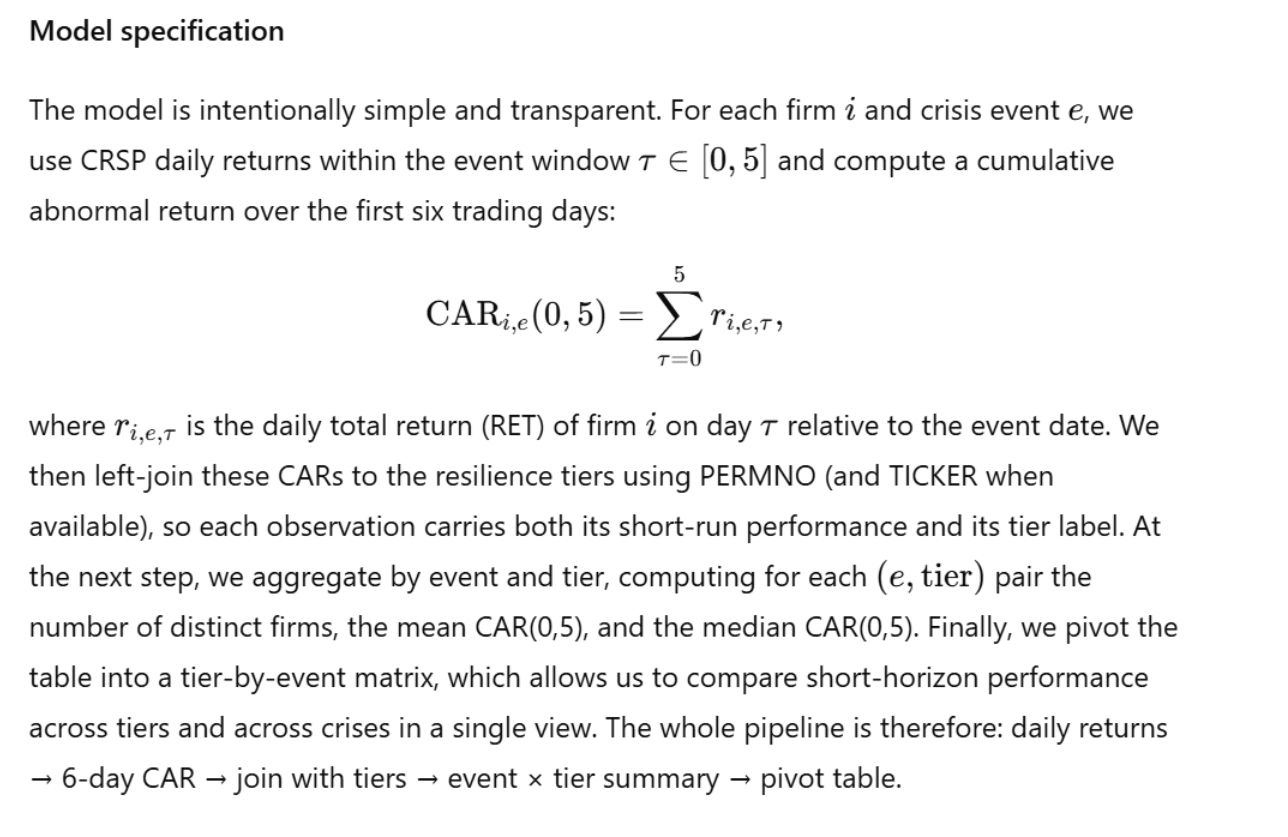


### **Empirical results**

The estimated CAR(0,5) patterns are coherent and economically intuitive. During the COVID circuit-breaker event, all tiers exhibit negative six-day cumulative returns, as expected in the middle of a global panic. However, the magnitude differs substantially: Tier 2 firms (strong in GFC and COVID but not Dotcom) show the deepest short-run losses, with an average CAR(0,5) close to −10%, whereas Tier 1 firms (strong in all three crises) and Tier 3 firms (strong only in COVID) experience considerably milder declines, on the order of −4% on average. In the Dotcom burst, average CAR(0,5) is also negative across the board, and again Tier 1 firms have the smallest short-horizon loss, while mid-generation and young firms are more exposed to the technology-driven de-rating. The Lehman event in 2008 shows the opposite sign: all three tiers earn positive CAR(0,5), reflecting a relief rally after the initial shock, but Tier 1 firms capture the strongest rebound (around +19–20%), Tier 2 firms recover more modestly (around +10%), and Tier 3 firms show only a small positive move (around +2%).

### **Interpretation and use**

Taken together, these results confirm that the resilience tiers are not just a statistical construct but carry real economic information about short-run crisis behavior. Veteran firms classified as strong in all three crises do not merely “eventually recover” in our longer-horizon metrics; they already start to outperform within the first trading week after a major shock—losing less in crash weeks and participating more in the immediate rebound, especially in financial-system events like Lehman. Mid-generation firms in Tier 2 appear to be more sensitive to the nature of the shock: they suffer disproportionately in the COVID event despite having looked strong in previous crises, while young “COVID-winner” names in Tier 3 are more crisis-specific and offer less consistent protection outside that context. For an analyst or portfolio manager, the CAR(0,5) tier-comparison model therefore acts as a compact supporting model: it links our structural resilience classification to actual short-horizon P&L, and suggests that tilting portfolios toward Tier 1 names is likely to improve downside protection and early-rebound capture in future stress scenarios, while exposures to Tier 2 and Tier 3 should be sized with their crisis-type sensitivity in mind.

# LLM Ops (RAG Agent)

After identifying an initial universe of 1249 candidate companies across the three tiers, we realized that not all of them were suitable for our case studies. Listing dates and corporate actions differ widely: some firms were not yet public during the earlier crisis windows, others were acquired, taken private, or delisted before later events, and several went through ticker or name changes. To avoid these data breaks, we manually checked each company’s listing history and major corporate events and then applied a set of calendar-based filters. Concretely, we required that each Tier’s companies line up cleanly with the stress-test periods we use in the analysis. Tier 1 (“veterans”) companies had to be listed before 2000 and remain trading through all three crises so that they face the 2000, 2008, and 2020 shocks. Tier 2 (“mid-generation”) companies had to IPO after 2000 but before 2008, ensuring they are exposed to the 2008 Global Financial Crisis and the 2020 COVID shock but not the 2000 episode. Tier 3 (“new generation”) companies were selected to be relatively young names, ideally listed after the 2008 crisis, so that they primarily experience the COVID-era stress rather than decades of earlier history. Using this manual screening, we narrowed the universe down to just over 30 companies that have clean, continuous histories and are well aligned with our three-tier stress-testing logic.

## Tier 1

- **NBT Bancorp Inc. (NBTB)** — Founded 1856, IPO 1986, Industry: Regional Banks


## Tier 2

- **Argo Group International Holdings, Ltd. (AGX)** — Founded 1986, IPO 1999, Industry: Property & Casualty Insurance
- **Corporate Capital Trust (CIA)** — Founded 2008, IPO N/A, Industry: Finance
- **CVB Financial Corp. (CVB)** — Founded 1974, IPO 1981, Industry: Regional Banks
- **Citizens & Northern Corporation (CZNC)** — Founded 1864, IPO 1984, Industry: Regional Banks
- **Eagle Bancorp Montana, Inc. (EBMT)** — Founded 1922, IPO 1998, Industry: Regional Banks
- **Elmira Savings Bank (ESBK)** — Founded 1869, IPO N/A, Industry: Regional Banks
- **First Financial Northwest, Inc. (FFNW)** — Founded 1923, IPO 2007, Industry: Regional Banks
- **First Mid Bancshares, Inc. (FMBH)** — Founded 1965, IPO N/A, Industry: Regional Banks
- **LM Funding America, Inc. (LMFA)** — Founded 2008, IPO 2015, Industry: Finance


## Tier 3

- **Atlas Air Worldwide Holdings, Inc. (AAWW)** — Founded 1992, IPO 1993, Industry: Air Freight & Logistics
- **Armstrong Flooring, Inc. (AFI)** — Founded 1860, IPO 2016, Industry: Building Materials
- **Agile Therapeutics, Inc. (AGRX)** — Founded 1997, IPO 2014, Industry: Biotechnology
- **Aileron Therapeutics, Inc. (ALRN)** — Founded 2001, IPO 2017, Industry: Biotechnology
- **American Shared Hospital Services (AMS)** — Founded 1980, IPO 1983, Industry: Healthcare Equipment & Services
- **Applied UV, Inc. (AUVI)** — Founded 2019, IPO 2020, Industry: Industrial Equipment
- **Biodesix, Inc. (BDSX)** — Founded 2006, IPO 2020, Industry: Biotechnology
- **Beasley Broadcast Group, Inc. (BBGI)** — Founded 1961, IPO 2000, Industry: Broadcasting
- **Bone Biologics Corporation (BBLG)** — Founded 2004, IPO 2014, Industry: Biotechnology
- **Burford Capital Limited (BUR)** — Founded 2009, IPO 2020, Industry: Financial Services
- **Burgerville (BURG)** — Founded 1961, IPO N/A, Industry: Restaurants
- **China Recycling Energy Corp. (CREG)** — Founded 1980, IPO 2007, Industry: Renewable Energy
- **Crown Crafts, Inc. (CRWS)** — Founded 1957, IPO 1995, Industry: Consumer Goods

Then, we built a **Retrieval-Augmented Generation (RAG) agent** extracts Management Discussion & Analysis sections from company 10-K filings, chunks the text, generates semantic embeddings using sentence-transformers, and stores them in a local ChromaDB vector database. When queried, it retrieves the most relevant text chunks and uses an LLM to synthesize insights comparing financial strategies across survivor vs. non-survivor companies during crisis periods. We will deploy the agent online via Streamlit Cloud and present it.

## Conclusion

This project analyzed the characteristics and distribution of extreme one-day price drops in S&P 500 stocks between 2019 and 2024 to quantify key aspects of market tail risk. By employing a dual-threshold event definition ($\ge 5\%$ drop and $\le -2.5\sigma$ Z-score), we distinguished between **systematic** (macro-driven) and **idiosyncratic** (firm-specific) crashes.

### Key Findings

The analysis establishes three critical insights into modern market dynamics:

1.  **Structural Volatility Regime Shift:** The market has not reverted to its pre-COVID baseline. Post-2021 data reveals a sustained, **elevated volatility regime**, where the monthly rate of extreme events is approximately **$1.7\times$** higher than the 2019 baseline. This finding suggests that risk models calibrated on pre-2020 volatility metrics are likely miscalibrated and underestimate current tail risk exposure.
2.  **Idiosyncratic Crash Dominance:** The primary driver of sustained elevated volatility is **idiosyncratic risk**, not constant systemic panic. Furthermore, idiosyncratic crashes are statistically more severe than systematic ones, producing a slightly **fatter ultra-left tail** and carrying the highest incidence of $\mathbf{7-10\sigma}$ collapses.
3.  **Firm Resilience Stratification:** By analyzing stock price trajectories across major crises (Dotcom, GFC, COVID), the model successfully developed a quantitative metric for corporate resilience. This allows for the identification of a **"Tier 1: veteran"** class of firms that consistently demonstrated the quickest and most efficient price recovery across multiple crisis regimes.

### Implications for Risk Management

The results provide actionable insights for portfolio management:

* **Risk Model Recalibration:** The persistent elevation of the event rate necessitates a **re-evaluation of volatility inputs** in internal risk models. Managers must operate under the assumption of a structurally higher baseline for extreme events.
* **Targeting Idiosyncratic Risk:** The dominance of idiosyncratic events suggests that risk management efforts should be partially re-focused from purely market-wide hedges to **single-name risk controls** and proactive monitoring of firm-specific disclosures and technical indicators.
* **Resilience as an Alpha Factor:** The quantitative resilience profiles identified can be integrated into investment strategies as a factor to select firms with a demonstrable history of **efficient crisis recovery**, potentially improving portfolio stability during downturns.

In summary, the modern market tail risk landscape is characterized by **elevated volatility and a shift toward firm-specific shock severity**. This necessitates a transition to more granular, bottom-up risk management approaches that account for the individual resilience of firms within the S&P 500.

## Challenges and Future Research Directions

Despite the robust framework developed for event classification and resilience scoring, the analysis faces several methodological and data-related challenges that constrain the scope and certainty of specific conclusions. Addressing these limitations offers clear avenues for future research.

### 1. Classification Sensitivity and the Systematic Threshold

The primary challenge lies in the sensitivity of the Systematic event classification.

* **Problem:** Our definition of a systematic crash requires a stock's extreme drop to occur on a day where the S&P 500 index is down by a strict $\mathbf{\ge 2.0\%}$. This threshold may be overly restrictive.
* **Implication:** True systematic shocks (e.g., sector-wide liquidity crises) resulting in a market index move of, for instance, $-1.8\%$ would be artificially labeled as idiosyncratic. This potential misclassification may inflate the frequency and severity metrics of the idiosyncratic category, thereby casting doubt on the finding that single-name shocks are statistically more extreme than market-wide panics.
* **Future Direction:** Future work should test the robustness of the core findings across a range of market-return thresholds (e.g., $-1.5\%$, $-1.0\%$) and potentially incorporate sector-level return factors to better distinguish between market-wide and sector-specific systemic events.


### 2. Causal Inference vs. Correlation

While the project identifies strong <u>correlation</u> between event type (idiosyncratic vs. systematic) and severity, it does not establish <u>causal mechanisms</u>.

* **Problem:** The study cannot determine *why* the market has shifted to a structurally higher volatility regime or *why* idiosyncratic crashes are seemingly more severe. The analysis is solely based on price returns, lacking context from fundamental data.
* **Future Direction:** Future research could integrate firm-specific fundamental data (e.g., leverage ratios, earnings revisions) and textual analysis of news and financial disclosures** to attribute a causal factor to the most severe idiosyncratic shocks.


### 3. Limited Crisis-Resilience Depth

The resilience profile is based on price recovery trajectories from three major events (Dotcom, GFC, COVID).

* **Problem:** This analysis is limited by the small sample size of historical crises. Furthermore, the definition of "recovery" is a purely price-based metric and does not account for fundamental business health or market share erosion.
* **Future Direction:** The resilience scoring could be enhanced by incorporating a fundamental recovery metric (e.g., time taken for Revenue Per Share or Earnings Per Share to return to pre-crisis levels) to provide a more holistic view of enduring corporate strength.

# References

Primary and Future Data Sources
Wharton Research Data Services (WRDS)
 – Access firm-level and market return data
United States International Trade Commission (USITC)
 – Track tariff-related updates
Federal Reserve Economic Data (FRED)
 – Retrieve macroeconomic indicators programmatically
SEC EDGAR 10-K Filings
 – Access annual financial disclosures and narrative content
:test_tube: Data Science & Analysis Tools
PySpark
 – Use Spark with Python for distributed data processing
Google Cloud Storage (GCS)
 – Store and manage data in the cloud
JupyterLab
 – Interactive development environment for notebooks and code
Pandas
 – High-performance data structures and analysis tools
Matplotlib
 – Create static, animated, and interactive visualizations

# Generative AI Disclaimer

Elements of this research workflow were supported through the use of Generative Artificial Intelligence (GenAI) tools. GenAI was used to provide guidance on syntax selection, package options, and debugging assistance for coding tasks related to data processing and analysis. All final code, results, and interpretations were independently reviewed and validated by the research team.